Pass 1: Analyzing training data to calculate artifact thresholds...


Calculating thresholds: 100%|██████████| 2400/2400 [03:44<00:00, 10.68it/s]



Calculated Artifact Thresholds:
  - motion_std_thresh: 10.7116
  - max_abs_amp_thresh: 489477.4043
  - eeg_var_upper_thresh: 21427783.3539
  - eeg_var_lower_thresh: -10954872.6722


Filtering train: 100%|██████████| 2400/2400 [03:44<00:00, 10.67it/s]


Training: Kept 1880/2400 trials after filtering
Returning all validation trials (no filtering)
Returning all test trials (no filtering)

Loading and normalizing 1-7s data for 'train'...


Normalizing train: 100%|██████████| 208/208 [03:14<00:00,  1.07it/s]



Loading and normalizing 1-7s data for 'validation'...


Normalizing validation: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]



Loading and normalizing 1-7s data for 'test'...


Normalizing test: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]



Generating plots for the cleaned and normalized data...


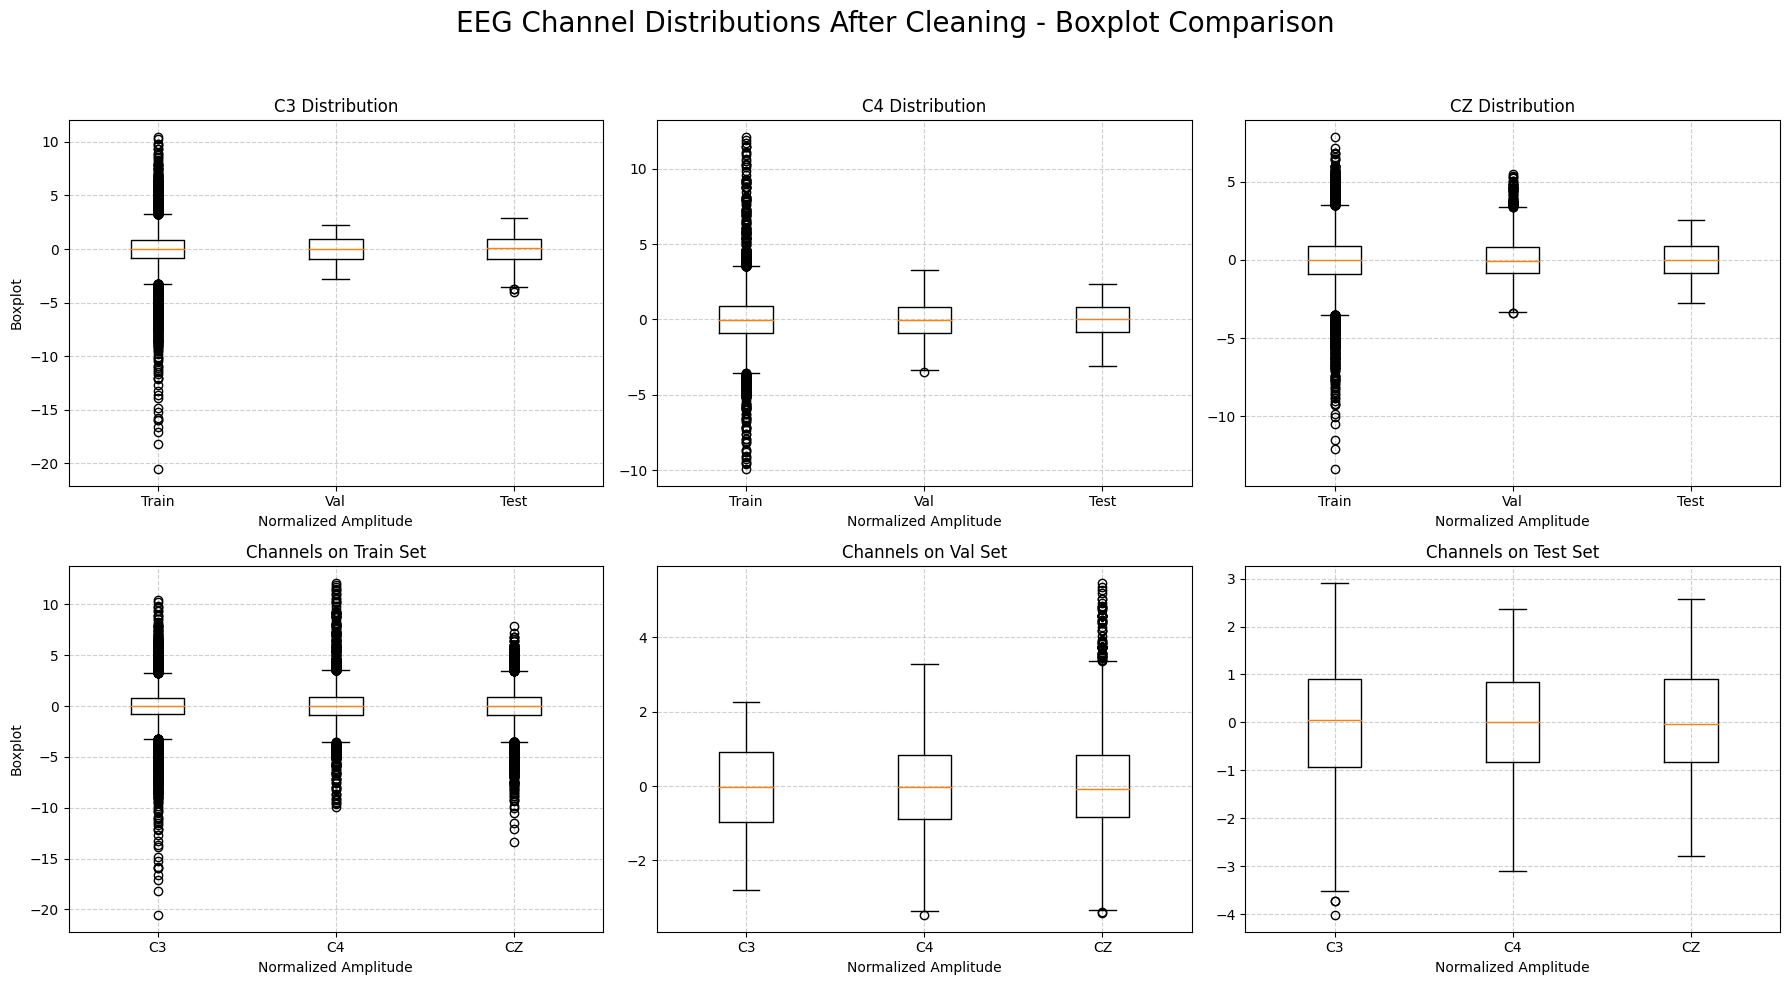

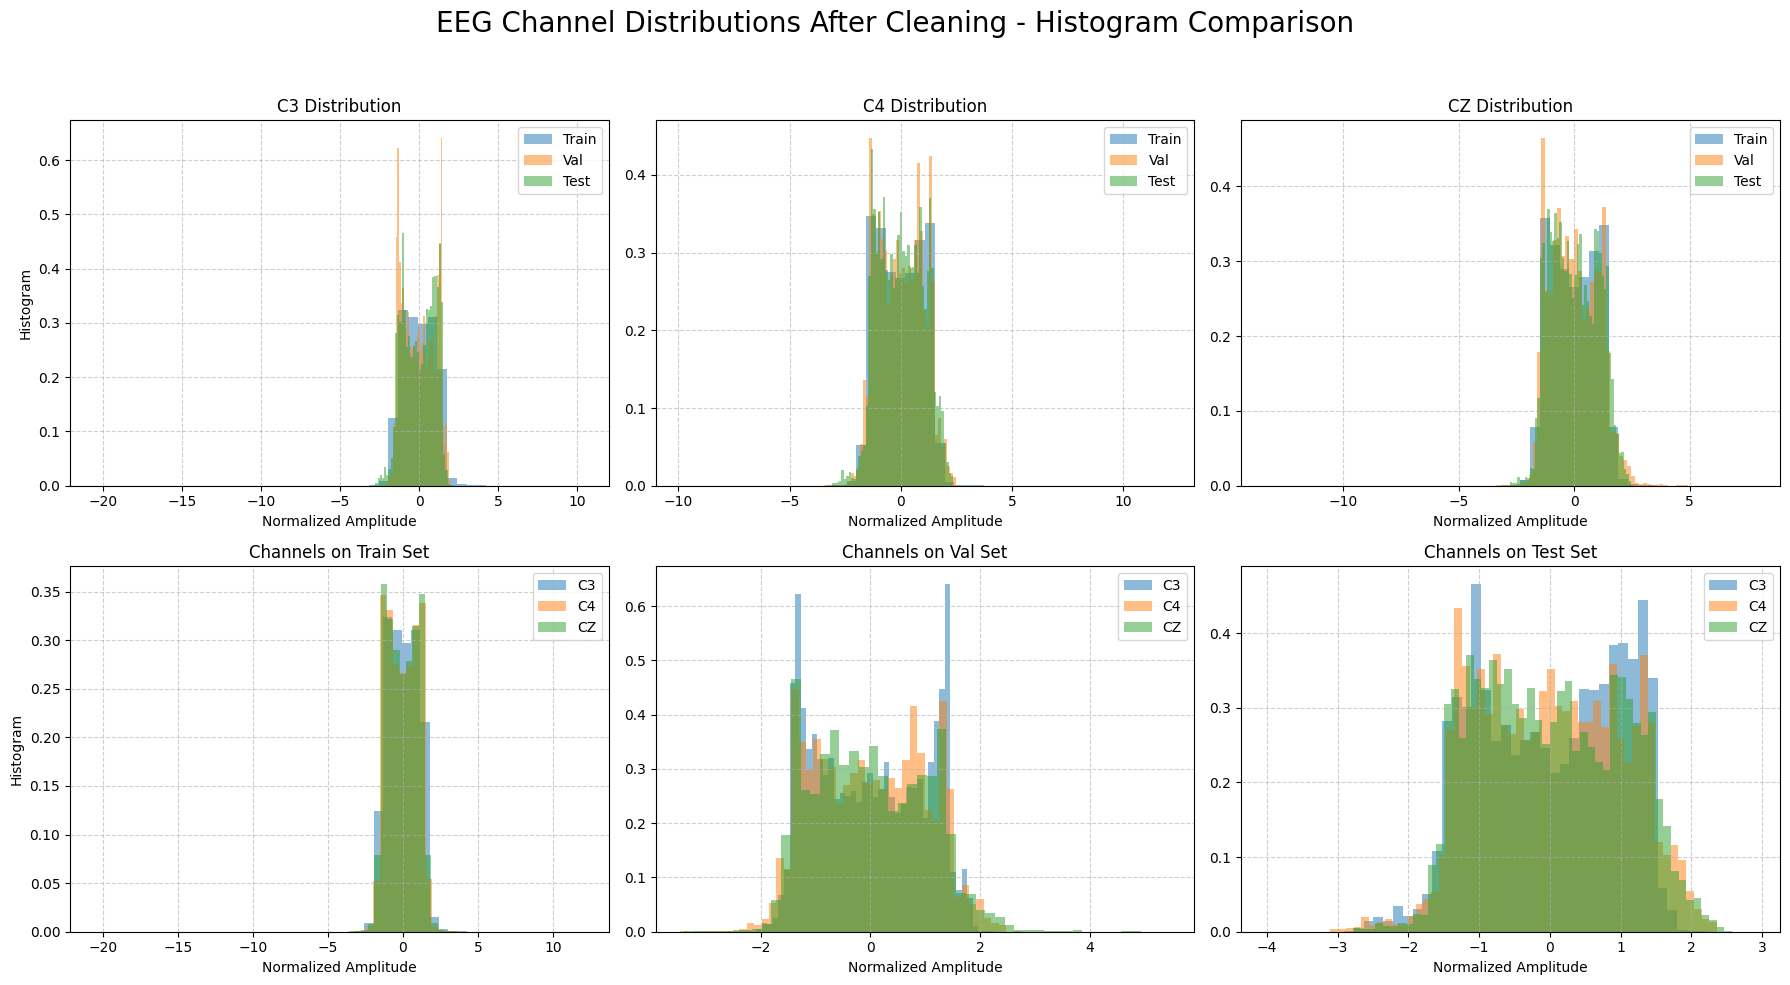

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

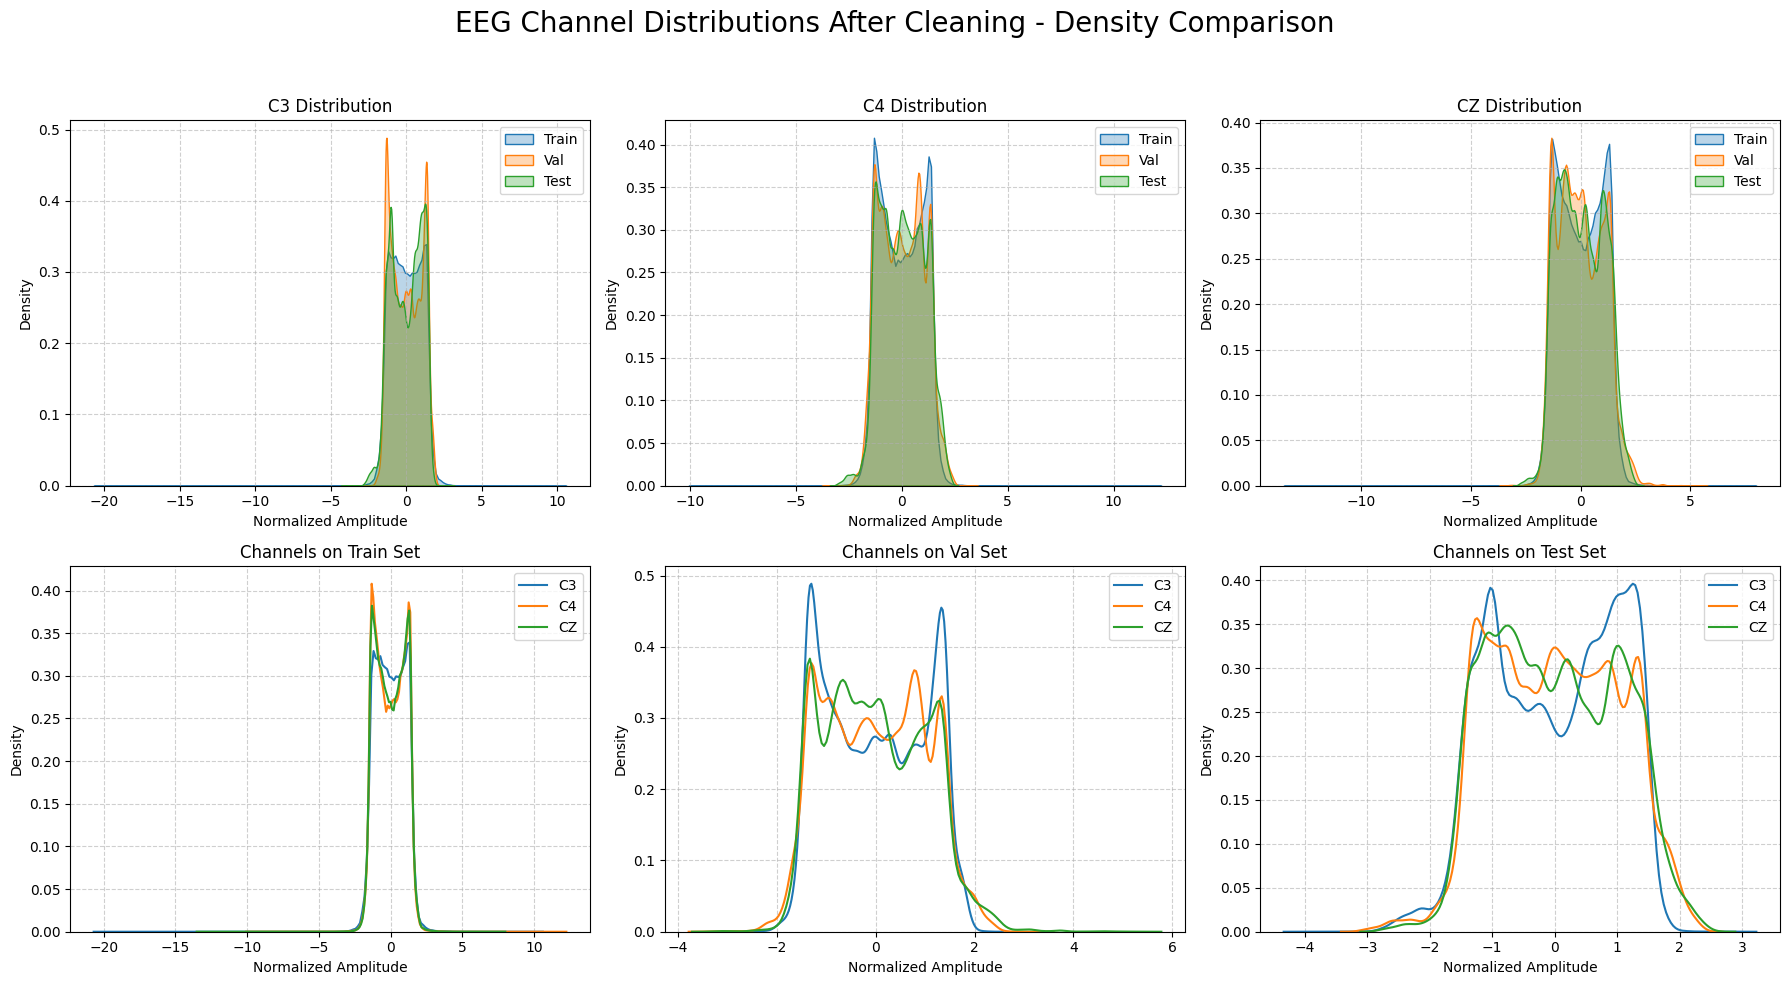


FINAL CHANNEL STATISTICS (POST-CLEANING & NORMALIZATION)

TRAIN DISTRIBUTION STATISTICS (POST-CLEANING):
| Channel   |        Mean |      Std |   Skewness |   Kurtosis |       Min |       25% |     Median |      75% |      Max |
|:----------|------------:|---------:|-----------:|-----------:|----------:|----------:|-----------:|---------:|---------:|
| C3        |  0.00578121 | 0.9726   | 0.00177407 | -0.0820805 | -20.5547  | -0.808688 | -0.0043344 | 0.830202 | 10.4655  |
| C4        | -0.0189148  | 0.986636 | 0.0467027  | -0.884711  |  -9.92177 | -0.90935  | -0.0272973 | 0.865405 | 12.1026  |
| CZ        | -0.0108347  | 0.981941 | 0.0173475  | -0.936277  | -13.3703  | -0.8834   | -0.0263415 | 0.862198 |  7.84827 |

VALIDATION DISTRIBUTION STATISTICS (POST-CLEANING):
| Channel   |       Mean |     Std |   Skewness |   Kurtosis |      Min |       25% |     Median |      75% |     Max |
|:----------|-----------:|--------:|-----------:|-----------:|---------:|----------:|-----------:|---

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# ==============================
# CONFIGURATION
# ==============================
# Base path for the dataset on Kaggle
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"  # Focus on Motor Imagery



# EEG and Motion Sensor channel definitions
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
TARGET_CHANNELS = ['C3', 'C4', 'CZ']  # Channels for detailed analysis
MOTION_CHANNELS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']

# Signal properties
SAMPLE_RATE = 250
TRIAL_DURATION = 9  # seconds for MI
SAMPLES_PER_TRIAL = SAMPLE_RATE * TRIAL_DURATION
ARTIFACT_STD_THRESHOLD = 1.0 # Threshold in standard deviations for outlier removal
TIME_WINDOW = (1, 7)  # Focus on 1-7s window
TIME_WINDOW_SAMPLES = int((TIME_WINDOW[1] - TIME_WINDOW[0]) * SAMPLE_RATE)  # 1500 samples

# ==============================
# DATA LOADING (HELPER)
# ==============================

def load_single_trial(row, dataset_type, base_path, time_window=None):
    """Loads raw data with optional time window selection"""
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset_type,
        row['subject_id'],
        str(row['trial_session']),
        "EEGdata.csv"
    )
    if not os.path.exists(eeg_path):
        return None

    eeg_data = pd.read_csv(eeg_path).drop_duplicates()
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    trial_data = eeg_data.iloc[start_idx:end_idx]
    
    # Extract time window if specified
    if time_window:
        start_sample = int(time_window[0] * SAMPLE_RATE)
        end_sample = int(time_window[1] * SAMPLE_RATE)
        trial_data = trial_data.iloc[start_sample:end_sample]
        
    return trial_data


# ==============================
# ARTIFACT DETECTION & THRESHOLD CALCULATION (PASS 1)
# ==============================

def calculate_artifact_thresholds(df, base_path):
    """
    Analyzes all training trials to compute metrics and determine outlier thresholds.
    This is the first pass over the data.
    """
    print("Pass 1: Analyzing training data to calculate artifact thresholds...")
    metrics = []
    
    # Use only the MI task data from the training set
    mi_df = df[df['task'] == TASK].copy()

    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc="Calculating thresholds"):
        trial_data = load_single_trial(row, 'train', base_path)
        if trial_data is None or trial_data.empty:
            continue

        # 1. Motion metrics
        motion_std = trial_data[MOTION_CHANNELS].std().sum()

        # 2. Amplitude and Variance metrics for EEG
        eeg_data = trial_data[EEG_CHANNELS]
        max_abs_amplitude = eeg_data.abs().max().max()
        eeg_variance = eeg_data.var().mean()

        metrics.append({
            'id': row['id'],
            'motion_std': motion_std,
            'max_abs_amplitude': max_abs_amplitude,
            'eeg_variance': eeg_variance
        })

    metrics_df = pd.DataFrame(metrics)
    
    # Calculate thresholds using the 3-sigma rule
    thresholds = {
        'motion_std_thresh': metrics_df['motion_std'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['motion_std'].std(),
        'max_abs_amp_thresh': metrics_df['max_abs_amplitude'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['max_abs_amplitude'].std(),
        'eeg_var_upper_thresh': metrics_df['eeg_variance'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['eeg_variance'].std(),
        'eeg_var_lower_thresh': metrics_df['eeg_variance'].mean() - ARTIFACT_STD_THRESHOLD * metrics_df['eeg_variance'].std()
    }

    print("\nCalculated Artifact Thresholds:")
    for key, val in thresholds.items():
        print(f"  - {key}: {val:.4f}")
        
    return thresholds, metrics_df

# ==============================
# DATA CLEANING AND FILTERING (PASS 2)
# ==============================

def get_clean_trials(df, dataset_type, base_path, thresholds):
    """Only filter training data, keep all validation/test"""
    if dataset_type == 'train':
        # Original filtering logic for training set
        mi_df = df[df['task'] == TASK].copy()
        clean_ids = []
        
        for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc=f"Filtering {dataset_type}"):
            # Load full trial (0-9s) for artifact detection
            trial_data = load_single_trial(row, dataset_type, base_path)
            if trial_data is None or trial_data.empty:
                continue
                
            motion_std = trial_data[MOTION_CHANNELS].std().sum()
            max_abs_amplitude = trial_data[EEG_CHANNELS].abs().max().max()
            eeg_variance = trial_data[EEG_CHANNELS].var().mean()
            
            if (motion_std < thresholds['motion_std_thresh'] and
                max_abs_amplitude < thresholds['max_abs_amp_thresh'] and
                thresholds['eeg_var_lower_thresh'] < eeg_variance < thresholds['eeg_var_upper_thresh']):
                clean_ids.append(row['id'])
                
        clean_df = df[df['id'].isin(clean_ids)].copy()
        print(f"Training: Kept {len(clean_df)}/{len(mi_df)} trials after filtering")
        return clean_df
    else:
        # Return all data for validation/test sets
        print(f"Returning all {dataset_type} trials (no filtering)")
        return df[df['task'] == TASK].copy()

# ==============================
# NORMALIZATION & FINAL DATA PREPARATION
# ==============================

def load_normalized_clean_data(clean_df, dataset_type, base_path):
    """Loads and normalizes 1-7s data for clean trials"""
    print(f"\nLoading and normalizing 1-7s data for '{dataset_type}'...")
    channel_data = {ch: [] for ch in TARGET_CHANNELS}
    
    grouped = clean_df.groupby(['subject_id', 'trial_session'])
    
    for (subject, session), group in tqdm(grouped, desc=f"Normalizing {dataset_type}"):
        session_path = os.path.join(base_path, TASK, dataset_type, subject, str(session), "EEGdata.csv")
        if not os.path.exists(session_path):
            continue
        
        full_session_df = pd.read_csv(session_path).drop_duplicates()
        session_means = full_session_df[EEG_CHANNELS].mean()
        session_stds = full_session_df[EEG_CHANNELS].std()

        for _, row in group.iterrows():
            # Load only 1-7s segment
            trial_data = load_single_trial(row, dataset_type, base_path, time_window=TIME_WINDOW)
            if trial_data is None:
                continue

            normalized_trial = (trial_data[EEG_CHANNELS] - session_means) / (session_stds + 1e-8)
            
            for channel in TARGET_CHANNELS:
                channel_data[channel].extend(normalized_trial[channel].values)
                
    return channel_data

# ==============================
# VISUALIZATION
# ==============================

def create_plots(data_dict, plot_type, title_prefix):
    """
    Creates boxplots, histograms, or density plots for all channels and datasets.
    """
    if not any(data_dict['train'].values()):
        print(f"Skipping {plot_type} plots for '{title_prefix}' as there is no data.")
        return
        
    plt.figure(figsize=(18, 10))
    
    for i, channel in enumerate(TARGET_CHANNELS, 1):
        ax = plt.subplot(2, 3, i)
        
        # Plot data for train, val, and test combined on one subplot
        if plot_type == 'boxplot':
            plot_data = [data_dict[ds][channel] for ds in ['train', 'val', 'test'] if data_dict[ds][channel]]
            labels = [ds.capitalize() for ds in ['train', 'val', 'test'] if data_dict[ds][channel]]
            if plot_data:
                ax.boxplot(plot_data, labels=labels)
        elif plot_type == 'density':
            for ds in ['train', 'val', 'test']:
                if data_dict[ds][channel]:
                    sns.kdeplot(data_dict[ds][channel], label=ds.capitalize(), fill=True, alpha=0.3, ax=ax)
            ax.legend()
        elif plot_type == 'histogram':
             for ds in ['train', 'val', 'test']:
                if data_dict[ds][channel]:
                    ax.hist(data_dict[ds][channel], bins=50, density=True, alpha=0.5, label=ds.capitalize())
             ax.legend()

        ax.set_title(f'{channel} Distribution')
        ax.set_xlabel('Normalized Amplitude')
        if i == 1:
            ax.set_ylabel(plot_type.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)

    # Plot data for each dataset separately
    for i, ds in enumerate(['train', 'val', 'test']):
        ax = plt.subplot(2, 3, i + 4)
        channel_plot_data = [data_dict[ds][ch] for ch in TARGET_CHANNELS if data_dict[ds][ch]]
        labels = [ch for ch in TARGET_CHANNELS if data_dict[ds][ch]]
        if channel_plot_data:
            if plot_type == 'boxplot':
                ax.boxplot(channel_plot_data, labels=labels)
            else: # For histogram and density, we overlay
                for ch in TARGET_CHANNELS:
                    if data_dict[ds][ch]:
                        if plot_type == 'histogram':
                            ax.hist(data_dict[ds][ch], bins=50, density=True, alpha=0.5, label=ch)
                        elif plot_type == 'density':
                            sns.kdeplot(data_dict[ds][ch], label=ch, ax=ax)
                ax.legend()
        
        ax.set_title(f'Channels on {ds.capitalize()} Set')
        ax.set_xlabel('Normalized Amplitude')
        if i == 0:
            ax.set_ylabel(plot_type.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(f'{title_prefix} - {plot_type.capitalize()} Comparison', fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ==============================
# STATISTICS
# ==============================

def print_distribution_stats(data, name):
    """Prints detailed distribution statistics for a given dataset."""
    if not any(data.values()):
        print(f"\nNo data to display for {name.upper()} statistics.")
        return
        
    print(f"\n{name.upper()} DISTRIBUTION STATISTICS (POST-CLEANING):")
    stats_data = []
    for channel in TARGET_CHANNELS:
        if not data[channel]: continue
        channel_stats = {
            'Channel': channel,
            'Mean': np.mean(data[channel]),
            'Std': np.std(data[channel]),
            'Skewness': stats.skew(data[channel]),
            'Kurtosis': stats.kurtosis(data[channel]),
            'Min': np.min(data[channel]),
            '25%': np.percentile(data[channel], 25),
            'Median': np.median(data[channel]),
            '75%': np.percentile(data[channel], 75),
            'Max': np.max(data[channel])
        }
        stats_data.append(channel_stats)
    
    if stats_data:
        stats_df = pd.DataFrame(stats_data)
        print(stats_df.to_markdown(index=False))

# ==============================
# MAIN EXECUTION
# ==============================

# Load data indices
train_df_full = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
validation_df_full = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df_full = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# --- Pass 1: Calculate thresholds from training data ---
artifact_thresholds, _ = calculate_artifact_thresholds(train_df_full, BASE_PATH)

# --- Pass 2: Filter all datasets using these thresholds ---
train_df_clean = get_clean_trials(train_df_full, 'train', BASE_PATH, artifact_thresholds)
validation_df_clean = get_clean_trials(validation_df_full, 'validation', BASE_PATH, artifact_thresholds)
test_df_clean = get_clean_trials(test_df_full, 'test', BASE_PATH, artifact_thresholds)

# --- Load, normalize, and process the final clean data ---
train_data_clean = load_normalized_clean_data(train_df_clean, 'train', BASE_PATH)
val_data_clean = load_normalized_clean_data(validation_df_clean, 'validation', BASE_PATH)
test_data_clean = load_normalized_clean_data(test_df_clean, 'test', BASE_PATH)

# --- Combine data for plotting ---
all_clean_data = {
    'train': train_data_clean,
    'val': val_data_clean,
    'test': test_data_clean
}

# --- Generate Visualizations on Cleaned Data ---
print("\nGenerating plots for the cleaned and normalized data...")
create_plots(all_clean_data, 'boxplot', 'EEG Channel Distributions After Cleaning')
create_plots(all_clean_data, 'histogram', 'EEG Channel Distributions After Cleaning')
create_plots(all_clean_data, 'density', 'EEG Channel Distributions After Cleaning')

# --- Print Final Statistics on Cleaned Data ---
print("\n" + "="*60)
print("FINAL CHANNEL STATISTICS (POST-CLEANING & NORMALIZATION)")
print("="*60)
print_distribution_stats(train_data_clean, "Train")
print_distribution_stats(val_data_clean, "Validation")
print_distribution_stats(test_data_clean, "Test")

Pass 1: Analyzing training data to calculate artifact thresholds...


Calculating thresholds: 100%|██████████| 2400/2400 [04:24<00:00,  9.09it/s]



Calculated Artifact Thresholds:
  - motion_std_thresh: 10.7116
  - max_abs_amp_thresh: 489477.3279
  - eeg_var_upper_thresh: 21294435.4014
  - eeg_var_lower_thresh: -10907201.2149

Data Validation Stats (Pass 1):
  - Total duplicates removed: 0
  - Total values interpolated: 9162480
  - Total invalid rows handled: 1145310


Filtering train: 100%|██████████| 2400/2400 [04:25<00:00,  9.04it/s]


Training: Kept 1880/2400 trials after filtering

Data Validation Stats (Train):
  - Total duplicates removed: 0
  - Total values interpolated: 9162480
  - Total invalid rows handled: 1145310
Processing all validation trials (no filtering)


Processing validation: 100%|██████████| 50/50 [00:05<00:00,  9.27it/s]



Data Validation Stats (Validation):
  - Total duplicates removed: 0
  - Total values interpolated: 397360
  - Total invalid rows handled: 49670
Processing all test trials (no filtering)


Processing test: 100%|██████████| 50/50 [00:05<00:00,  9.15it/s]



Data Validation Stats (Test):
  - Total duplicates removed: 0
  - Total values interpolated: 341520
  - Total invalid rows handled: 42690

GLOBAL DATA VALIDATION SUMMARY
Total duplicates removed: 0
Total values interpolated: 19063840
Total invalid rows handled: 2382980

Loading and normalizing 1-7s data for 'train'...


Normalizing train: 100%|██████████| 208/208 [00:26<00:00,  7.87it/s]



Loading and normalizing 1-7s data for 'validation'...


Normalizing validation: 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]



Loading and normalizing 1-7s data for 'test'...


Normalizing test: 100%|██████████| 5/5 [00:00<00:00,  7.83it/s]



Generating plots for the cleaned and normalized data...


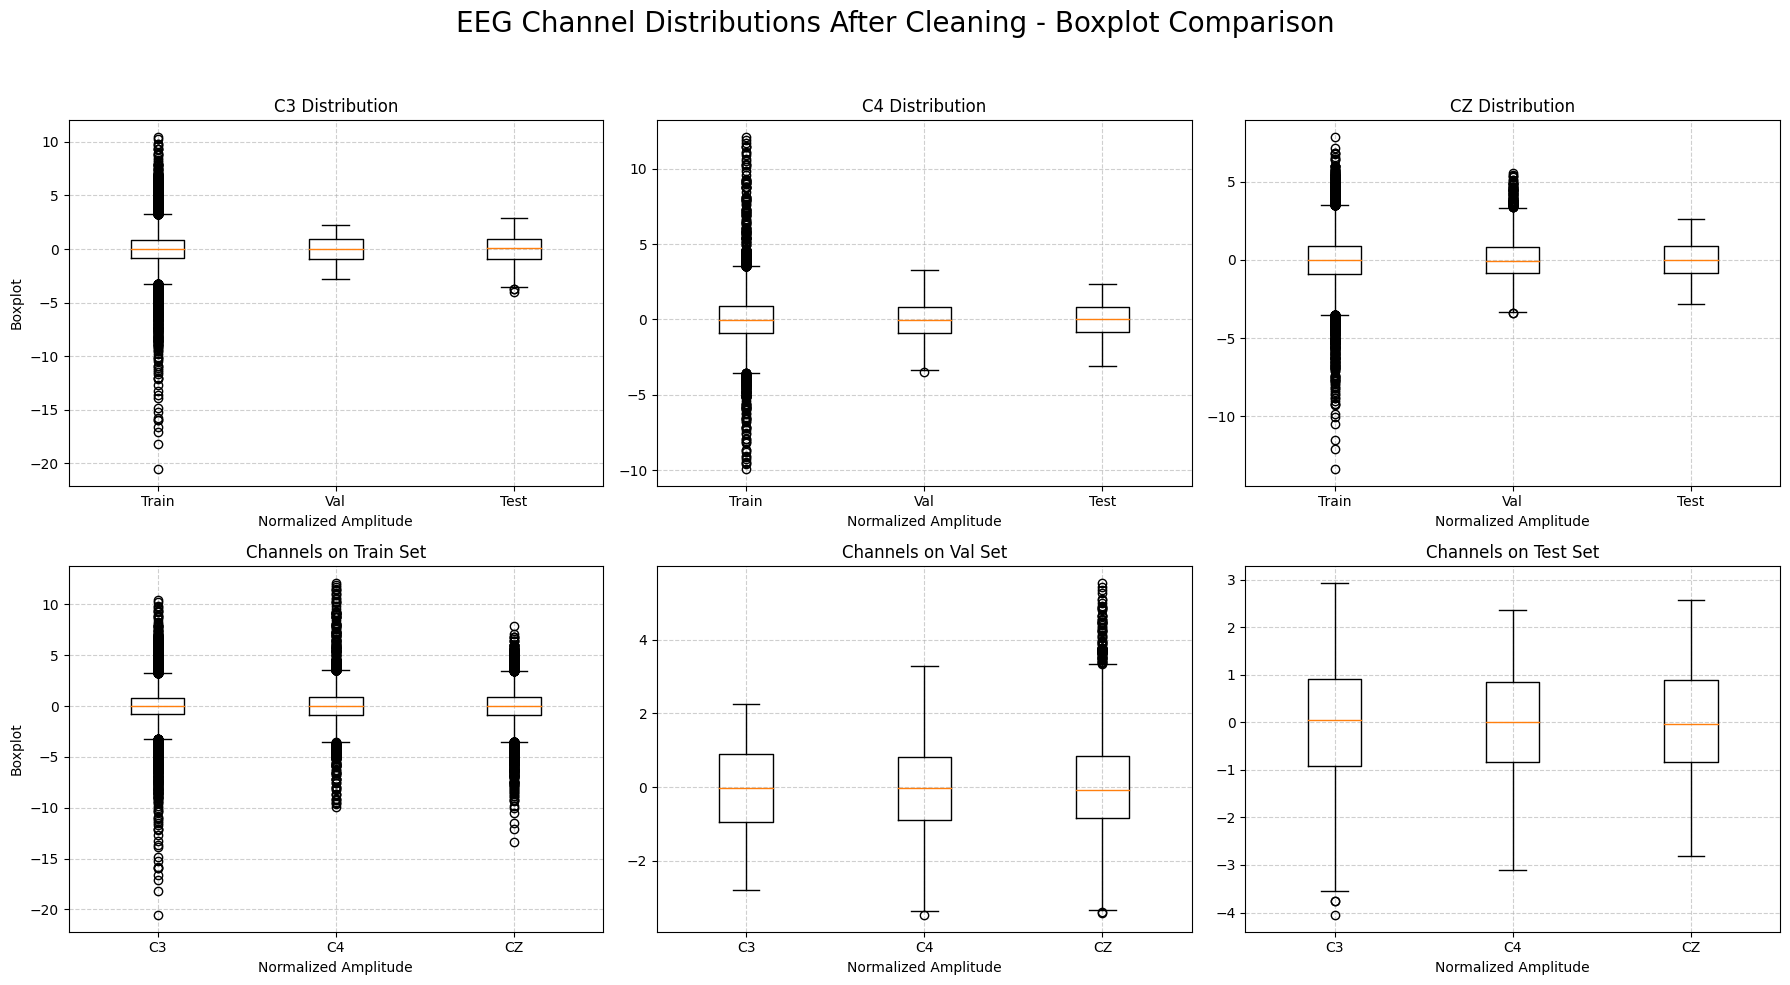

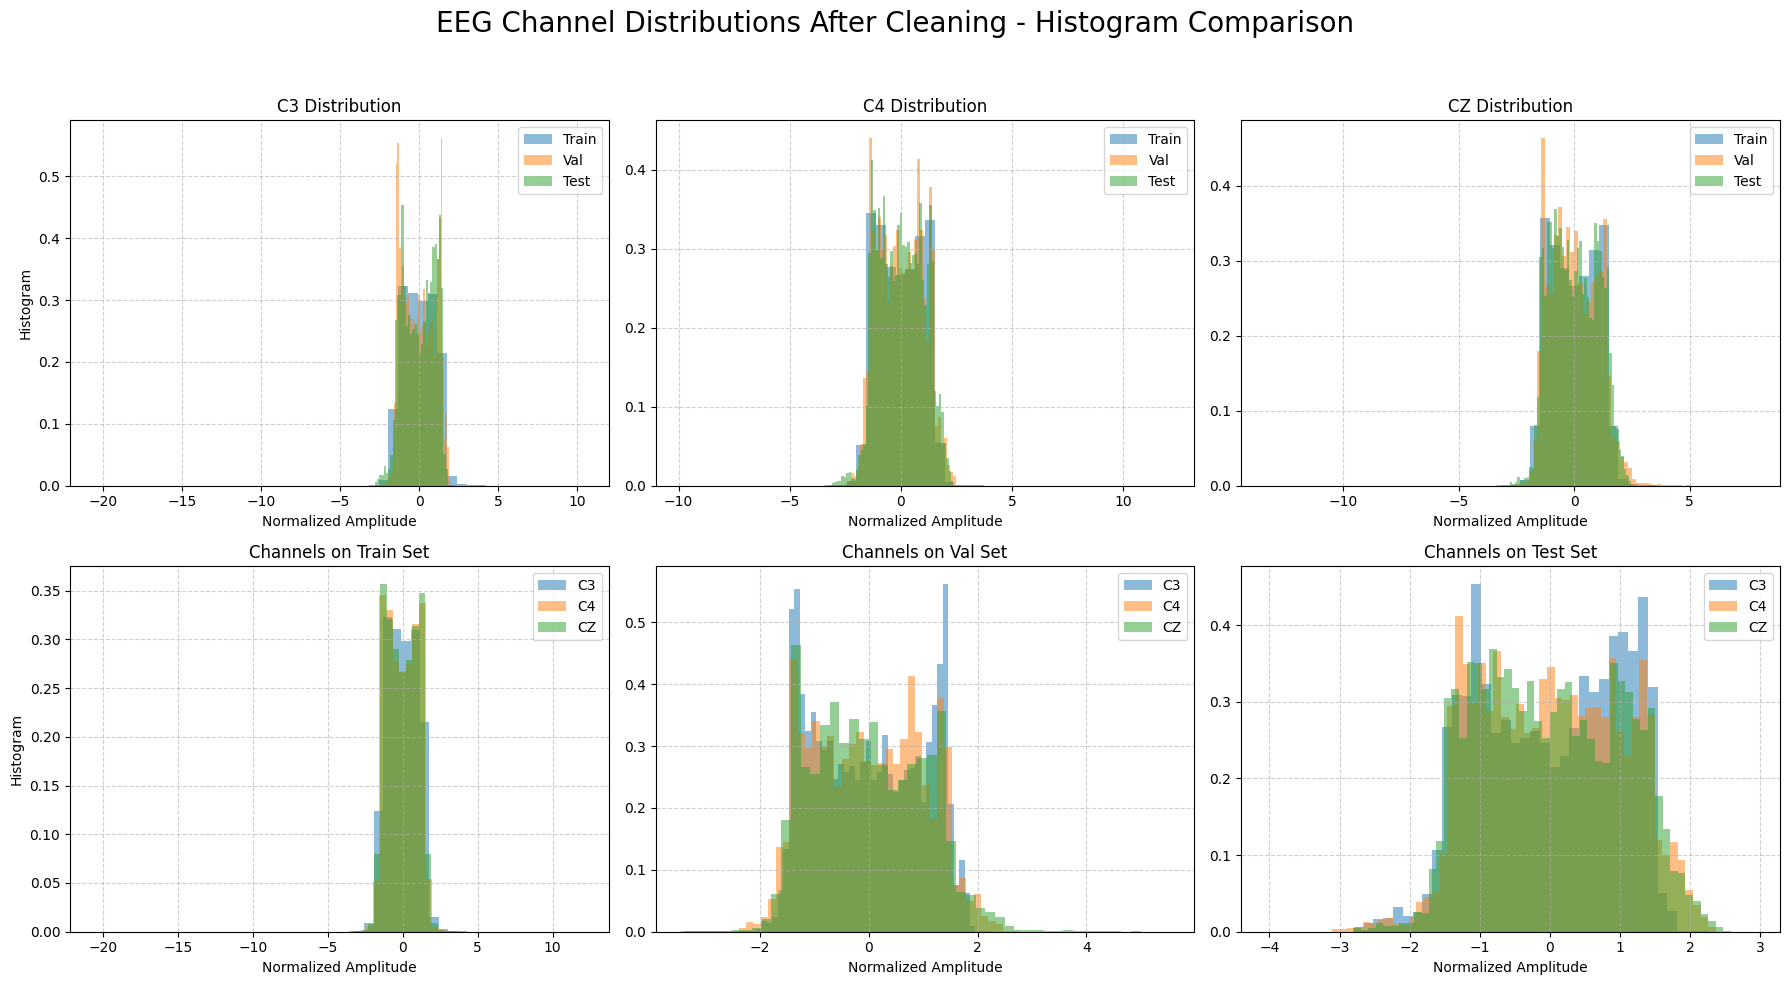

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

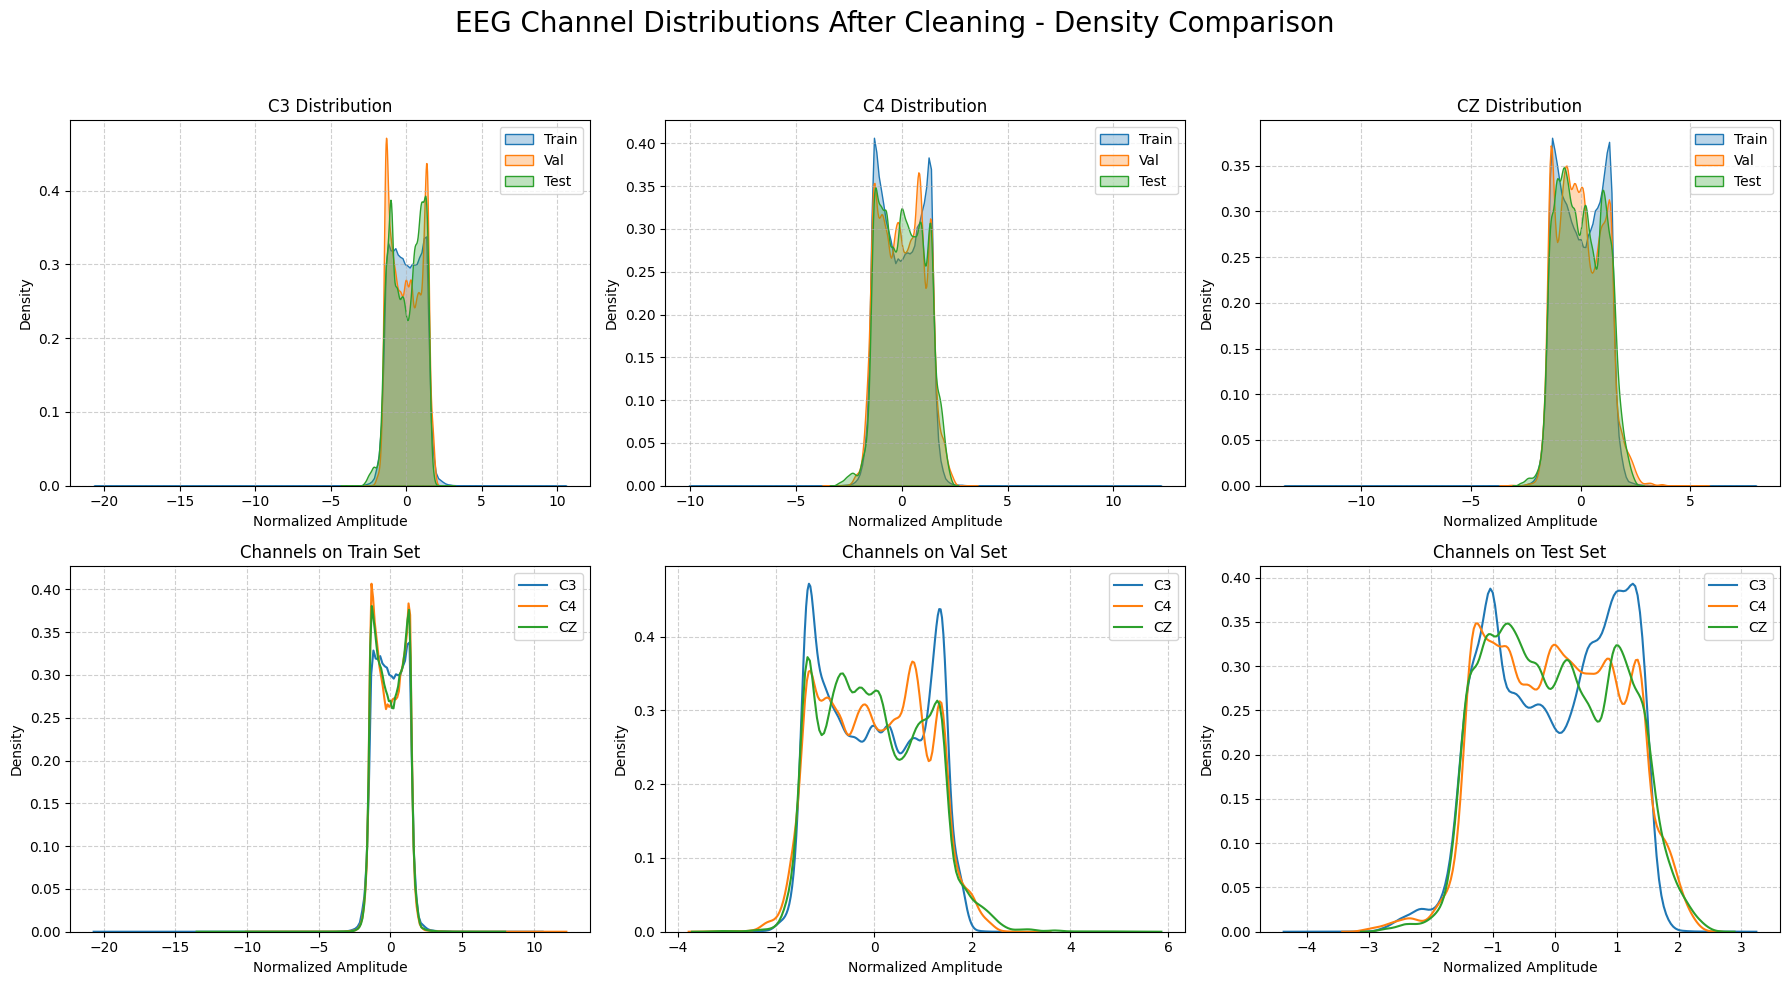


FINAL CHANNEL STATISTICS (POST-CLEANING & NORMALIZATION)

TRAIN DISTRIBUTION STATISTICS (POST-CLEANING):
| Channel   |        Mean |      Std |   Skewness |   Kurtosis |       Min |       25% |      Median |      75% |      Max |
|:----------|------------:|---------:|-----------:|-----------:|----------:|----------:|------------:|---------:|---------:|
| C3        |  0.00596177 | 0.972943 | 0.00278021 | -0.0617967 | -20.5547  | -0.807761 | -0.00369804 | 0.828955 | 10.4648  |
| C4        | -0.0187934  | 0.986698 | 0.0466578  | -0.881314  |  -9.93494 | -0.908236 | -0.027146   | 0.864057 | 12.1186  |
| CZ        | -0.0106517  | 0.982084 | 0.0168775  | -0.933534  | -13.3703  | -0.88249  | -0.0259448  | 0.861312 |  7.84827 |

VALIDATION DISTRIBUTION STATISTICS (POST-CLEANING):
| Channel   |        Mean |      Std |   Skewness |   Kurtosis |      Min |       25% |     Median |      75% |     Max |
|:----------|------------:|---------:|-----------:|-----------:|---------:|----------:|-------

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# ==============================
# CONFIGURATION
# ==============================
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"  # Focus on Motor Imagery

# EEG and Motion Sensor channel definitions
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
TARGET_CHANNELS = ['C3', 'C4', 'CZ']  # Channels for detailed analysis
MOTION_CHANNELS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
VALIDATION_COL = 'Validation'  # Column name for validation flag

# Signal properties
SAMPLE_RATE = 250
TRIAL_DURATION = 9  # seconds for MI
SAMPLES_PER_TRIAL = SAMPLE_RATE * TRIAL_DURATION
ARTIFACT_STD_THRESHOLD = 1.0  # Threshold in standard deviations for outlier removal
TIME_WINDOW = (1, 7)  # Focus on 1-7s window
TIME_WINDOW_SAMPLES = int((TIME_WINDOW[1] - TIME_WINDOW[0]) * SAMPLE_RATE)  # 1500 samples

# Track duplicates and interpolation
TOTAL_DUPLICATES = 0
TOTAL_INTERPOLATED = 0
TOTAL_INVALID_ROWS = 0

# ==============================
# DATA LOADING (HELPER)
# ==============================

def load_single_trial(row, dataset_type, base_path, time_window=None):
    """Loads raw data with time window selection, handles duplicates, and interpolates invalid values"""
    global TOTAL_DUPLICATES, TOTAL_INTERPOLATED, TOTAL_INVALID_ROWS
    
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset_type,
        row['subject_id'],
        str(row['trial_session']),
        "EEGdata.csv"
    )
    if not os.path.exists(eeg_path):
        return None, 0, 0, 0

    # Load data and handle duplicates
    eeg_data = pd.read_csv(eeg_path)
    original_count = len(eeg_data)
    
    # Handle cross-session duplicates using composite key
    duplicate_mask = eeg_data.duplicated()
    duplicates_removed = duplicate_mask.sum()
    eeg_data = eeg_data[~duplicate_mask]
    
    # Handle invalid rows marked by Validation column
    invalid_mask = eeg_data.get(VALIDATION_COL, pd.Series(False)) == 0.0
    invalid_count = invalid_mask.sum()
    TOTAL_INVALID_ROWS += invalid_count
    
    # Replace invalid EEG values with NaN
    eeg_data.loc[invalid_mask, EEG_CHANNELS] = np.nan
    
    # Replace infinite values with NaN
    eeg_data[EEG_CHANNELS] = eeg_data[EEG_CHANNELS].replace([np.inf, -np.inf], np.nan)
    
    # Count NaNs before interpolation
    nan_count_before = eeg_data[EEG_CHANNELS].isna().sum().sum()
    
    # Interpolate missing values
    eeg_data[EEG_CHANNELS] = eeg_data[EEG_CHANNELS].interpolate(
        method='linear', 
        axis=0, 
        limit_direction='both'
    )
    
    nan_count_after = eeg_data[EEG_CHANNELS].isna().sum().sum()
    interpolated_count = nan_count_before - nan_count_after
    
    # Update global counters
    TOTAL_DUPLICATES += duplicates_removed
    TOTAL_INTERPOLATED += interpolated_count
    
    # Extract trial
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    trial_data = eeg_data.iloc[start_idx:end_idx]
    
    # Apply time window if specified
    if time_window:
        start_sample = int(time_window[0] * SAMPLE_RATE)
        end_sample = int(time_window[1] * SAMPLE_RATE)
        trial_data = trial_data.iloc[start_sample:end_sample]
        
    return trial_data, duplicates_removed, interpolated_count, invalid_count

# ==============================
# ARTIFACT DETECTION & THRESHOLD CALCULATION (PASS 1)
# ==============================

def calculate_artifact_thresholds(df, base_path):
    """Analyzes training trials to compute metrics and determine outlier thresholds"""
    print("Pass 1: Analyzing training data to calculate artifact thresholds...")
    metrics = []
    total_duplicates = 0
    total_interpolated = 0
    total_invalid = 0
    
    # Use only the MI task data from the training set
    mi_df = df[df['task'] == TASK].copy()

    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc="Calculating thresholds"):
        trial_data, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
            row, 'train', base_path
        )
        if trial_data is None or trial_data.empty:
            continue
            
        total_duplicates += duplicates_removed
        total_interpolated += interpolated_count
        total_invalid += invalid_count

        # 1. Motion metrics
        motion_std = trial_data[MOTION_CHANNELS].std().sum()

        # 2. Amplitude and Variance metrics for EEG
        eeg_data = trial_data[EEG_CHANNELS]
        max_abs_amplitude = eeg_data.abs().max().max()
        eeg_variance = eeg_data.var().mean()

        metrics.append({
            'id': row['id'],
            'motion_std': motion_std,
            'max_abs_amplitude': max_abs_amplitude,
            'eeg_variance': eeg_variance
        })

    metrics_df = pd.DataFrame(metrics)
    
    # Calculate thresholds using the 3-sigma rule
    thresholds = {
        'motion_std_thresh': metrics_df['motion_std'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['motion_std'].std(),
        'max_abs_amp_thresh': metrics_df['max_abs_amplitude'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['max_abs_amplitude'].std(),
        'eeg_var_upper_thresh': metrics_df['eeg_variance'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['eeg_variance'].std(),
        'eeg_var_lower_thresh': metrics_df['eeg_variance'].mean() - ARTIFACT_STD_THRESHOLD * metrics_df['eeg_variance'].std()
    }

    print("\nCalculated Artifact Thresholds:")
    for key, val in thresholds.items():
        print(f"  - {key}: {val:.4f}")
    
    print("\nData Validation Stats (Pass 1):")
    print(f"  - Total duplicates removed: {total_duplicates}")
    print(f"  - Total values interpolated: {total_interpolated}")
    print(f"  - Total invalid rows handled: {total_invalid}")
        
    return thresholds, metrics_df

# ==============================
# DATA CLEANING AND FILTERING (PASS 2)
# ==============================

def get_clean_trials(df, dataset_type, base_path, thresholds):
    """Filters training data, keeps all validation/test"""
    total_duplicates = 0
    total_interpolated = 0
    total_invalid = 0
    
    if dataset_type == 'train':
        # Original filtering logic for training set
        mi_df = df[df['task'] == TASK].copy()
        clean_ids = []
        
        for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc=f"Filtering {dataset_type}"):
            # Load full trial (0-9s) for artifact detection
            trial_data, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
                row, dataset_type, base_path
            )
            if trial_data is None or trial_data.empty:
                continue
                
            total_duplicates += duplicates_removed
            total_interpolated += interpolated_count
            total_invalid += invalid_count
                
            motion_std = trial_data[MOTION_CHANNELS].std().sum()
            max_abs_amplitude = trial_data[EEG_CHANNELS].abs().max().max()
            eeg_variance = trial_data[EEG_CHANNELS].var().mean()
            
            if (motion_std < thresholds['motion_std_thresh'] and
                max_abs_amplitude < thresholds['max_abs_amp_thresh'] and
                thresholds['eeg_var_lower_thresh'] < eeg_variance < thresholds['eeg_var_upper_thresh']):
                clean_ids.append(row['id'])
                
        clean_df = df[df['id'].isin(clean_ids)].copy()
        print(f"Training: Kept {len(clean_df)}/{len(mi_df)} trials after filtering")
    else:
        # Process all data for validation/test sets without filtering
        clean_df = df[df['task'] == TASK].copy()
        print(f"Processing all {dataset_type} trials (no filtering)")
        
        # Still need to load data to process duplicates and interpolation
        for _, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc=f"Processing {dataset_type}"):
            _, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
                row, dataset_type, base_path
            )
            total_duplicates += duplicates_removed
            total_interpolated += interpolated_count
            total_invalid += invalid_count
    
    print(f"\nData Validation Stats ({dataset_type.capitalize()}):")
    print(f"  - Total duplicates removed: {total_duplicates}")
    print(f"  - Total values interpolated: {total_interpolated}")
    print(f"  - Total invalid rows handled: {total_invalid}")
    
    return clean_df

# ==============================
# NORMALIZATION & FINAL DATA PREPARATION
# ==============================

def load_normalized_clean_data(clean_df, dataset_type, base_path):
    """Loads and normalizes 1-7s data for clean trials"""
    print(f"\nLoading and normalizing 1-7s data for '{dataset_type}'...")
    channel_data = {ch: [] for ch in TARGET_CHANNELS}
    
    grouped = clean_df.groupby(['subject_id', 'trial_session'])
    
    for (subject, session), group in tqdm(grouped, desc=f"Normalizing {dataset_type}"):
        session_path = os.path.join(base_path, TASK, dataset_type, subject, str(session), "EEGdata.csv")
        if not os.path.exists(session_path):
            continue
        
        # Load session data with comprehensive cleaning
        session_data = pd.read_csv(session_path)
        
        # Handle duplicates
        session_data = session_data.drop_duplicates()
        
        # Handle invalid rows
        invalid_mask = session_data.get(VALIDATION_COL, pd.Series(False)) == 0.0
        session_data.loc[invalid_mask, EEG_CHANNELS] = np.nan
        
        # Handle infinite values
        session_data[EEG_CHANNELS] = session_data[EEG_CHANNELS].replace([np.inf, -np.inf], np.nan)
        
        # Interpolate
        session_data[EEG_CHANNELS] = session_data[EEG_CHANNELS].interpolate(
            method='linear', 
            axis=0, 
            limit_direction='both'
        )
        
        # Session-level normalization
        session_means = session_data[EEG_CHANNELS].mean()
        session_stds = session_data[EEG_CHANNELS].std()

        for _, row in group.iterrows():
            # Extract 1-7s segment
            trial_num = int(row['trial'])
            start_idx = (trial_num - 1) * SAMPLES_PER_TRIAL
            end_idx = start_idx + SAMPLES_PER_TRIAL
            trial_data_full = session_data.iloc[start_idx:end_idx]
            
            # Apply time window
            start_sample = int(TIME_WINDOW[0] * SAMPLE_RATE)
            end_sample = int(TIME_WINDOW[1] * SAMPLE_RATE)
            trial_data = trial_data_full.iloc[start_sample:end_sample]

            # Normalize
            normalized_trial = (trial_data[EEG_CHANNELS] - session_means) / (session_stds + 1e-8)
            
            for channel in TARGET_CHANNELS:
                channel_data[channel].extend(normalized_trial[channel].values)
                
    return channel_data

# ==============================
# VISUALIZATION
# ==============================

def create_plots(data_dict, plot_type, title_prefix):
    """Creates boxplots, histograms, or density plots for all channels and datasets"""
    if not any(data_dict['train'].values()):
        print(f"Skipping {plot_type} plots for '{title_prefix}' as there is no data.")
        return
        
    plt.figure(figsize=(18, 10))
    
    for i, channel in enumerate(TARGET_CHANNELS, 1):
        ax = plt.subplot(2, 3, i)
        
        # Plot data for train, val, and test combined on one subplot
        if plot_type == 'boxplot':
            plot_data = [data_dict[ds][channel] for ds in ['train', 'val', 'test'] if data_dict[ds][channel]]
            labels = [ds.capitalize() for ds in ['train', 'val', 'test'] if data_dict[ds][channel]]
            if plot_data:
                ax.boxplot(plot_data, labels=labels)
        elif plot_type == 'density':
            for ds in ['train', 'val', 'test']:
                if data_dict[ds][channel]:
                    sns.kdeplot(data_dict[ds][channel], label=ds.capitalize(), fill=True, alpha=0.3, ax=ax)
            ax.legend()
        elif plot_type == 'histogram':
             for ds in ['train', 'val', 'test']:
                if data_dict[ds][channel]:
                    ax.hist(data_dict[ds][channel], bins=50, density=True, alpha=0.5, label=ds.capitalize())
             ax.legend()

        ax.set_title(f'{channel} Distribution')
        ax.set_xlabel('Normalized Amplitude')
        if i == 1:
            ax.set_ylabel(plot_type.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)

    # Plot data for each dataset separately
    for i, ds in enumerate(['train', 'val', 'test']):
        ax = plt.subplot(2, 3, i + 4)
        channel_plot_data = [data_dict[ds][ch] for ch in TARGET_CHANNELS if data_dict[ds][ch]]
        labels = [ch for ch in TARGET_CHANNELS if data_dict[ds][ch]]
        if channel_plot_data:
            if plot_type == 'boxplot':
                ax.boxplot(channel_plot_data, labels=labels)
            else: # For histogram and density, we overlay
                for ch in TARGET_CHANNELS:
                    if data_dict[ds][ch]:
                        if plot_type == 'histogram':
                            ax.hist(data_dict[ds][ch], bins=50, density=True, alpha=0.5, label=ch)
                        elif plot_type == 'density':
                            sns.kdeplot(data_dict[ds][ch], label=ch, ax=ax)
                ax.legend()
        
        ax.set_title(f'Channels on {ds.capitalize()} Set')
        ax.set_xlabel('Normalized Amplitude')
        if i == 0:
            ax.set_ylabel(plot_type.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(f'{title_prefix} - {plot_type.capitalize()} Comparison', fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ==============================
# STATISTICS
# ==============================

def print_distribution_stats(data, name):
    """Prints detailed distribution statistics for a given dataset"""
    if not any(data.values()):
        print(f"\nNo data to display for {name.upper()} statistics.")
        return
        
    print(f"\n{name.upper()} DISTRIBUTION STATISTICS (POST-CLEANING):")
    stats_data = []
    for channel in TARGET_CHANNELS:
        if not data[channel]: continue
        channel_stats = {
            'Channel': channel,
            'Mean': np.mean(data[channel]),
            'Std': np.std(data[channel]),
            'Skewness': stats.skew(data[channel]),
            'Kurtosis': stats.kurtosis(data[channel]),
            'Min': np.min(data[channel]),
            '25%': np.percentile(data[channel], 25),
            'Median': np.median(data[channel]),
            '75%': np.percentile(data[channel], 75),
            'Max': np.max(data[channel])
        }
        stats_data.append(channel_stats)
    
    if stats_data:
        stats_df = pd.DataFrame(stats_data)
        print(stats_df.to_markdown(index=False))

# ==============================
# MAIN EXECUTION
# ==============================

if __name__ == "__main__":
    # Load data indices
    train_df_full = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df_full = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df_full = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Reset global counters
    TOTAL_DUPLICATES = 0
    TOTAL_INTERPOLATED = 0
    TOTAL_INVALID_ROWS = 0

    # --- Pass 1: Calculate thresholds from training data ---
    artifact_thresholds, _ = calculate_artifact_thresholds(train_df_full, BASE_PATH)

    # --- Pass 2: Filter all datasets using these thresholds ---
    train_df_clean = get_clean_trials(train_df_full, 'train', BASE_PATH, artifact_thresholds)
    validation_df_clean = get_clean_trials(validation_df_full, 'validation', BASE_PATH, artifact_thresholds)
    test_df_clean = get_clean_trials(test_df_full, 'test', BASE_PATH, artifact_thresholds)

    # Print global data validation stats
    print("\n" + "="*60)
    print("GLOBAL DATA VALIDATION SUMMARY")
    print("="*60)
    print(f"Total duplicates removed: {TOTAL_DUPLICATES}")
    print(f"Total values interpolated: {TOTAL_INTERPOLATED}")
    print(f"Total invalid rows handled: {TOTAL_INVALID_ROWS}")

    # --- Load, normalize, and process the final clean data ---
    train_data_clean = load_normalized_clean_data(train_df_clean, 'train', BASE_PATH)
    val_data_clean = load_normalized_clean_data(validation_df_clean, 'validation', BASE_PATH)
    test_data_clean = load_normalized_clean_data(test_df_clean, 'test', BASE_PATH)

    # --- Combine data for plotting ---
    all_clean_data = {
        'train': train_data_clean,
        'val': val_data_clean,
        'test': test_data_clean
    }

    # --- Generate Visualizations on Cleaned Data ---
    print("\nGenerating plots for the cleaned and normalized data...")
    create_plots(all_clean_data, 'boxplot', 'EEG Channel Distributions After Cleaning')
    create_plots(all_clean_data, 'histogram', 'EEG Channel Distributions After Cleaning')
    create_plots(all_clean_data, 'density', 'EEG Channel Distributions After Cleaning')

    # --- Print Final Statistics on Cleaned Data ---
    print("\n" + "="*60)
    print("FINAL CHANNEL STATISTICS (POST-CLEANING & NORMALIZATION)")
    print("="*60)
    print_distribution_stats(train_data_clean, "Train")
    print_distribution_stats(val_data_clean, "Validation")
    print_distribution_stats(test_data_clean, "Test")

Pass 1: Analyzing training data to calculate artifact thresholds...


Calculating thresholds: 100%|██████████| 2400/2400 [04:06<00:00,  9.73it/s]



Calculated Artifact Thresholds:
  - motion_std_thresh: 6.1845
  - max_abs_amp_thresh: 405399.0569
  - eeg_var_upper_thresh: 10023862.5857
  - eeg_var_lower_thresh: 363371.6008

Data Validation Stats (Pass 1 - Training data only):
  - Duplicates removed (this pass): 0
  - Values interpolated (this pass): 9162480
  - Invalid rows handled (this pass): 1145310


Filtering train: 100%|██████████| 2400/2400 [04:06<00:00,  9.73it/s]


Training: Kept 957/2400 trials after filtering

Data Validation Stats (Train):
  - Duplicates removed (this pass): 0
  - Values interpolated (this pass): 9162480
  - Invalid rows handled (this pass): 1145310
Processing all validation trials (no filtering)


Processing validation: 100%|██████████| 50/50 [00:04<00:00, 10.22it/s]



Data Validation Stats (Validation):
  - Duplicates removed (this pass): 0
  - Values interpolated (this pass): 397360
  - Invalid rows handled (this pass): 49670
Processing all test trials (no filtering)


Processing test: 100%|██████████| 50/50 [00:04<00:00, 10.07it/s]



Data Validation Stats (Test):
  - Duplicates removed (this pass): 0
  - Values interpolated (this pass): 341520
  - Invalid rows handled (this pass): 42690

GLOBAL DATA VALIDATION SUMMARY
Total duplicates removed across all passes: 0
Total values interpolated across all passes: 19063840
Total invalid rows handled across all passes: 2382980

Loading and normalizing 1-7s data for 'train'...


Normalizing train: 100%|██████████| 130/130 [00:15<00:00,  8.58it/s]



Loading and normalizing 1-7s data for 'validation'...


Normalizing validation: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s]



Loading and normalizing 1-7s data for 'test'...


Normalizing test: 100%|██████████| 5/5 [00:00<00:00,  8.36it/s]



Generating plots for the cleaned and normalized data...


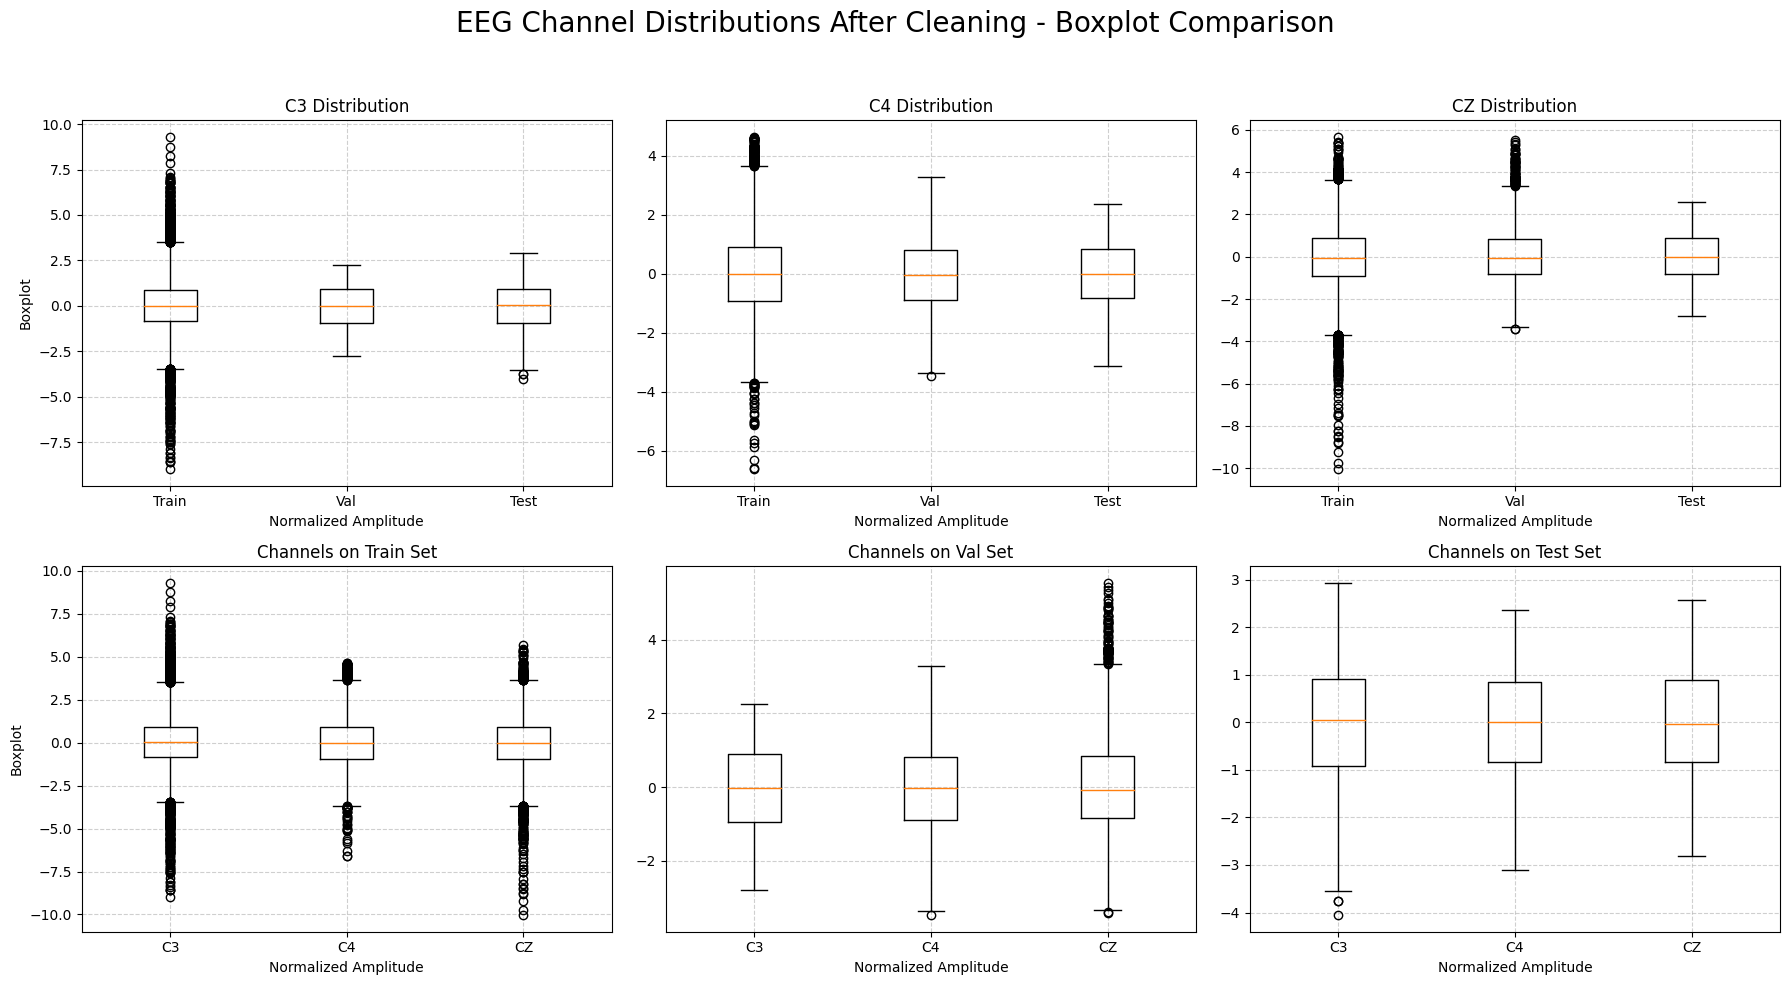

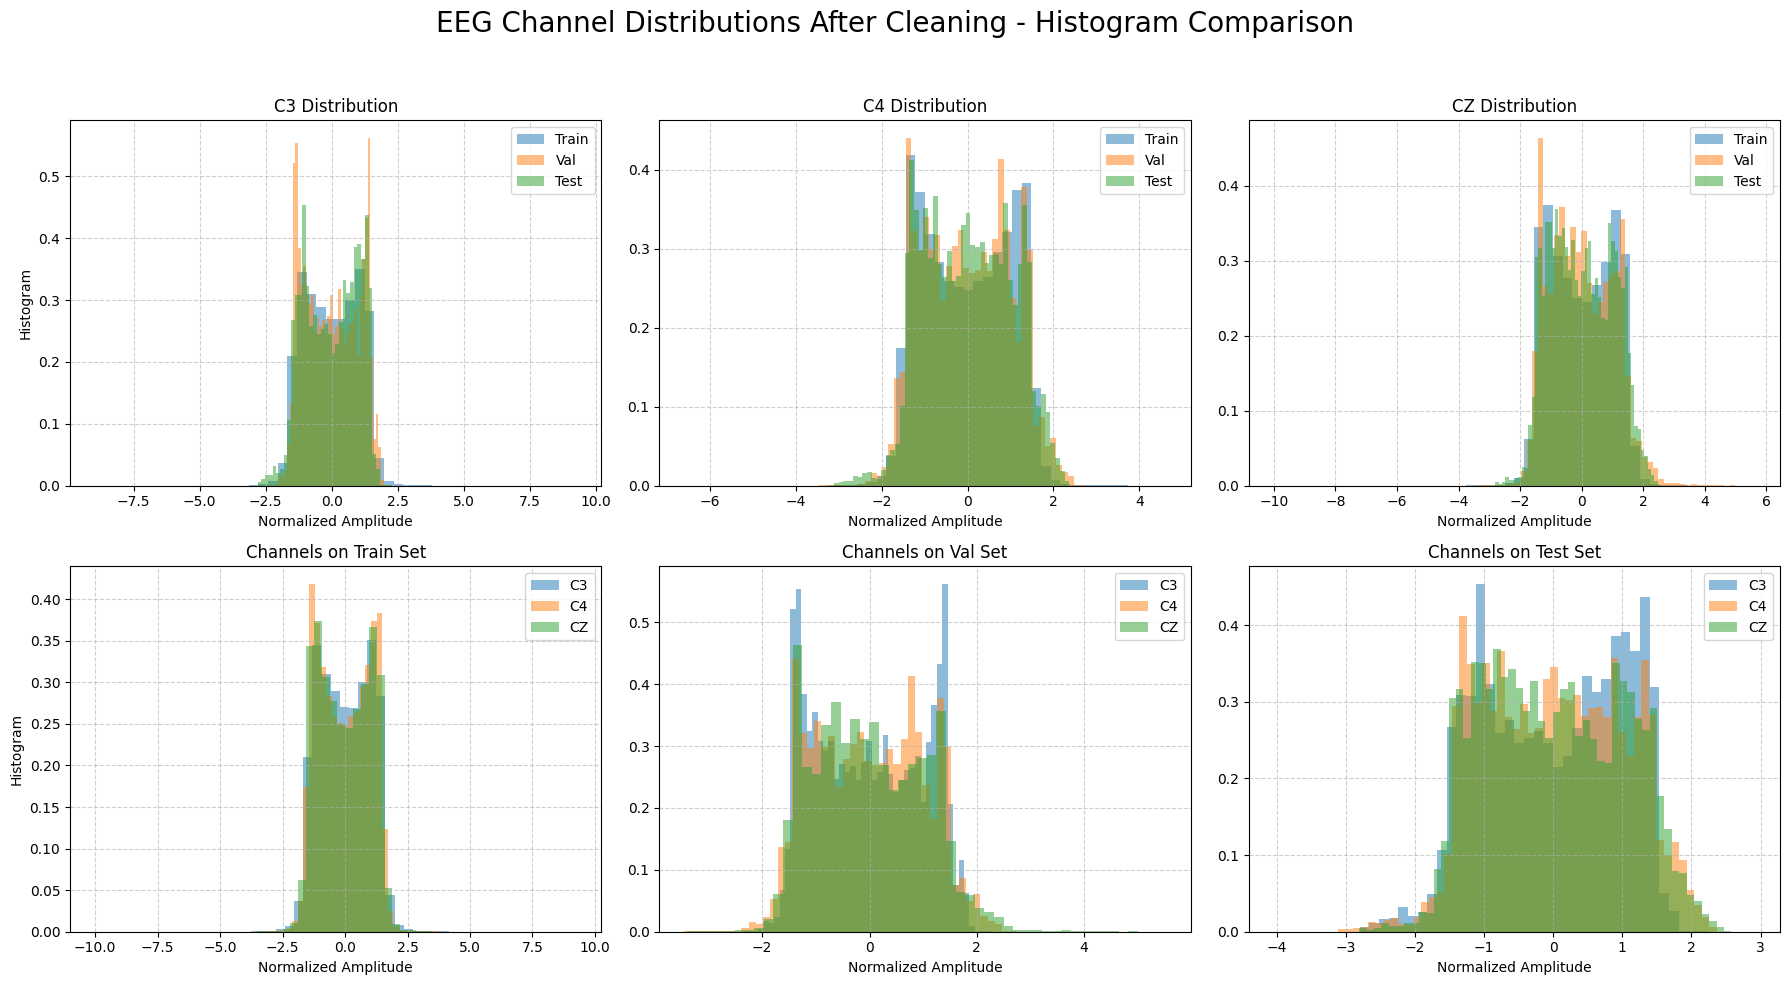

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

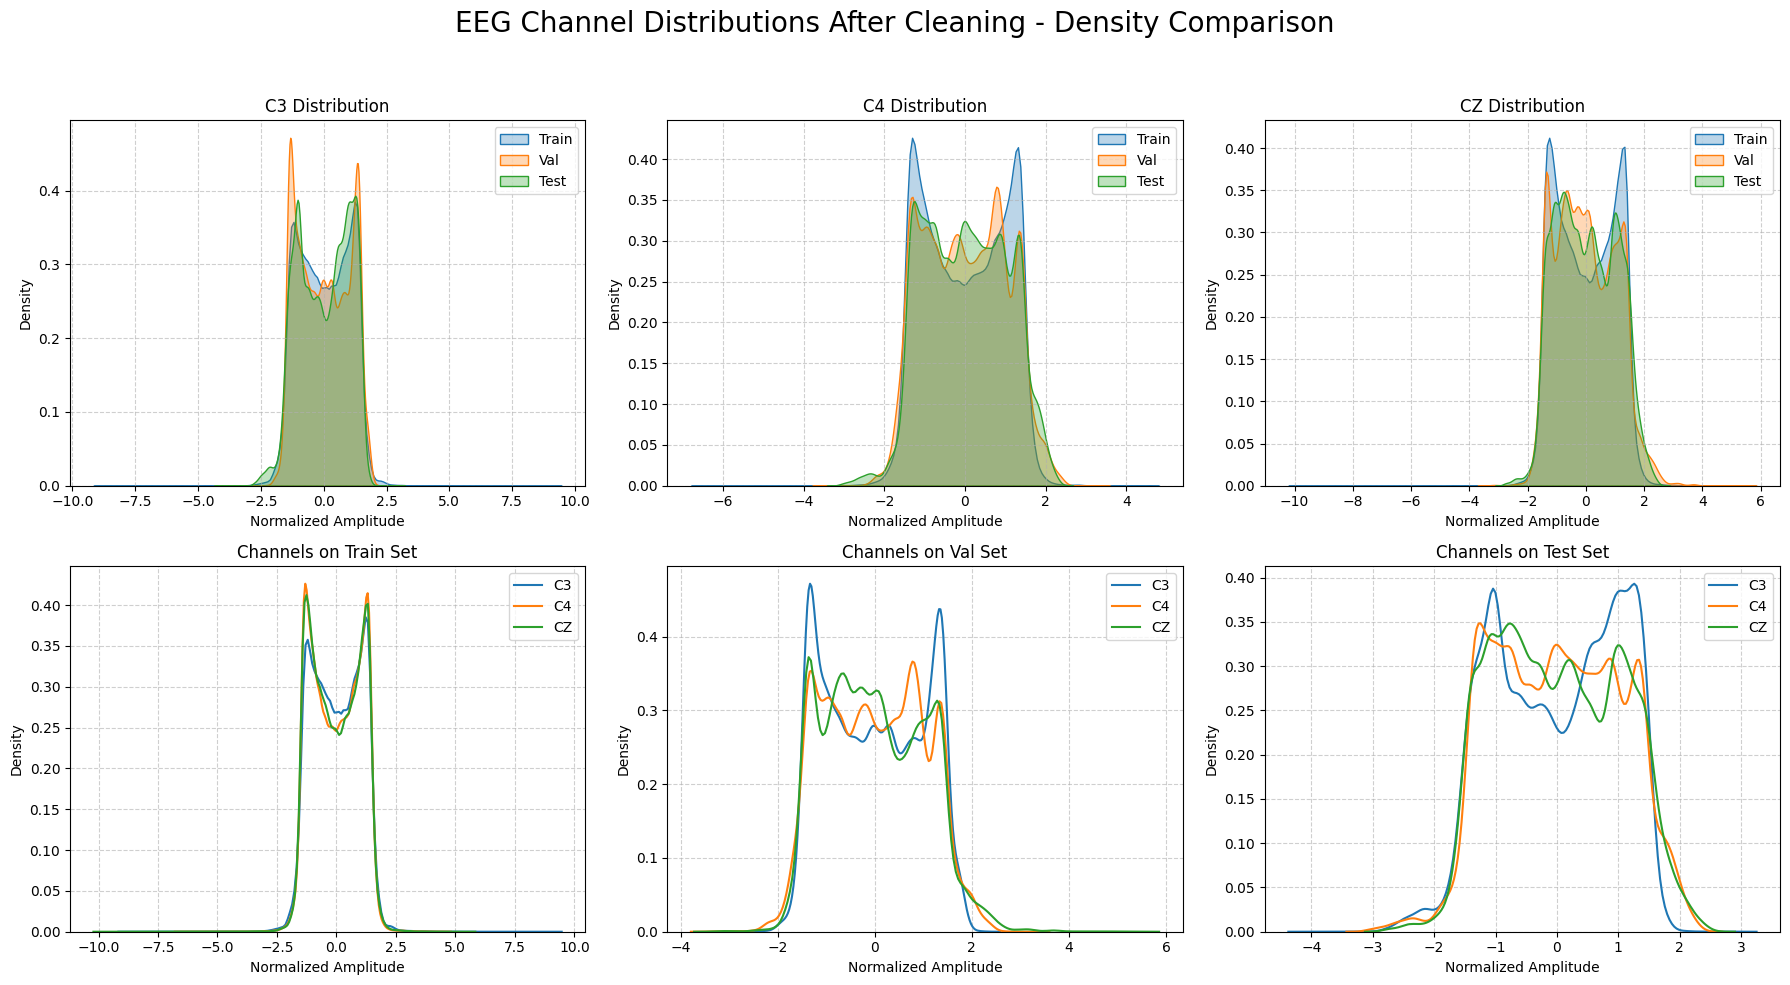


FINAL CHANNEL STATISTICS (POST-CLEANING & NORMALIZATION)

TRAIN DISTRIBUTION STATISTICS (POST-CLEANING):
| Channel   |       Mean |      Std |     Skewness |   Kurtosis |       Min |       25% |     Median |      75% |     Max |
|:----------|-----------:|---------:|-------------:|-----------:|----------:|----------:|-----------:|---------:|--------:|
| C3        |  0.0141228 | 0.994111 | -0.000617697 |  -0.755443 |  -8.98818 | -0.851838 |  0.0111788 | 0.893955 | 9.29424 |
| C4        | -0.0108658 | 0.999078 |  0.0116428   |  -1.18258  |  -6.61596 | -0.932107 | -0.011149  | 0.904644 | 4.63657 |
| CZ        | -0.0170654 | 1.00082  |  0.0169626   |  -1.07659  | -10.0381  | -0.931447 | -0.0370127 | 0.901672 | 5.66366 |

VALIDATION DISTRIBUTION STATISTICS (POST-CLEANING):
| Channel   |        Mean |      Std |   Skewness |   Kurtosis |      Min |       25% |     Median |      75% |     Max |
|:----------|------------:|---------:|-----------:|-----------:|---------:|----------:|-----------:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 33, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 33, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 16, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 16, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 16, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 8, 12, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 8, 12, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 8, 12, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 4, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 4, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 4, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 2, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 2, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 2, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          32,8

 Total params: 1,737,026 (6.63 MB)

 Trainable params: 1,735,042 (6.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.5178 - f1_score: 0.4851 - loss: 1.5369 - val_accuracy: 0.4400 - val_f1_score: 0.3149 - val_loss: 0.7001
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.5256 - f1_score: 0.5126 - loss: 0.9072 - val_accuracy: 0.4400 - val_f1_score: 0.3149 - val_loss: 0.7669
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.5505 - f1_score: 0.5381 - loss: 0.7305 - val_accuracy: 0.4400 - val_f1_score: 0.3149 - val_loss: 0.8977
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.4861 - f1_score: 0.4751 - loss: 0.7154 - val_accuracy: 0.5600 - val_f1_score: 0.3462 - val_loss: 0.6843
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.5442 - f1_score: 0.5269 - loss: 0.7245 - val_accuracy: 0.5600 - val_f1_score: 0.3462 - val_loss: 0.7421
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.5091 - f1_score: 0.4934 - loss: 0.6998 - val_accuracy: 0.5600 - val_f1_score: 0.3462

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolu

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 1500, 3, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 1500, 3, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 750, 3, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 750, 3, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 750, 3, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 375, 3, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 375, 3, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 375, 3, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 187, 3, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 71808)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │       4,595,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,689,474 (17.89 MB)

 Trainable params: 4,689,026 (17.89 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.5267 - f1_score: 0.5165 - loss: 8.1170 - val_accuracy: 0.5200 - val_f1_score: 0.5213 - val_loss: 0.9487
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5173 - f1_score: 0.5053 - loss: 1.1683 - val_accuracy: 0.5200 - val_f1_score: 0.3994 - val_loss: 0.6785
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5144 - f1_score: 0.5054 - loss: 0.9678 - val_accuracy: 0.5400 - val_f1_score: 0.4538 - val_loss: 0.7030
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.4962 - f1_score: 0.4884 - loss: 1.0366 - val_accuracy: 0.5800 - val_f1_score: 0.3978 - val_loss: 0.6776
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5029 - f1_score: 0.4968 - loss: 1.0105 - val_accuracy: 0.5800 - val_f1_score: 0.3978 - val_loss: 0.6848
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.4866 - f1_score: 0.4821 - loss: 1.0151 - val_accuracy: 0.5600 - val_f1_score: 0.3462

KeyboardInterrupt: 

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
import scipy.signal
from sklearn.metrics import classification_report, f1_score # Import for classification report and f1_score


# ==============================
# CONFIGURATION
# ==============================
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"  # Focus on Motor Imagery

# EEG and Motion Sensor channel definitions
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
TARGET_CHANNELS = ['C3', 'C4', 'CZ']  # Channels for detailed analysis
MOTION_CHANNELS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
VALIDATION_COL = 'Validation'  # Column name for validation flag

# Signal properties
SAMPLE_RATE = 250
TRIAL_DURATION = 9  # seconds for MI
SAMPLES_PER_TRIAL = SAMPLE_RATE * TRIAL_DURATION
ARTIFACT_STD_THRESHOLD = 0.3  # Threshold in standard deviations for outlier removal
TIME_WINDOW = (1, 7)  # Focus on 1-7s window
TIME_WINDOW_SAMPLES = int((TIME_WINDOW[1] - TIME_WINDOW[0]) * SAMPLE_RATE)  # 1500 samples

# Augmentation
GAUSSIAN_NOISE_STD = 0.05 # Standard deviation for Gaussian noise augmentation

# Track duplicates and interpolation (global counters)
TOTAL_DUPLICATES = 0
TOTAL_INTERPOLATED = 0
TOTAL_INVALID_ROWS = 0

# Model Training Parameters
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# ==============================
# CUSTOM F1 SCORE METRIC FOR KERAS
# ==============================

class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_f1 = self.add_weight(name='total_f1', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Convert one-hot encoded to sparse labels
        y_true_labels = tf.argmax(y_true, axis=-1)
        y_pred_labels = tf.argmax(y_pred, axis=-1)

        # Ensure tensors have known shapes for tf.py_function
        # Reshape to 1D to match what sklearn's f1_score typically expects
        y_true_labels = tf.reshape(y_true_labels, [-1])
        y_pred_labels = tf.reshape(y_pred_labels, [-1])

        # Compute F1 score per batch (macro average)
        # FIX: Use .numpy() to pass arrays to sklearn and zero_division=0 for safety.
        f1 = tf.py_function(lambda yt, yp: f1_score(yt.numpy(), yp.numpy(), average='macro', zero_division=0),
                            inp=[y_true_labels, y_pred_labels],
                            Tout=tf.float32)
        
        # FIX: Explicitly set the shape of the output tensor from tf.py_function.
        # This resolves the "ValueError: as_list() is not defined on an unknown TensorShape".
        f1.set_shape(())

        self.total_f1.assign_add(f1)
        self.count.assign_add(1.0)

    def result(self):
        # FIX: Use safe division to handle the case where count is 0.
        return tf.math.divide_no_nan(self.total_f1, self.count)

    def reset_state(self):
        self.total_f1.assign(0.0)
        self.count.assign(0.0)


# ==============================
# DATA LOADING (HELPER)
# ==============================

def load_single_trial(row, dataset_type, base_path, time_window=None):
    """Loads raw data with time window selection, handles duplicates, and interpolates invalid values"""
    global TOTAL_DUPLICATES, TOTAL_INTERPOLATED, TOTAL_INVALID_ROWS
    
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset_type,
        row['subject_id'],
        str(row['trial_session']),
        "EEGdata.csv"
    )
    if not os.path.exists(eeg_path):
        return None, 0, 0, 0

    # Load data and handle duplicates
    eeg_data = pd.read_csv(eeg_path)
    
    # Handle cross-session duplicates using composite key
    duplicate_mask = eeg_data.duplicated()
    duplicates_removed = duplicate_mask.sum()
    eeg_data = eeg_data[~duplicate_mask]
    
    # Handle invalid rows marked by Validation column
    invalid_mask = eeg_data.get(VALIDATION_COL, pd.Series(False, index=eeg_data.index)) == 0.0
    invalid_count = invalid_mask.sum()
    
    # Replace invalid EEG values with NaN
    eeg_data.loc[invalid_mask, EEG_CHANNELS] = np.nan
    
    # Replace infinite values with NaN
    eeg_data[EEG_CHANNELS] = eeg_data[EEG_CHANNELS].replace([np.inf, -np.inf], np.nan)
    
    # Count NaNs before interpolation
    nan_count_before = eeg_data[EEG_CHANNELS].isna().sum().sum()
    
    # Interpolate missing values
    eeg_data[EEG_CHANNELS] = eeg_data[EEG_CHANNELS].interpolate(
        method='linear', 
        axis=0, 
        limit_direction='both'
    )
    
    nan_count_after = eeg_data[EEG_CHANNELS].isna().sum().sum()
    interpolated_count = nan_count_before - nan_count_after
    
    # Update global counters (these counters accumulate across all calls, which is intended here)
    TOTAL_DUPLICATES += duplicates_removed
    TOTAL_INTERPOLATED += interpolated_count
    TOTAL_INVALID_ROWS += invalid_count
    
    # Extract trial
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    trial_data = eeg_data.iloc[start_idx:end_idx]
    
    # Apply time window if specified
    if time_window:
        start_sample = int(time_window[0] * SAMPLE_RATE)
        end_sample = int(time_window[1] * SAMPLE_RATE)
        trial_data = trial_data.iloc[start_sample:end_sample]
        
    return trial_data, duplicates_removed, interpolated_count, invalid_count

# ==============================
# ARTIFACT DETECTION & THRESHOLD CALCULATION (PASS 1)
# ==============================

def calculate_artifact_thresholds(df, base_path):
    """Analyzes training trials to compute metrics and determine outlier thresholds"""
    print("Pass 1: Analyzing training data to calculate artifact thresholds...")
    metrics = []
    
    # Use only the MI task data from the training set
    mi_df = df[df['task'] == TASK].copy()

    # Reset local counters for this function call to avoid double counting with global
    local_duplicates = 0
    local_interpolated = 0
    local_invalid = 0

    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc="Calculating thresholds"):
        trial_data, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
            row, 'train', base_path
        )
        if trial_data is None or trial_data.empty:
            continue
            
        local_duplicates += duplicates_removed
        local_interpolated += interpolated_count
        local_invalid += invalid_count

        # 1. Motion metrics
        motion_std = trial_data[MOTION_CHANNELS].std().sum()

        # 2. Amplitude and Variance metrics for EEG
        eeg_data = trial_data[EEG_CHANNELS]
        max_abs_amplitude = eeg_data.abs().max().max()
        eeg_variance = eeg_data.var().mean()

        metrics.append({
            'id': row['id'],
            'motion_std': motion_std,
            'max_abs_amplitude': max_abs_amplitude,
            'eeg_variance': eeg_variance
        })

    metrics_df = pd.DataFrame(metrics)
    
    # Calculate thresholds using the 3-sigma rule
    thresholds = {
        'motion_std_thresh': metrics_df['motion_std'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['motion_std'].std(),
        'max_abs_amp_thresh': metrics_df['max_abs_amplitude'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['max_abs_amplitude'].std(),
        'eeg_var_upper_thresh': metrics_df['eeg_variance'].mean() + ARTIFACT_STD_THRESHOLD * metrics_df['eeg_variance'].std(),
        'eeg_var_lower_thresh': metrics_df['eeg_variance'].mean() - ARTIFACT_STD_THRESHOLD * metrics_df['eeg_variance'].std()
    }

    print("\nCalculated Artifact Thresholds:")
    for key, val in thresholds.items():
        print(f"  - {key}: {val:.4f}")
    
    print("\nData Validation Stats (Pass 1 - Training data only):")
    print(f"  - Duplicates removed (this pass): {local_duplicates}")
    print(f"  - Values interpolated (this pass): {local_interpolated}")
    print(f"  - Invalid rows handled (this pass): {local_invalid}")
        
    return thresholds, metrics_df

# ==============================
# DATA CLEANING AND FILTERING (PASS 2)
# ==============================

def get_clean_trials(df, dataset_type, base_path, thresholds):
    """Filters training data, keeps all validation/test"""
    # Reset local counters for this function call
    local_duplicates = 0
    local_interpolated = 0
    local_invalid = 0
    
    if dataset_type == 'train':
        # Original filtering logic for training set
        mi_df = df[df['task'] == TASK].copy()
        clean_ids = []
        
        for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc=f"Filtering {dataset_type}"):
            # Load full trial (0-9s) for artifact detection
            trial_data, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
                row, dataset_type, base_path
            )
            if trial_data is None or trial_data.empty:
                continue
                
            local_duplicates += duplicates_removed
            local_interpolated += interpolated_count
            local_invalid += invalid_count
                
            motion_std = trial_data[MOTION_CHANNELS].std().sum()
            max_abs_amplitude = trial_data[EEG_CHANNELS].abs().max().max()
            eeg_variance = trial_data[EEG_CHANNELS].var().mean()
            
            if (motion_std < thresholds['motion_std_thresh'] and
                max_abs_amplitude < thresholds['max_abs_amp_thresh'] and
                thresholds['eeg_var_lower_thresh'] < eeg_variance < thresholds['eeg_var_upper_thresh']):
                clean_ids.append(row['id'])
                
        clean_df = df[df['id'].isin(clean_ids)].copy()
        print(f"Training: Kept {len(clean_df)}/{len(mi_df)} trials after filtering")
    else:
        # Process all data for validation/test sets without filtering
        clean_df = df[df['task'] == TASK].copy()
        print(f"Processing all {dataset_type} trials (no filtering)")
        
        # Still need to load data to process duplicates and interpolation for these sets
        for _, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc=f"Processing {dataset_type}"):
            _, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
                row, dataset_type, base_path
            )
            local_duplicates += duplicates_removed
            local_interpolated += interpolated_count
            local_invalid += invalid_count
            
    print(f"\nData Validation Stats ({dataset_type.capitalize()}):")
    print(f"  - Duplicates removed (this pass): {local_duplicates}")
    print(f"  - Values interpolated (this pass): {local_interpolated}")
    print(f"  - Invalid rows handled (this pass): {local_invalid}")
    
    return clean_df

# ==============================
# NORMALIZATION & FINAL DATA PREPARATION
# ==============================

def load_normalized_clean_data(clean_df, dataset_type, base_path, apply_augmentation=False):
    """Loads, normalizes, and optionally augments 1-7s data for clean trials"""
    print(f"\nLoading and normalizing 1-7s data for '{dataset_type}'...")
    all_trial_data = []
    all_labels = [] # For MI task, labels will be 'Left' or 'Right'
    all_ids = [] # For test set to generate submission

    grouped = clean_df.groupby(['subject_id', 'trial_session'])
    
    for (subject, session), group in tqdm(grouped, desc=f"Normalizing {dataset_type}"):
        session_path = os.path.join(base_path, TASK, dataset_type, subject, str(session), "EEGdata.csv")
        if not os.path.exists(session_path):
            continue
            
        # Load session data with comprehensive cleaning
        session_data = pd.read_csv(session_path)
        
        # Handle duplicates
        session_data = session_data.drop_duplicates()
        
        # Handle invalid rows
        invalid_mask = session_data.get(VALIDATION_COL, pd.Series(False, index=session_data.index)) == 0.0
        session_data.loc[invalid_mask, EEG_CHANNELS] = np.nan
        
        # Handle infinite values
        session_data[EEG_CHANNELS] = session_data[EEG_CHANNELS].replace([np.inf, -np.inf], np.nan)
        
        # Interpolate
        session_data[EEG_CHANNELS] = session_data[EEG_CHANNELS].interpolate(
            method='linear', 
            axis=0, 
            limit_direction='both'
        )
        
        # Session-level normalization
        session_means = session_data[EEG_CHANNELS].mean()
        session_stds = session_data[EEG_CHANNELS].std()

        for _, row in group.iterrows():
            # Extract 1-7s segment
            trial_num = int(row['trial'])
            start_idx = (trial_num - 1) * SAMPLES_PER_TRIAL
            end_idx = start_idx + SAMPLES_PER_TRIAL
            trial_data_full = session_data.iloc[start_idx:end_idx]
            
            # Apply time window
            start_sample = int(TIME_WINDOW[0] * SAMPLE_RATE)
            end_sample = int(TIME_WINDOW[1] * SAMPLE_RATE)
            trial_data = trial_data_full.iloc[start_sample:end_sample]

            # Normalize selected EEG channels
            normalized_trial = (trial_data[TARGET_CHANNELS] - session_means[TARGET_CHANNELS]) / (session_stds[TARGET_CHANNELS] + 1e-8)
            
            # Apply Gaussian augmentation if specified and not for test set
            if apply_augmentation and dataset_type == 'train':
                normalized_trial = add_gaussian_noise(normalized_trial, GAUSSIAN_NOISE_STD)

            all_trial_data.append(normalized_trial.values)
            if 'label' in row:
                all_labels.append(row['label'])
            all_ids.append(row['id'])
                
    return np.array(all_trial_data), np.array(all_labels), np.array(all_ids)

# ==============================
# DATA AUGMENTATION
# ==============================
def add_gaussian_noise(data, noise_std):
    """Adds Gaussian noise to the data."""
    return data + np.random.normal(0, noise_std, data.shape)

# ==============================
# MODEL 1: STFT/CWT -> CNN
# ==============================
def create_model_stft_cnn(input_shape, num_classes):
    model = models.Sequential()
    # Input is (freq_bins, time_frames, num_channels)
    
    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    
    # FC Layer 1
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5)) # Added Dropout for regularization
    
    # FC Layer 2
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # FC Layer 3 (Output Layer)
    model.add(layers.Dense(num_classes, activation='softmax')) # Output is softmax

    return model

def create_stft_input(data, nperseg=64, noverlap=32):
    """
    Generates STFT spectrograms for each channel and stacks them.
    Input data shape: (num_trials, time_samples, num_channels)
    Output shape: (num_trials, freq_bins, time_frames, num_channels)
    """
    spectrograms = []
    # FIX: Handle case with no trials to prevent errors after filtering
    if data.shape[0] == 0: 
        dummy_f, dummy_t, dummy_Zxx = scipy.signal.stft(np.zeros(TIME_WINDOW_SAMPLES), fs=SAMPLE_RATE, nperseg=nperseg, noverlap=noverlap)
        freq_bins = dummy_Zxx.shape[0]
        time_frames = dummy_Zxx.shape[1]
        num_channels = data.shape[2] 
        return np.empty((0, freq_bins, time_frames, num_channels), dtype=np.float32)
        
    for i in range(data.shape[0]): # Iterate through trials
        trial_spectrograms = []
        for j in range(data.shape[2]): # Iterate through channels
            # Compute STFT for each channel
            f, t, Zxx = scipy.signal.stft(data[i, :, j], fs=SAMPLE_RATE, nperseg=nperseg, noverlap=noverlap)
            trial_spectrograms.append(np.abs(Zxx)) # Use magnitude spectrogram
        spectrograms.append(np.stack(trial_spectrograms, axis=-1)) # Stack channels as last dim
    return np.array(spectrograms)

# ==============================
# MODEL 2: 2D Raw matrix -> CNN
# ==============================
def create_model_raw_cnn(input_shape, num_classes):
    # Input shape: (time_samples, num_channels, 1)
    model = models.Sequential()
    
    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    # Pool along the time dimension (first dim of the spatial part)
    # The channel dimension (second dim of the spatial part) is 3, so a (2,2) pool will shrink it.
    # To avoid reducing a dimension to 0 or negative, we can ensure the pooling only happens on the time axis.
    model.add(layers.MaxPooling2D((2, 1))) 
    
    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    
    model.add(layers.Flatten())
    
    # FC Layer 1
    model.add(layers.Dense(64, activation='elu')) 
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# ==============================
# MODEL 3: CSP features -> Multi-layer CNN
# ==============================
def create_model_csp_cnn(input_shape, num_classes):
    # Input shape: (num_csp_components, time_samples, 1)
    # Pool along the time dimension (second dim of the spatial part).
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (1, 3), activation='elu', input_shape=input_shape, padding='same')) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2))) 
    
    # Conv Block 2
    model.add(layers.Conv2D(64, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 4
    model.add(layers.Conv2D(256, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 5
    model.add(layers.Conv2D(512, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 6
    model.add(layers.Conv2D(1024, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 7
    model.add(layers.Conv2D(2048, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    
    model.add(layers.Flatten())
    
    # FC Layer 1
    model.add(layers.Dense(256, activation='elu'))
    model.add(layers.Dropout(0.5))

    # FC Layer 2
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dropout(0.5))

    # FC Layer 3 (Output Layer)
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# ==============================
# VISUALIZATION (UNCHANGED)
# ==============================

def create_plots(data_dict, plot_type, title_prefix):
    """Creates boxplots, histograms, or density plots for all channels and datasets"""
    
    # Filter out empty lists from the dictionary for plotting
    plot_data_dict = {}
    for ds_key, channel_dict in data_dict.items():
        plot_data_dict[ds_key] = {ch: vals for ch, vals in channel_dict.items() if vals}
    
    if not any(plot_data_dict['train'].values()):
        print(f"Skipping {plot_type} plots for '{title_prefix}' as there is no training data to plot.")
        return
        
    plt.figure(figsize=(18, 10))
    
    # Plotting by channel across datasets (top row)
    for i, channel in enumerate(TARGET_CHANNELS):
        ax = plt.subplot(2, 3, i + 1)
        
        plot_datasets = []
        plot_labels = []
        for ds in ['train', 'val', 'test']:
            if channel in plot_data_dict[ds] and plot_data_dict[ds][channel]:
                plot_datasets.append(plot_data_dict[ds][channel])
                plot_labels.append(ds.capitalize())

        if plot_datasets:
            if plot_type == 'boxplot':
                ax.boxplot(plot_datasets, labels=plot_labels)
            elif plot_type == 'density':
                for j, ds_data in enumerate(plot_datasets):
                    sns.kdeplot(ds_data, label=plot_labels[j], fill=True, alpha=0.3, ax=ax)
                ax.legend()
            elif plot_type == 'histogram':
                for j, ds_data in enumerate(plot_datasets):
                    ax.hist(ds_data, bins=50, density=True, alpha=0.5, label=plot_labels[j])
                ax.legend()
        
        ax.set_title(f'{channel} Distribution')
        ax.set_xlabel('Normalized Amplitude')
        if i == 0: # Only set ylabel for the first plot in the row
            ax.set_ylabel(plot_type.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)

    # Plotting by dataset across channels (bottom row)
    for i, ds in enumerate(['train', 'val', 'test']):
        ax = plt.subplot(2, 3, i + 4)
        
        channel_plot_data = [plot_data_dict[ds][ch] for ch in TARGET_CHANNELS if ch in plot_data_dict[ds] and plot_data_dict[ds][ch]]
        labels = [ch for ch in TARGET_CHANNELS if ch in plot_data_dict[ds] and plot_data_dict[ds][ch]]

        if channel_plot_data:
            if plot_type == 'boxplot':
                ax.boxplot(channel_plot_data, labels=labels)
            else: # For histogram and density, we overlay
                for j, ch_data in enumerate(channel_plot_data):
                    if plot_type == 'histogram':
                        ax.hist(ch_data, bins=50, density=True, alpha=0.5, label=labels[j])
                    elif plot_type == 'density':
                        sns.kdeplot(ch_data, label=labels[j], ax=ax)
                ax.legend()
        
        ax.set_title(f'Channels on {ds.capitalize()} Set')
        ax.set_xlabel('Normalized Amplitude')
        if i == 0: # Only set ylabel for the first plot in the row
            ax.set_ylabel(plot_type.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(f'{title_prefix} - {plot_type.capitalize()} Comparison', fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ==============================
# STATISTICS (UNCHANGED)
# ==============================

def print_distribution_stats(data, name):
    """Prints detailed distribution statistics for a given dataset"""
    # Check if data for any channel exists before proceeding
    if not any(data.values()):
        print(f"\nNo data to display for {name.upper()} statistics.")
        return
        
    print(f"\n{name.upper()} DISTRIBUTION STATISTICS (POST-CLEANING):")
    stats_data = []
    for channel in TARGET_CHANNELS:
        if not data[channel]: continue # Skip if channel has no data
        channel_stats = {
            'Channel': channel,
            'Mean': np.mean(data[channel]),
            'Std': np.std(data[channel]),
            'Skewness': stats.skew(data[channel]),
            'Kurtosis': stats.kurtosis(data[channel]),
            'Min': np.min(data[channel]),
            '25%': np.percentile(data[channel], 25),
            'Median': np.median(data[channel]),
            '75%': np.percentile(data[channel], 75),
            'Max': np.max(data[channel])
        }
        stats_data.append(channel_stats)
    
    if stats_data:
        stats_df = pd.DataFrame(stats_data)
        print(stats_df.to_markdown(index=False))

# ==============================
# MAIN EXECUTION
# ==============================

if __name__ == "__main__":
    # Load data indices
    train_df_full = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df_full = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df_full = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Reset global counters before data loading
    TOTAL_DUPLICATES = 0
    TOTAL_INTERPOLATED = 0
    TOTAL_INVALID_ROWS = 0

    # --- Pass 1: Calculate thresholds from training data ---
    artifact_thresholds, _ = calculate_artifact_thresholds(train_df_full, BASE_PATH)

    # --- Pass 2: Filter all datasets using these thresholds ---
    train_df_clean = get_clean_trials(train_df_full, 'train', BASE_PATH, artifact_thresholds)
    validation_df_clean = get_clean_trials(validation_df_full, 'validation', BASE_PATH, artifact_thresholds)
    test_df_clean = get_clean_trials(test_df_full, 'test', BASE_PATH, artifact_thresholds)

    # Print global data validation stats
    print("\n" + "="*60)
    print("GLOBAL DATA VALIDATION SUMMARY")
    print("="*60)
    print(f"Total duplicates removed across all passes: {TOTAL_DUPLICATES}")
    print(f"Total values interpolated across all passes: {TOTAL_INTERPOLATED}")
    print(f"Total invalid rows handled across all passes: {TOTAL_INVALID_ROWS}")

    # --- Load, normalize, and process the final clean data ---
    # Apply augmentation only to training data
    X_train, y_train_labels, _ = load_normalized_clean_data(train_df_clean, 'train', BASE_PATH, apply_augmentation=True)
    X_val, y_val_labels, _ = load_normalized_clean_data(validation_df_clean, 'validation', BASE_PATH, apply_augmentation=False)
    X_test, _, test_ids = load_normalized_clean_data(test_df_clean, 'test', BASE_PATH, apply_augmentation=False)

    # Combine data for visualization (before one-hot encoding labels)
    # Reconstruct dictionary for visualization based on loaded numpy arrays
    train_data_vis = {ch: [] for ch in TARGET_CHANNELS}
    if X_train.size > 0:
        for i, ch in enumerate(TARGET_CHANNELS):
            train_data_vis[ch].extend(X_train[:, :, i].flatten())

    val_data_vis = {ch: [] for ch in TARGET_CHANNELS}
    if X_val.size > 0:
        for i, ch in enumerate(TARGET_CHANNELS):
            val_data_vis[ch].extend(X_val[:, :, i].flatten())

    test_data_vis = {ch: [] for ch in TARGET_CHANNELS}
    if X_test.size > 0:
        for i, ch in enumerate(TARGET_CHANNELS):
            test_data_vis[ch].extend(X_test[:, :, i].flatten())

    all_clean_data_for_vis = {
        'train': train_data_vis,
        'val': val_data_vis,
        'test': test_data_vis
    }

    # --- Generate Visualizations on Cleaned Data ---
    print("\nGenerating plots for the cleaned and normalized data...")
    create_plots(all_clean_data_for_vis, 'boxplot', 'EEG Channel Distributions After Cleaning')
    create_plots(all_clean_data_for_vis, 'histogram', 'EEG Channel Distributions After Cleaning')
    create_plots(all_clean_data_for_vis, 'density', 'EEG Channel Distributions After Cleaning')

    # --- Print Final Statistics on Cleaned Data ---
    print("\n" + "="*60)
    print("FINAL CHANNEL STATISTICS (POST-CLEANING & NORMALIZATION)")
    print("="*60)
    print_distribution_stats(train_data_vis, "Train")
    print_distribution_stats(val_data_vis, "Validation")
    print_distribution_stats(test_data_vis, "Test")


    # --- Prepare labels for model training ---
    # FIX: Add a check to ensure training data exists before proceeding.
    if len(y_train_labels) == 0:
        print("\nNo training data left after cleaning. Cannot proceed with model training.")
        # Create empty submission files to prevent further errors in automated systems
        pd.DataFrame({'id': test_ids, 'label': ['NoPrediction'] * len(test_ids)}).to_csv('submission_model1_stft_cnn.csv', index=False)
        pd.DataFrame({'id': test_ids, 'label': ['NoPrediction'] * len(test_ids)}).to_csv('submission_model2_raw_cnn.csv', index=False)
        pd.DataFrame({'id': test_ids, 'label': ['NoPrediction'] * len(test_ids)}).to_csv('submission_model3_csp_cnn.csv', index=False)
        exit()

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_labels)
    y_val_encoded = label_encoder.transform(y_val_labels)
    num_classes = len(label_encoder.classes_)
    class_names = list(label_encoder.classes_) # Store class names for classification report
    print(f"\nEncoded classes: {class_names}")

    # Convert to one-hot encoding for Keras
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
    y_val_one_hot = tf.keras.utils.to_categorical(y_val_encoded, num_classes)

    # Reshape for CNN inputs: (batch_size, time_samples, num_channels, 1)
    # The last dimension '1' is for the single feature (e.g., amplitude) per channel.
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


    # ==================================
    # Model 1: STFT/CWT -> CNN
    # ==================================
    print("\n" + "="*60)
    print("TRAINING MODEL 1: STFT/CWT -> CNN")
    print("="*60)

    # Generate STFT input
    # X_train_reshaped[:,:,:,0] selects (num_trials, time_samples, num_channels)
    X_train_stft = create_stft_input(X_train_reshaped[:,:,:,0]) 
    X_val_stft = create_stft_input(X_val_reshaped[:,:,:,0])
    X_test_stft = create_stft_input(X_test_reshaped[:,:,:,0])

    stft_input_shape = X_train_stft.shape[1:] # (freq_bins, time_frames, num_channels)
    model1 = create_model_stft_cnn(stft_input_shape, num_classes)
    # FIX: Added run_eagerly=True to prevent potential XLA/py_function conflicts.
    model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', F1ScoreMetric()],
                   run_eagerly=True)
    model1.summary()

    history1 = model1.fit(X_train_stft, y_train_one_hot,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_stft, y_val_one_hot),
                          verbose=1)
    
    # Evaluate Model 1
    print("\n--- Model 1 Evaluation on Validation Set ---")
    val_predictions1 = model1.predict(X_val_stft)
    val_predicted_labels1 = np.argmax(val_predictions1, axis=1)
    print(classification_report(y_val_encoded, val_predicted_labels1, target_names=class_names))

    # Predict and save submission for Model 1
    predictions1 = model1.predict(X_test_stft)
    predicted_labels1 = label_encoder.inverse_transform(np.argmax(predictions1, axis=1))
    
    submission_df1 = pd.DataFrame({'id': test_ids, 'label': predicted_labels1})
    submission_df1.to_csv('submission_model1_stft_cnn.csv', index=False)
    print("Submission file for Model 1 created: submission_model1_stft_cnn.csv")


    # ==================================
    # Model 2: 2D Raw matrix -> CNN
    # ==================================
    print("\n" + "="*60)
    print("TRAINING MODEL 2: 2D Raw matrix -> CNN")
    print("="*60)

    raw_input_shape = X_train_reshaped.shape[1:] # (time_samples, num_channels, 1)
    model2 = create_model_raw_cnn(raw_input_shape, num_classes)
    # FIX: Added run_eagerly=True.
    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', F1ScoreMetric()],
                   run_eagerly=True)
    model2.summary()

    history2 = model2.fit(X_train_reshaped, y_train_one_hot,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_reshaped, y_val_one_hot),
                          verbose=1)

    # Evaluate Model 2
    print("\n--- Model 2 Evaluation on Validation Set ---")
    val_predictions2 = model2.predict(X_val_reshaped)
    val_predicted_labels2 = np.argmax(val_predictions2, axis=1)
    print(classification_report(y_val_encoded, val_predicted_labels2, target_names=class_names))

    # Predict and save submission for Model 2
    predictions2 = model2.predict(X_test_reshaped)
    predicted_labels2 = label_encoder.inverse_transform(np.argmax(predictions2, axis=1))
    
    submission_df2 = pd.DataFrame({'id': test_ids, 'label': predicted_labels2})
    submission_df2.to_csv('submission_model2_raw_cnn.csv', index=False)
    print("Submission file for Model 2 created: submission_model2_raw_cnn.csv")


    # ==================================
    # Model 3: CSP features -> Multi-layer CNN
    # ==================================
    print("\n" + "="*60)
    print("TRAINING MODEL 3: CSP features -> Multi-layer CNN")
    print("="*60)

    # CSP expects data in (n_trials, n_channels, n_times)
    # Our data is currently (n_trials, n_times, n_channels, 1) so we need to permute
    X_train_csp_input = X_train.transpose(0, 2, 1) # (n_trials, n_channels, n_times)
    X_val_csp_input = X_val.transpose(0, 2, 1)
    X_test_csp_input = X_test.transpose(0, 2, 1)
    
    # Initialize CSP
    n_components_csp = 4 # Common choice for 2 classes
    
    csp = CSP(n_components=n_components_csp, reg=None, log=True, cov_method='empirical')
    
    # Fit and transform training data
    X_train_csp_features = csp.fit_transform(X_train_csp_input, y_train_encoded)
    X_val_csp_features = csp.transform(X_val_csp_input)
    X_test_csp_features = csp.transform(X_test_csp_input)

    # Apply CSP filters to get spatially filtered time series
    csp_filters = csp.filters_
    
    # This step is critical: Project raw EEG onto CSP filters
    # Resulting shape: (num_trials, n_components_csp, time_samples)
    X_train_csp_ts = np.array([np.dot(csp_filters, trial) for trial in X_train_csp_input])
    X_val_csp_ts = np.array([np.dot(csp_filters, trial) for trial in X_val_csp_input])
    X_test_csp_ts = np.array([np.dot(csp_filters, trial) for trial in X_test_csp_input])

    # Reshape for CNN: (num_trials, num_csp_components, time_samples, 1)
    # The last dimension '1' is for the single feature (e.g., amplitude) per CSP component.
    X_train_csp_ts_reshaped = X_train_csp_ts.reshape(X_train_csp_ts.shape[0], X_train_csp_ts.shape[1], X_train_csp_ts.shape[2], 1)
    X_val_csp_ts_reshaped = X_val_csp_ts.reshape(X_val_csp_ts.shape[0], X_val_csp_ts.shape[1], X_val_csp_ts.shape[2], 1)
    X_test_csp_ts_reshaped = X_test_csp_ts.reshape(X_test_csp_ts.shape[0], X_test_csp_ts.shape[1], X_test_csp_ts.shape[2], 1)


    csp_input_shape = X_train_csp_ts_reshaped.shape[1:] # (num_csp_components, time_samples, 1)
    model3 = create_model_csp_cnn(csp_input_shape, num_classes)
    # FIX: Added run_eagerly=True.
    model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', F1ScoreMetric()],
                   run_eagerly=True)
    model3.summary()

    history3 = model3.fit(X_train_csp_ts_reshaped, y_train_one_hot,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_csp_ts_reshaped, y_val_one_hot),
                          verbose=1)

    # Evaluate Model 3
    print("\n--- Model 3 Evaluation on Validation Set ---")
    val_predictions3 = model3.predict(X_val_csp_ts_reshaped)
    val_predicted_labels3 = np.argmax(val_predictions3, axis=1)
    print(classification_report(y_val_encoded, val_predicted_labels3, target_names=class_names))

    # Predict and save submission for Model 3
    predictions3 = model3.predict(X_test_csp_ts_reshaped)
    predicted_labels3 = label_encoder.inverse_transform(np.argmax(predictions3, axis=1))
    
    submission_df3 = pd.DataFrame({'id': test_ids, 'label': predicted_labels3})
    submission_df3.to_csv('submission_model3_csp_cnn.csv', index=False)
    print("Submission file for Model 3 created: submission_model3_csp_cnn.csv")

    print("\nTraining and prediction for all models complete!")
    print("Check the submission files: submission_model1_stft_cnn.csv, submission_model2_raw_cnn.csv, submission_model3_csp_cnn.csv")

Pass 1: Analyzing validation data to calculate artifact thresholds...


Calculating thresholds from validation: 100%|██████████| 50/50 [00:04<00:00, 10.05it/s]



Calculated Artifact Thresholds:
  (based on validation data)
  - motion_std_thresh_upper: 7.1807
  - max_abs_amp_q1: 309488.4766
  - max_abs_amp_q3: 371154.7578
  - eeg_var_q1: 32251.6579
  - eeg_var_q3: 50416408.6776

Data Validation Stats (Pass 1 - validation data used for thresholds):
  - Duplicates removed (this pass): 0
  - Values interpolated (this pass): 397360
  - Invalid rows handled (this pass): 49670


Filtering train: 100%|██████████| 2400/2400 [04:01<00:00,  9.95it/s]


Training: Kept 1291/2400 trials after filtering

Data Validation Stats (Train):
  - Duplicates removed (this pass): 0
  - Values interpolated (this pass): 9162480
  - Invalid rows handled (this pass): 1145310
Processing all validation trials (no threshold-based filtering)


Processing validation: 100%|██████████| 50/50 [00:04<00:00, 10.07it/s]



Data Validation Stats (Validation):
  - Duplicates removed (this pass): 0
  - Values interpolated (this pass): 397360
  - Invalid rows handled (this pass): 49670
Processing all test trials (no threshold-based filtering)


Processing test: 100%|██████████| 50/50 [00:04<00:00, 10.06it/s]



Data Validation Stats (Test):
  - Duplicates removed (this pass): 0
  - Values interpolated (this pass): 341520
  - Invalid rows handled (this pass): 42690

GLOBAL DATA VALIDATION SUMMARY
Total duplicates removed across all passes: 0
Total values interpolated across all passes: 10298720
Total invalid rows handled across all passes: 1287340

Loading and normalizing 1-7s data for 'train'...


Normalizing train: 100%|██████████| 149/149 [00:17<00:00,  8.59it/s]



Loading and normalizing 1-7s data for 'validation'...


Normalizing validation: 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]



Loading and normalizing 1-7s data for 'test'...


Normalizing test: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]



Generating plots for the cleaned and normalized data...


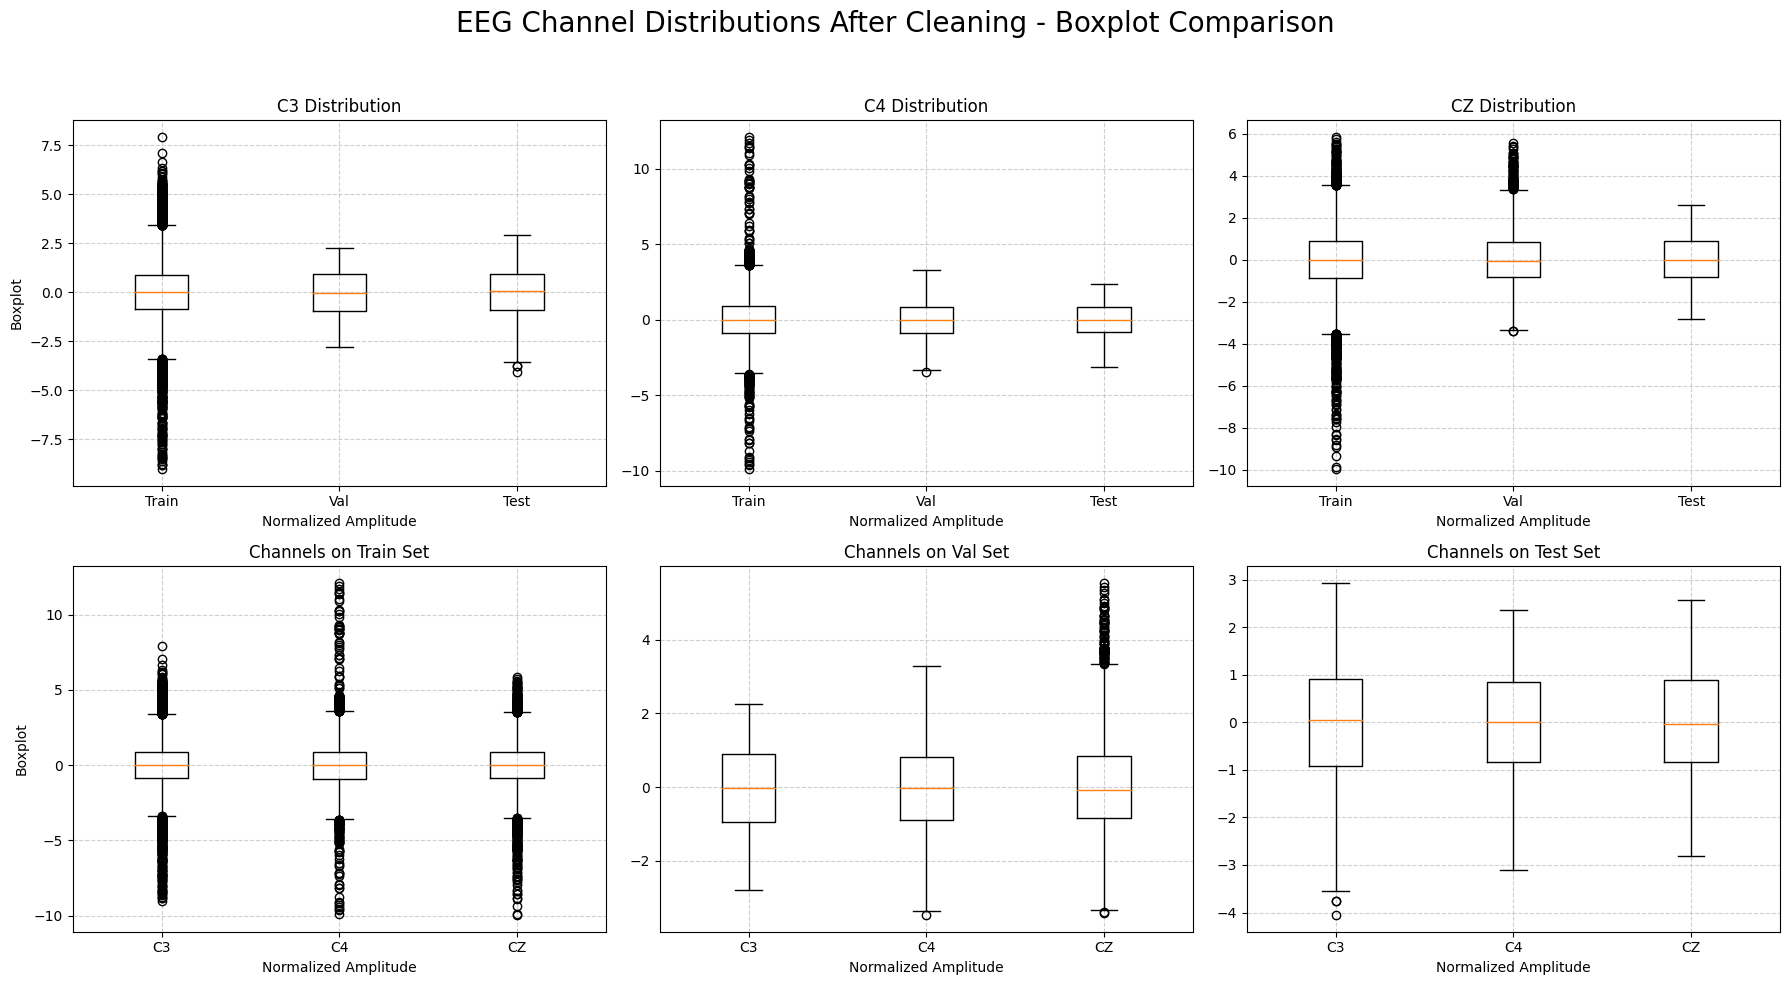

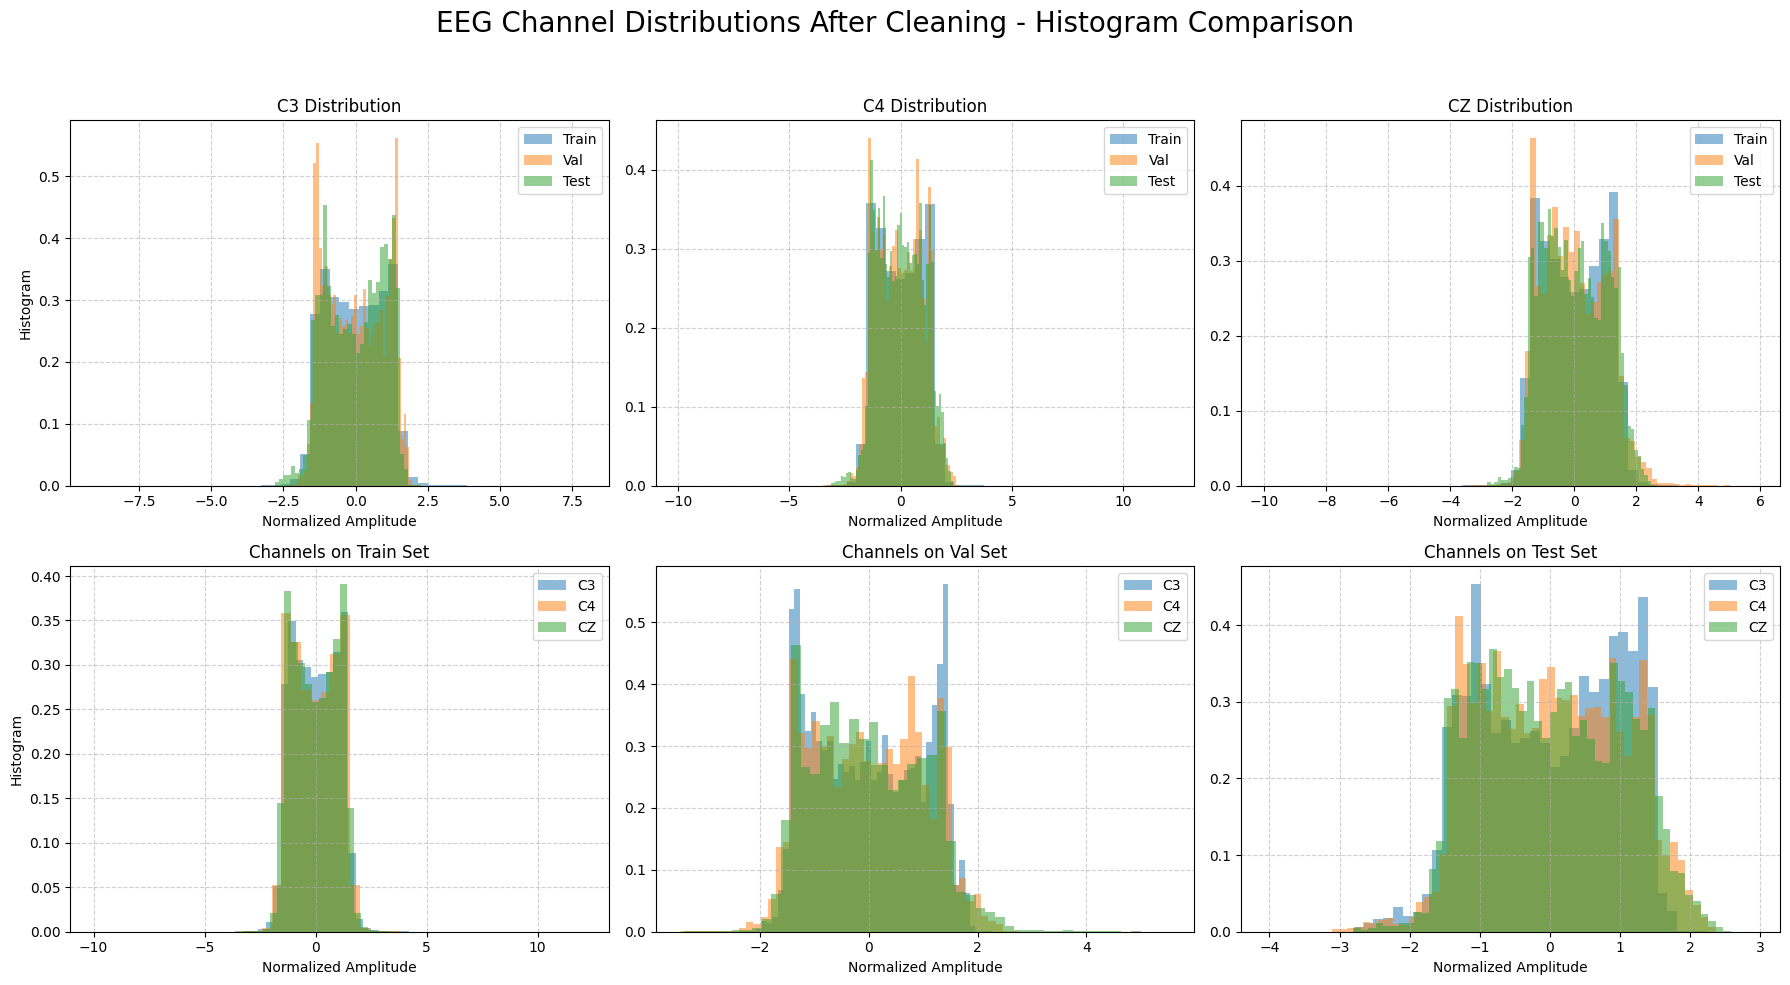

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

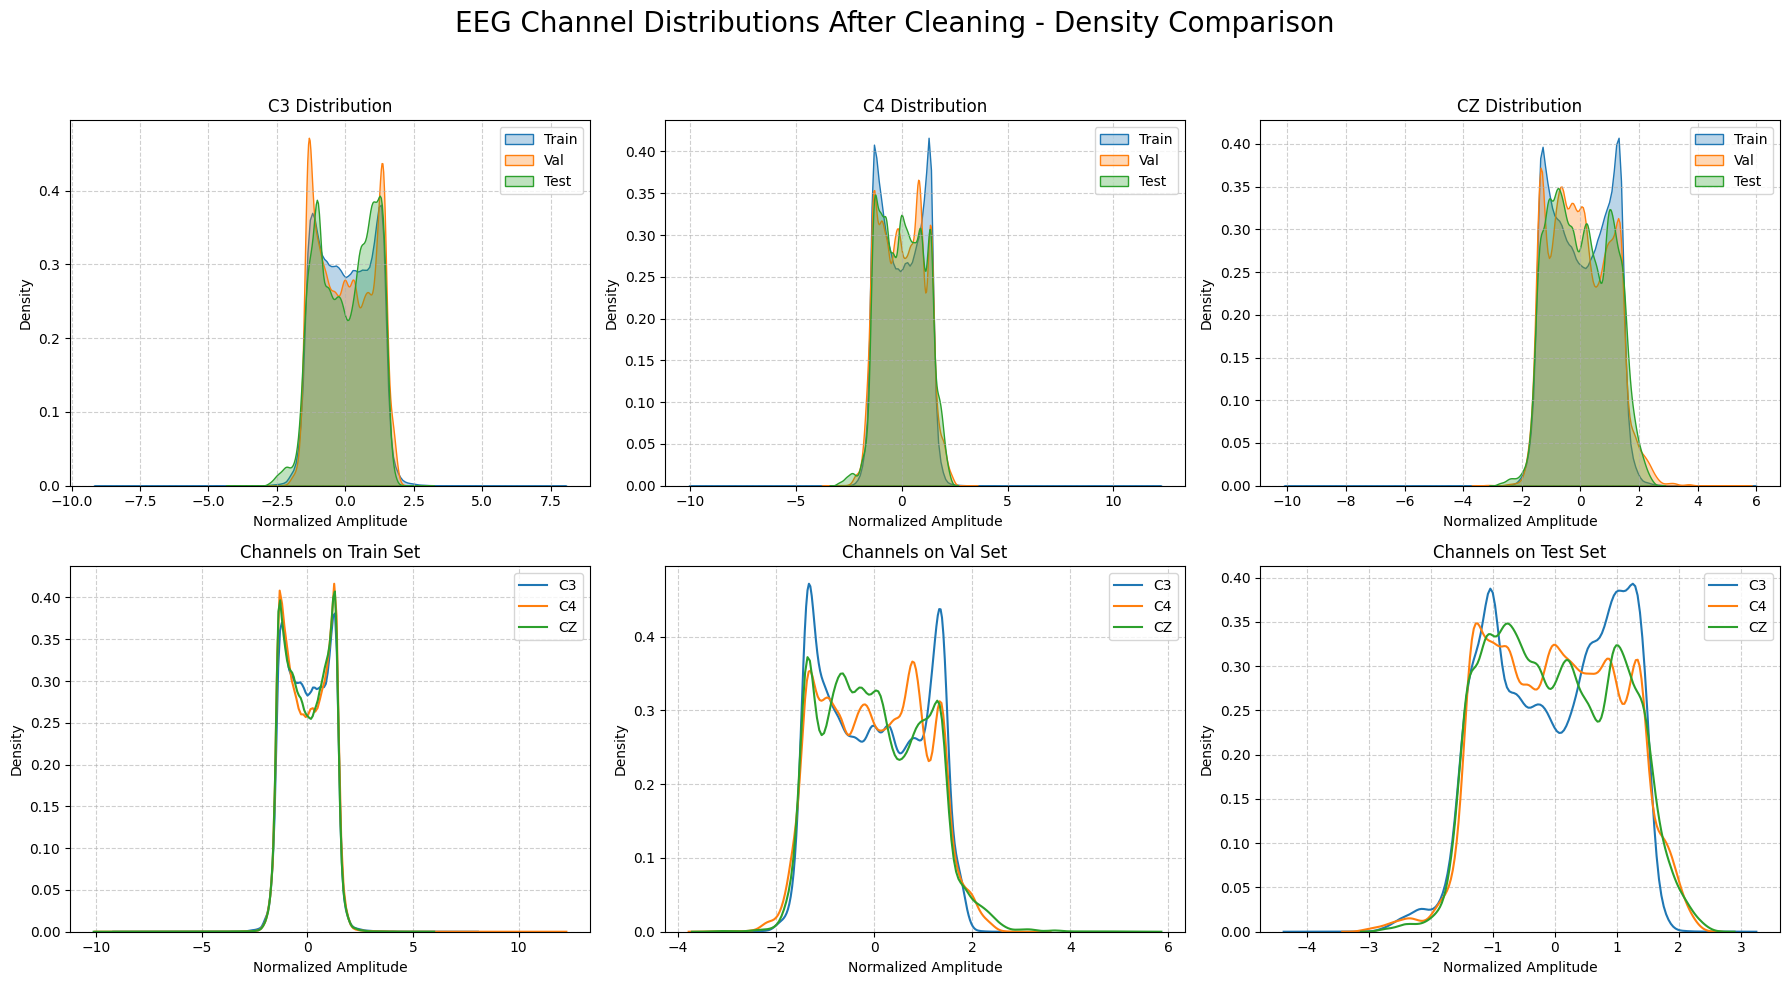


FINAL CHANNEL STATISTICS (POST-CLEANING & NORMALIZATION)

TRAIN DISTRIBUTION STATISTICS (POST-CLEANING):
| Channel   |         Mean |      Std |    Skewness |   Kurtosis |      Min |       25% |     Median |      75% |      Max |
|:----------|-------------:|---------:|------------:|-----------:|---------:|----------:|-----------:|---------:|---------:|
| C3        | -0.000957752 | 0.97065  |  0.0217519  |  -0.81314  | -9.03273 | -0.850766 | -0.0105703 | 0.851144 |  7.91475 |
| C4        | -0.00489032  | 0.990287 |  0.0362507  |  -0.951334 | -9.90084 | -0.908238 | -0.0106308 | 0.898034 | 12.101   |
| CZ        | -0.00739504  | 0.982745 | -0.00149526 |  -1.04717  | -9.96046 | -0.887006 | -0.0192981 | 0.880701 |  5.8395  |

VALIDATION DISTRIBUTION STATISTICS (POST-CLEANING):
| Channel   |        Mean |      Std |   Skewness |   Kurtosis |      Min |       25% |     Median |      75% |     Max |
|:----------|------------:|---------:|-----------:|-----------:|---------:|----------:|-------

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 33, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 33, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 16, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 16, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 16, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 8, 12, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 8, 12, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 8, 12, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 4, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 4, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 4, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 2, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 2, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 2, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          32,8

 Total params: 1,737,026 (6.63 MB)

 Trainable params: 1,735,042 (6.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/30


I0000 00:00:1751212200.244872      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.4914 - f1_score: 0.4658 - loss: 1.3100 - val_accuracy: 0.5600 - val_f1_score: 0.3462 - val_loss: 0.6869
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.4941 - f1_score: 0.4849 - loss: 0.8144 - val_accuracy: 0.5600 - val_f1_score: 0.3462 - val_loss: 1.0567
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.5172 - f1_score: 0.5091 - loss: 0.7189 - val_accuracy: 0.5600 - val_f1_score: 0.3462 - val_loss: 1.0277
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.5102 - f1_score: 0.4902 - loss: 0.7121 - val_accuracy: 0.5600 - val_f1_score: 0.3462 - val_loss: 0.7526
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.5352 - f1_score: 0.5063 - loss: 0.6930 - val_accuracy: 0.5600 - val_f1_score: 0.3462 - val_loss: 0.9900
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.4799 - f1_score: 0.4467 - loss: 0.6918 - val_accuracy: 0.5600 - val_f1_score: 0.3462 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 1500, 3, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 1500, 3, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 750, 3, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 750, 3, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 750, 3, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 375, 3, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 375, 3, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 375, 3, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 187, 3, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 71808)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │       4,595,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,689,474 (17.89 MB)

 Trainable params: 4,689,026 (17.89 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.4841 - f1_score: 0.4365 - loss: 10.6377 - val_accuracy: 0.4800 - val_f1_score: 0.4533 - val_loss: 1.0379
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.5190 - f1_score: 0.5108 - loss: 0.9605 - val_accuracy: 0.5000 - val_f1_score: 0.4732 - val_loss: 1.0565
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.4689 - f1_score: 0.4587 - loss: 1.0486 - val_accuracy: 0.5000 - val_f1_score: 0.4557 - val_loss: 0.6903
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.5083 - f1_score: 0.4994 - loss: 0.9695 - val_accuracy: 0.4400 - val_f1_score: 0.3149 - val_loss: 0.6972
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.5017 - f1_score: 0.4929 - loss: 0.9654 - val_accuracy: 0.5800 - val_f1_score: 0.3978 - val_loss: 0.6831
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.4779 - f1_score: 0.4682 - loss: 0.9434 - val_accuracy: 0.4400 - val_f1_score: 0.314

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: CSP.__init__() got an unexpected keyword argument 'cov_method'

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
import scipy.signal
from sklearn.metrics import classification_report, f1_score # Import for classification report and f1_score


# ==============================
# CONFIGURATION
# ==============================
BASE_PATH = "/kaggle/input/mtcaic3"
TASK = "MI"  # Focus on Motor Imagery

# EEG and Motion Sensor channel definitions
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
TARGET_CHANNELS = ['C3', 'C4', 'CZ']  # Channels for detailed analysis
MOTION_CHANNELS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
VALIDATION_COL = 'Validation'  # Column name for validation flag

# Signal properties
SAMPLE_RATE = 250
TRIAL_DURATION = 9  # seconds for MI
SAMPLES_PER_TRIAL = SAMPLE_RATE * TRIAL_DURATION
# ARTIFACT_STD_THRESHOLD = 1.0  # Threshold in standard deviations for outlier removal (retained for motion)
TIME_WINDOW = (1, 7)  # Focus on 1-7s window
TIME_WINDOW_SAMPLES = int((TIME_WINDOW[1] - TIME_WINDOW[0]) * SAMPLE_RATE)  # 1500 samples

# Augmentation
GAUSSIAN_NOISE_STD = 0.05 # Standard deviation for Gaussian noise augmentation

# Track duplicates and interpolation (global counters)
TOTAL_DUPLICATES = 0
TOTAL_INTERPOLATED = 0
TOTAL_INVALID_ROWS = 0

# Model Training Parameters
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# ==============================
# CUSTOM F1 SCORE METRIC FOR KERAS
# ==============================

class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_f1 = self.add_weight(name='total_f1', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Convert one-hot encoded to sparse labels
        y_true_labels = tf.argmax(y_true, axis=-1)
        y_pred_labels = tf.argmax(y_pred, axis=-1)

        # Ensure tensors have known shapes for tf.py_function
        # Reshape to 1D to match what sklearn's f1_score typically expects
        y_true_labels = tf.reshape(y_true_labels, [-1])
        y_pred_labels = tf.reshape(y_pred_labels, [-1])

        # Compute F1 score per batch (macro average)
        f1 = tf.py_function(lambda yt, yp: f1_score(yt.numpy(), yp.numpy(), average='macro'),
                            inp=[y_true_labels, y_pred_labels],
                            Tout=tf.float32)
        
        # Explicitly set the shape of the output tensor from tf.py_function
        # f1_score with average='macro' returns a single scalar, so shape is ()
        f1.set_shape(()) 

        self.total_f1.assign_add(f1)
        self.count.assign_add(1.0)

    def result(self):
        # Handle division by zero if count is 0
        return tf.math.divide_no_nan(self.total_f1, self.count)

    def reset_state(self):
        self.total_f1.assign(0.0)
        self.count.assign(0.0)


# ==============================
# DATA LOADING (HELPER)
# ==============================

def load_single_trial(row, dataset_type, base_path, time_window=None):
    """Loads raw data with time window selection, handles duplicates, and interpolates invalid values"""
    global TOTAL_DUPLICATES, TOTAL_INTERPOLATED, TOTAL_INVALID_ROWS
    
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset_type,
        row['subject_id'],
        str(row['trial_session']),
        "EEGdata.csv"
    )
    if not os.path.exists(eeg_path):
        return None, 0, 0, 0

    # Load data and handle duplicates
    eeg_data = pd.read_csv(eeg_path)
    
    # Handle cross-session duplicates using composite key
    duplicate_mask = eeg_data.duplicated()
    duplicates_removed = duplicate_mask.sum()
    eeg_data = eeg_data[~duplicate_mask]
    
    # Handle invalid rows marked by Validation column
    invalid_mask = eeg_data.get(VALIDATION_COL, pd.Series(False, index=eeg_data.index)) == 0.0
    invalid_count = invalid_mask.sum()
    
    # Replace invalid EEG values with NaN
    eeg_data.loc[invalid_mask, EEG_CHANNELS] = np.nan
    
    # Replace infinite values with NaN
    eeg_data[EEG_CHANNELS] = eeg_data[EEG_CHANNELS].replace([np.inf, -np.inf], np.nan)
    
    # Count NaNs before interpolation
    nan_count_before = eeg_data[EEG_CHANNELS].isna().sum().sum()
    
    # Interpolate missing values
    eeg_data[EEG_CHANNELS] = eeg_data[EEG_CHANNELS].interpolate(
        method='linear', 
        axis=0, 
        limit_direction='both'
    )
    
    nan_count_after = eeg_data[EEG_CHANNELS].isna().sum().sum()
    interpolated_count = nan_count_before - nan_count_after
    
    # Update global counters (these counters accumulate across all calls, which is intended here)
    TOTAL_DUPLICATES += duplicates_removed
    TOTAL_INTERPOLATED += interpolated_count
    TOTAL_INVALID_ROWS += invalid_count
    
    # Extract trial
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    trial_data = eeg_data.iloc[start_idx:end_idx]
    
    # Apply time window if specified
    if time_window:
        start_sample = int(time_window[0] * SAMPLE_RATE)
        end_sample = int(time_window[1] * SAMPLE_RATE)
        trial_data = trial_data.iloc[start_sample:end_sample]
        
    return trial_data, duplicates_removed, interpolated_count, invalid_count

# ==============================
# ARTIFACT DETECTION & THRESHOLD CALCULATION (PASS 1)
# ==============================

def calculate_artifact_thresholds(df, base_path, dataset_for_thresholds='validation'):
    """Analyzes specified dataset's trials to compute metrics and determine outlier thresholds"""
    print(f"Pass 1: Analyzing {dataset_for_thresholds} data to calculate artifact thresholds...")
    
    # Metrics to collect for each trial
    motion_stds = []
    max_abs_amplitudes_target_channels = []
    eeg_variances_target_channels = []
    
    # Use only the MI task data from the specified dataset
    mi_df = df[df['task'] == TASK].copy()

    # Reset local counters for this function call to avoid double counting with global
    local_duplicates = 0
    local_interpolated = 0
    local_invalid = 0

    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc=f"Calculating thresholds from {dataset_for_thresholds}"):
        trial_data, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
            row, dataset_for_thresholds, base_path # Use dataset_for_thresholds for loading
        )
        if trial_data is None or trial_data.empty:
            continue
            
        local_duplicates += duplicates_removed
        local_interpolated += interpolated_count
        local_invalid += invalid_count

        # 1. Motion metrics (still using STD)
        motion_stds.append(trial_data[MOTION_CHANNELS].std().sum())

        # 2. Amplitude and Variance metrics for TARGET_CHANNELS (C3, C4, CZ)
        eeg_data_target = trial_data[TARGET_CHANNELS]
        max_abs_amplitudes_target_channels.append(eeg_data_target.abs().max().max())
        eeg_variances_target_channels.append(eeg_data_target.var().mean()) # Mean variance across target channels

    # Calculate thresholds for motion_std using STD (as before)
    motion_std_thresh_upper = np.mean(motion_stds) + np.std(motion_stds)
    
    # Calculate IQR thresholds for target channel amplitude
    q1_amp = np.percentile(max_abs_amplitudes_target_channels, 25)
    q3_amp = np.percentile(max_abs_amplitudes_target_channels, 75)
    
    # Calculate IQR thresholds for target channel variance
    q1_var = np.percentile(eeg_variances_target_channels, 25)
    q3_var = np.percentile(eeg_variances_target_channels, 75)

    thresholds = {
        'motion_std_thresh_upper': motion_std_thresh_upper,
        'max_abs_amp_q1': q1_amp,
        'max_abs_amp_q3': q3_amp,
        'eeg_var_q1': q1_var,
        'eeg_var_q3': q3_var
    }

    print("\nCalculated Artifact Thresholds:")
    print(f"  (based on {dataset_for_thresholds} data)")
    for key, val in thresholds.items():
        print(f"  - {key}: {val:.4f}")
    
    print(f"\nData Validation Stats (Pass 1 - {dataset_for_thresholds} data used for thresholds):")
    print(f"  - Duplicates removed (this pass): {local_duplicates}")
    print(f"  - Values interpolated (this pass): {local_interpolated}")
    print(f"  - Invalid rows handled (this pass): {local_invalid}")
        
    return thresholds


# ==============================
# DATA CLEANING AND FILTERING (PASS 2)
# ==============================

def get_clean_trials(df, dataset_type, base_path, thresholds):
    """Filters training data based on calculated thresholds, keeps all validation/test trials."""
    # Reset local counters for this function call
    local_duplicates = 0
    local_interpolated = 0
    local_invalid = 0
    
    if dataset_type == 'train': # Only filter 'train' based on thresholds
        mi_df = df[df['task'] == TASK].copy()
        clean_ids = []
        
        for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc=f"Filtering {dataset_type}"):
            # Load full trial (0-9s) for artifact detection
            trial_data, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
                row, dataset_type, base_path
            )
            if trial_data is None or trial_data.empty:
                continue
                
            local_duplicates += duplicates_removed
            local_interpolated += interpolated_count
            local_invalid += invalid_count
                
            # Calculate metrics for the current trial
            motion_std = trial_data[MOTION_CHANNELS].std().sum()
            eeg_data_target = trial_data[TARGET_CHANNELS]
            max_abs_amplitude = eeg_data_target.abs().max().max()
            eeg_variance = eeg_data_target.var().mean()
            
            # Apply filtering criteria using the provided thresholds
            is_clean = (
                motion_std < thresholds['motion_std_thresh_upper'] and
                thresholds['max_abs_amp_q1'] <= max_abs_amplitude <= thresholds['max_abs_amp_q3'] and
                thresholds['eeg_var_q1'] <= eeg_variance <= thresholds['eeg_var_q3']
            )
            
            if is_clean:
                clean_ids.append(row['id'])
                
        clean_df = df[df['id'].isin(clean_ids)].copy()
        print(f"Training: Kept {len(clean_df)}/{len(mi_df)} trials after filtering")
    else:
        # For validation/test sets, we process all trials but do not filter them based on thresholds.
        # This ensures we have a consistent dataset size for evaluation.
        clean_df = df[df['task'] == TASK].copy()
        print(f"Processing all {dataset_type} trials (no threshold-based filtering)")
        
        # Still need to load data to process duplicates and interpolation for these sets
        for _, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc=f"Processing {dataset_type}"):
            _, duplicates_removed, interpolated_count, invalid_count = load_single_trial(
                row, dataset_type, base_path
            )
            local_duplicates += duplicates_removed
            local_interpolated += interpolated_count
            local_invalid += invalid_count
            
    print(f"\nData Validation Stats ({dataset_type.capitalize()}):")
    print(f"  - Duplicates removed (this pass): {local_duplicates}")
    print(f"  - Values interpolated (this pass): {local_interpolated}")
    print(f"  - Invalid rows handled (this pass): {local_invalid}")
    
    return clean_df


# ==============================
# NORMALIZATION & FINAL DATA PREPARATION
# ==============================

def load_normalized_clean_data(clean_df, dataset_type, base_path, apply_augmentation=False):
    """Loads, normalizes, and optionally augments 1-7s data for clean trials"""
    print(f"\nLoading and normalizing 1-7s data for '{dataset_type}'...")
    all_trial_data = []
    all_labels = [] # For MI task, labels will be 'Left' or 'Right'
    all_ids = [] # For test set to generate submission

    grouped = clean_df.groupby(['subject_id', 'trial_session'])
    
    for (subject, session), group in tqdm(grouped, desc=f"Normalizing {dataset_type}"):
        session_path = os.path.join(base_path, TASK, dataset_type, subject, str(session), "EEGdata.csv")
        if not os.path.exists(session_path):
            continue
            
        # Load session data with comprehensive cleaning
        session_data = pd.read_csv(session_path)
        
        # Handle duplicates
        session_data = session_data.drop_duplicates()
        
        # Handle invalid rows
        invalid_mask = session_data.get(VALIDATION_COL, pd.Series(False, index=session_data.index)) == 0.0
        session_data.loc[invalid_mask, EEG_CHANNELS] = np.nan
        
        # Handle infinite values
        session_data[EEG_CHANNELS] = session_data[EEG_CHANNELS].replace([np.inf, -np.inf], np.nan)
        
        # Interpolate
        session_data[EEG_CHANNELS] = session_data[EEG_CHANNELS].interpolate(
            method='linear', 
            axis=0, 
            limit_direction='both'
        )
        
        # Session-level normalization
        session_means = session_data[EEG_CHANNELS].mean()
        session_stds = session_data[EEG_CHANNELS].std()

        for _, row in group.iterrows():
            # Extract 1-7s segment
            trial_num = int(row['trial'])
            start_idx = (trial_num - 1) * SAMPLES_PER_TRIAL
            end_idx = start_idx + SAMPLES_PER_TRIAL
            trial_data_full = session_data.iloc[start_idx:end_idx]
            
            # Apply time window
            start_sample = int(TIME_WINDOW[0] * SAMPLE_RATE)
            end_sample = int(TIME_WINDOW[1] * SAMPLE_RATE)
            trial_data = trial_data_full.iloc[start_sample:end_sample]

            # Normalize selected EEG channels
            normalized_trial = (trial_data[TARGET_CHANNELS] - session_means[TARGET_CHANNELS]) / (session_stds[TARGET_CHANNELS] + 1e-8)
            
            # Apply Gaussian augmentation if specified and not for test set
            if apply_augmentation and dataset_type == 'train':
                normalized_trial = add_gaussian_noise(normalized_trial, GAUSSIAN_NOISE_STD)

            all_trial_data.append(normalized_trial.values)
            if 'label' in row:
                all_labels.append(row['label'])
            all_ids.append(row['id'])
                
    return np.array(all_trial_data), np.array(all_labels), np.array(all_ids)

# ==============================
# DATA AUGMENTATION
# ==============================
def add_gaussian_noise(data, noise_std):
    """Adds Gaussian noise to the data."""
    return data + np.random.normal(0, noise_std, data.shape)

# ==============================
# MODEL 1: STFT/CWT -> CNN
# ==============================
def create_model_stft_cnn(input_shape, num_classes):
    model = models.Sequential()
    # Input is (freq_bins, time_frames, num_channels)
    
    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    
    # FC Layer 1
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5)) # Added Dropout for regularization
    
    # FC Layer 2
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # FC Layer 3 (Output Layer)
    model.add(layers.Dense(num_classes, activation='softmax')) # Output is softmax

    return model

def create_stft_input(data, nperseg=64, noverlap=32):
    """
    Generates STFT spectrograms for each channel and stacks them.
    Input data shape: (num_trials, time_samples, num_channels)
    Output shape: (num_trials, freq_bins, time_frames, num_channels)
    """
    spectrograms = []
    if data.shape[0] == 0: # Handle case with no trials
        # Determine expected shape for an empty array
        # This will depend on what scipy.signal.stft would produce for a single channel
        # for a time series of TIME_WINDOW_SAMPLES
        # Let's run a dummy to get the shape for 1 channel
        dummy_f, dummy_t, dummy_Zxx = scipy.signal.stft(np.zeros(TIME_WINDOW_SAMPLES), fs=SAMPLE_RATE, nperseg=nperseg, noverlap=noverlap)
        freq_bins = dummy_Zxx.shape[0]
        time_frames = dummy_Zxx.shape[1]
        num_channels = data.shape[2] # Number of channels should be preserved
        return np.empty((0, freq_bins, time_frames, num_channels), dtype=np.float32)

    for i in range(data.shape[0]): # Iterate through trials
        trial_spectrograms = []
        for j in range(data.shape[2]): # Iterate through channels
            # Compute STFT for each channel
            f, t, Zxx = scipy.signal.stft(data[i, :, j], fs=SAMPLE_RATE, nperseg=nperseg, noverlap=noverlap)
            trial_spectrograms.append(np.abs(Zxx)) # Use magnitude spectrogram
        spectrograms.append(np.stack(trial_spectrograms, axis=-1)) # Stack channels as last dim
    return np.array(spectrograms)

# ==============================
# MODEL 2: 2D Raw matrix -> CNN
# ==============================
def create_model_raw_cnn(input_shape, num_classes):
    # Input shape: (time_samples, num_channels, 1)
    model = models.Sequential()
    
    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    # Pool along the time dimension (first dim of the spatial part)
    # The channel dimension (second dim of the spatial part) is 3, so a (2,2) pool will shrink it.
    # To avoid reducing a dimension to 0 or negative, we can ensure the pooling only happens on the time axis.
    model.add(layers.MaxPooling2D((2, 1))) 
    
    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    
    model.add(layers.Flatten())
    
    # FC Layer 1
    model.add(layers.Dense(64, activation='elu')) 
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# ==============================
# MODEL 3: CSP features -> Multi-layer CNN
# ==============================
def create_model_csp_cnn(input_shape, num_classes):
    # Input shape: (num_csp_components, time_samples, 1)
    # Pool along the time dimension (second dim of the spatial part).
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (1, 3), activation='elu', input_shape=input_shape, padding='same')) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2))) 
    
    # Conv Block 2
    model.add(layers.Conv2D(64, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 4
    model.add(layers.Conv2D(256, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 5
    model.add(layers.Conv2D(512, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 6
    model.add(layers.Conv2D(1024, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))

    # Conv Block 7
    model.add(layers.Conv2D(2048, (1, 3), activation='elu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((1, 2)))
    
    model.add(layers.Flatten())
    
    # FC Layer 1
    model.add(layers.Dense(256, activation='elu'))
    model.add(layers.Dropout(0.5))

    # FC Layer 2
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dropout(0.5))

    # FC Layer 3 (Output Layer)
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# ==============================
# VISUALIZATION (UNCHANGED)
# ==============================

def create_plots(data_dict, plot_type, title_prefix):
    """Creates boxplots, histograms, or density plots for all channels and datasets"""
    
    # Filter out empty lists from the dictionary for plotting
    plot_data_dict = {}
    for ds_key, channel_dict in data_dict.items():
        plot_data_dict[ds_key] = {ch: vals for ch, vals in channel_dict.items() if vals}
    
    if not any(plot_data_dict['train'].values()):
        print(f"Skipping {plot_type} plots for '{title_prefix}' as there is no training data to plot.")
        return
        
    plt.figure(figsize=(18, 10))
    
    # Plotting by channel across datasets (top row)
    for i, channel in enumerate(TARGET_CHANNELS):
        ax = plt.subplot(2, 3, i + 1)
        
        plot_datasets = []
        plot_labels = []
        for ds in ['train', 'val', 'test']:
            if channel in plot_data_dict[ds] and plot_data_dict[ds][channel]:
                plot_datasets.append(plot_data_dict[ds][channel])
                plot_labels.append(ds.capitalize())

        if plot_datasets:
            if plot_type == 'boxplot':
                ax.boxplot(plot_datasets, labels=plot_labels)
            elif plot_type == 'density':
                for j, ds_data in enumerate(plot_datasets):
                    sns.kdeplot(ds_data, label=plot_labels[j], fill=True, alpha=0.3, ax=ax)
                ax.legend()
            elif plot_type == 'histogram':
                for j, ds_data in enumerate(plot_datasets):
                    ax.hist(ds_data, bins=50, density=True, alpha=0.5, label=plot_labels[j])
                ax.legend()
        
        ax.set_title(f'{channel} Distribution')
        ax.set_xlabel('Normalized Amplitude')
        if i == 0: # Only set ylabel for the first plot in the row
            ax.set_ylabel(plot_type.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)

    # Plotting by dataset across channels (bottom row)
    for i, ds in enumerate(['train', 'val', 'test']):
        ax = plt.subplot(2, 3, i + 4)
        
        channel_plot_data = [plot_data_dict[ds][ch] for ch in TARGET_CHANNELS if ch in plot_data_dict[ds] and plot_data_dict[ds][ch]]
        labels = [ch for ch in TARGET_CHANNELS if ch in plot_data_dict[ds] and plot_data_dict[ds][ch]]

        if channel_plot_data:
            if plot_type == 'boxplot':
                ax.boxplot(channel_plot_data, labels=labels)
            else: # For histogram and density, we overlay
                for j, ch_data in enumerate(channel_plot_data):
                    if plot_type == 'histogram':
                        ax.hist(ch_data, bins=50, density=True, alpha=0.5, label=labels[j])
                    elif plot_type == 'density':
                        sns.kdeplot(ch_data, label=labels[j], ax=ax)
                ax.legend()
        
        ax.set_title(f'Channels on {ds.capitalize()} Set')
        ax.set_xlabel('Normalized Amplitude')
        if i == 0: # Only set ylabel for the first plot in the row
            ax.set_ylabel(plot_type.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(f'{title_prefix} - {plot_type.capitalize()} Comparison', fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ==============================
# STATISTICS (UNCHANGED)
# ==============================

def print_distribution_stats(data, name):
    """Prints detailed distribution statistics for a given dataset"""
    # Check if data for any channel exists before proceeding
    if not any(data.values()):
        print(f"\nNo data to display for {name.upper()} statistics.")
        return
        
    print(f"\n{name.upper()} DISTRIBUTION STATISTICS (POST-CLEANING):")
    stats_data = []
    for channel in TARGET_CHANNELS:
        if not data[channel]: continue # Skip if channel has no data
        channel_stats = {
            'Channel': channel,
            'Mean': np.mean(data[channel]),
            'Std': np.std(data[channel]),
            'Skewness': stats.skew(data[channel]),
            'Kurtosis': stats.kurtosis(data[channel]),
            'Min': np.min(data[channel]),
            '25%': np.percentile(data[channel], 25),
            'Median': np.median(data[channel]),
            '75%': np.percentile(data[channel], 75),
            'Max': np.max(data[channel])
        }
        stats_data.append(channel_stats)
    
    if stats_data:
        stats_df = pd.DataFrame(stats_data)
        print(stats_df.to_markdown(index=False))

# ==============================
# MAIN EXECUTION
# ==============================

if __name__ == "__main__":
    # Load data indices
    train_df_full = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df_full = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df_full = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Reset global counters before data loading
    TOTAL_DUPLICATES = 0
    TOTAL_INTERPOLATED = 0
    TOTAL_INVALID_ROWS = 0

    # --- Pass 1: Calculate thresholds from validation data ---
    # Pass 'validation_df_full' to calculate thresholds
    artifact_thresholds = calculate_artifact_thresholds(validation_df_full, BASE_PATH, dataset_for_thresholds='validation')

    # --- Pass 2: Filter all datasets using these thresholds ---
    # Filter train_df_full using thresholds derived from validation data
    train_df_clean = get_clean_trials(train_df_full, 'train', BASE_PATH, artifact_thresholds)
    # Validation and test sets are not filtered by these thresholds but still processed for stats
    validation_df_clean = get_clean_trials(validation_df_full, 'validation', BASE_PATH, artifact_thresholds)
    test_df_clean = get_clean_trials(test_df_full, 'test', BASE_PATH, artifact_thresholds)

    # Print global data validation stats
    print("\n" + "="*60)
    print("GLOBAL DATA VALIDATION SUMMARY")
    print("="*60)
    print(f"Total duplicates removed across all passes: {TOTAL_DUPLICATES}")
    print(f"Total values interpolated across all passes: {TOTAL_INTERPOLATED}")
    print(f"Total invalid rows handled across all passes: {TOTAL_INVALID_ROWS}")

    # --- Load, normalize, and process the final clean data ---
    # Apply augmentation only to training data
    X_train, y_train_labels, _ = load_normalized_clean_data(train_df_clean, 'train', BASE_PATH, apply_augmentation=True)
    X_val, y_val_labels, _ = load_normalized_clean_data(validation_df_clean, 'validation', BASE_PATH, apply_augmentation=False)
    X_test, _, test_ids = load_normalized_clean_data(test_df_clean, 'test', BASE_PATH, apply_augmentation=False)

    # Combine data for visualization (before one-hot encoding labels)
    # Reconstruct dictionary for visualization based on loaded numpy arrays
    train_data_vis = {ch: [] for ch in TARGET_CHANNELS}
    for i, ch in enumerate(TARGET_CHANNELS):
        if X_train.size > 0: # Check if X_train is not empty before attempting to flatten
            train_data_vis[ch].extend(X_train[:, :, i].flatten())

    val_data_vis = {ch: [] for ch in TARGET_CHANNELS}
    for i, ch in enumerate(TARGET_CHANNELS):
        if X_val.size > 0: # Check if X_val is not empty
            val_data_vis[ch].extend(X_val[:, :, i].flatten())

    test_data_vis = {ch: [] for ch in TARGET_CHANNELS}
    for i, ch in enumerate(TARGET_CHANNELS):
        if X_test.size > 0: # Check if X_test is not empty
            test_data_vis[ch].extend(X_test[:, :, i].flatten())

    all_clean_data_for_vis = {
        'train': train_data_vis,
        'val': val_data_vis,
        'test': test_data_vis
    }

    # --- Generate Visualizations on Cleaned Data ---
    print("\nGenerating plots for the cleaned and normalized data...")
    create_plots(all_clean_data_for_vis, 'boxplot', 'EEG Channel Distributions After Cleaning')
    create_plots(all_clean_data_for_vis, 'histogram', 'EEG Channel Distributions After Cleaning')
    create_plots(all_clean_data_for_vis, 'density', 'EEG Channel Distributions After Cleaning')

    # --- Print Final Statistics on Cleaned Data ---
    print("\n" + "="*60)
    print("FINAL CHANNEL STATISTICS (POST-CLEANING & NORMALIZATION)")
    print("="*60)
    print_distribution_stats(train_data_vis, "Train")
    print_distribution_stats(val_data_vis, "Validation")
    print_distribution_stats(test_data_vis, "Test")


    # --- Prepare labels for model training ---
    label_encoder = LabelEncoder()
    # Check if training data exists after filtering
    if len(y_train_labels) == 0:
        print("\nNo training data left after cleaning. Cannot proceed with model training.")
        # Create empty submission files to prevent further errors in automated systems
        pd.DataFrame({'id': test_ids, 'label': ['NoPrediction'] * len(test_ids)}).to_csv('submission_model1_stft_cnn.csv', index=False)
        pd.DataFrame({'id': test_ids, 'label': ['NoPrediction'] * len(test_ids)}).to_csv('submission_model2_raw_cnn.csv', index=False)
        pd.DataFrame({'id': test_ids, 'label': ['NoPrediction'] * len(test_ids)}).to_csv('submission_model3_csp_cnn.csv', index=False)
        exit() # Exit if no training data

    y_train_encoded = label_encoder.fit_transform(y_train_labels)
    y_val_encoded = label_encoder.transform(y_val_labels)
    num_classes = len(label_encoder.classes_)
    class_names = list(label_encoder.classes_) # Store class names for classification report
    print(f"\nEncoded classes: {class_names}")

    # Convert to one-hot encoding for Keras
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
    y_val_one_hot = tf.keras.utils.to_categorical(y_val_encoded, num_classes)

    # Reshape for CNN inputs: (batch_size, time_samples, num_channels, 1)
    # The last dimension '1' is for the single feature (e.g., amplitude) per channel.
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


    # ==================================
    # Model 1: STFT/CWT -> CNN
    # ==================================
    print("\n" + "="*60)
    print("TRAINING MODEL 1: STFT/CWT -> CNN")
    print("="*60)

    # Generate STFT input
    # STFT will produce (freq_bins, time_frames) for each channel.
    # X_train_reshaped[:,:,:,0] selects (num_trials, time_samples, num_channels)
    X_train_stft = create_stft_input(X_train_reshaped[:,:,:,0]) 
    X_val_stft = create_stft_input(X_val_reshaped[:,:,:,0])
    X_test_stft = create_stft_input(X_test_reshaped[:,:,:,0])

    # Reshape STFT output for CNN: (num_trials, freq_bins, time_frames, num_channels)
    
    stft_input_shape = X_train_stft.shape[1:] # (freq_bins, time_frames, num_channels)
    model1 = create_model_stft_cnn(stft_input_shape, num_classes)
    
    # *** FIX: Added run_eagerly=True to handle tf.py_function in the custom metric ***
    model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', F1ScoreMetric()],
                   run_eagerly=True) 
    model1.summary()

    history1 = model1.fit(X_train_stft, y_train_one_hot,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_stft, y_val_one_hot),
                          verbose=1)
    
    # Evaluate Model 1
    print("\n--- Model 1 Evaluation on Validation Set ---")
    val_predictions1 = model1.predict(X_val_stft)
    val_predicted_labels1 = np.argmax(val_predictions1, axis=1)
    print(classification_report(y_val_encoded, val_predicted_labels1, target_names=class_names))

    # Predict and save submission for Model 1
    predictions1 = model1.predict(X_test_stft)
    predicted_labels1 = label_encoder.inverse_transform(np.argmax(predictions1, axis=1))
    
    submission_df1 = pd.DataFrame({'id': test_ids, 'label': predicted_labels1})
    submission_df1.to_csv('submission_model1_stft_cnn.csv', index=False)
    print("Submission file for Model 1 created: submission_model1_stft_cnn.csv")


    # ==================================
    # Model 2: 2D Raw matrix -> CNN
    # ==================================
    print("\n" + "="*60)
    print("TRAINING MODEL 2: 2D Raw matrix -> CNN")
    print("="*60)

    raw_input_shape = X_train_reshaped.shape[1:] # (time_samples, num_channels, 1)
    model2 = create_model_raw_cnn(raw_input_shape, num_classes)

    # *** FIX: Added run_eagerly=True to handle tf.py_function in the custom metric ***
    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', F1ScoreMetric()],
                   run_eagerly=True)
    model2.summary()

    history2 = model2.fit(X_train_reshaped, y_train_one_hot,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val_reshaped, y_val_one_hot),
                          verbose=1)

    # Evaluate Model 2
    print("\n--- Model 2 Evaluation on Validation Set ---")
    val_predictions2 = model2.predict(X_val_reshaped)
    val_predicted_labels2 = np.argmax(val_predictions2, axis=1)
    print(classification_report(y_val_encoded, val_predicted_labels2, target_names=class_names))

    # Predict and save submission for Model 2
    predictions2 = model2.predict(X_test_reshaped)
    predicted_labels2 = label_encoder.inverse_transform(np.argmax(predictions2, axis=1))
    
    submission_df2 = pd.DataFrame({'id': test_ids, 'label': predicted_labels2})
    submission_df2.to_csv('submission_model2_raw_cnn.csv', index=False)
    print("Submission file for Model 2 created: submission_model2_raw_cnn.csv")


    # ==================================
    # Model 3: CSP features -> Multi-layer CNN
    # ==================================
    print("\n" + "="*60)
    print("TRAINING MODEL 3: CSP features -> Multi-layer CNN")
    print("="*60)

    # CSP expects data in (n_trials, n_channels, n_times)
    # Our data is currently (n_trials, n_times, n_channels, 1) so we need to permute
    X_train_csp_input = X_train.transpose(0, 2, 1) # (n_trials, n_channels, n_times)
    X_val_csp_input = X_val.transpose(0, 2, 1)
    X_test_csp_input = X_test.transpose(0, 2, 1)
    
    # Initialize CSP
    n_components_csp = 4 # Common choice for 2 classes
    
    csp = CSP(n_components=n_components_csp, reg=None, log=True, cov_method='empirical')
    
    # Fit and transform training data
    # Only fit CSP if there's enough training data
    if X_train_csp_input.shape[0] > 0:
        X_train_csp_features = csp.fit_transform(X_train_csp_input, y_train_encoded)
        X_val_csp_features = csp.transform(X_val_csp_input)
        X_test_csp_features = csp.transform(X_test_csp_input)

        # Apply CSP filters to get spatially filtered time series
        csp_filters = csp.filters_
        
        # This step is critical: Project raw EEG onto CSP filters
        # Resulting shape: (num_trials, n_components_csp, time_samples)
        X_train_csp_ts = np.array([np.dot(csp_filters, trial) for trial in X_train_csp_input])
        X_val_csp_ts = np.array([np.dot(csp_filters, trial) for trial in X_val_csp_input])
        X_test_csp_ts = np.array([np.dot(csp_filters, trial) for trial in X_test_csp_input])

        # Reshape for CNN: (num_trials, num_csp_components, time_samples, 1)
        # The last dimension '1' is for the single feature (e.g., amplitude) per CSP component.
        X_train_csp_ts_reshaped = X_train_csp_ts.reshape(X_train_csp_ts.shape[0], X_train_csp_ts.shape[1], X_train_csp_ts.shape[2], 1)
        X_val_csp_ts_reshaped = X_val_csp_ts.reshape(X_val_csp_ts.shape[0], X_val_csp_ts.shape[1], X_val_csp_ts.shape[2], 1)
        X_test_csp_ts_reshaped = X_test_csp_ts.reshape(X_test_csp_ts.shape[0], X_test_csp_ts.shape[1], X_test_csp_ts.shape[2], 1)


        csp_input_shape = X_train_csp_ts_reshaped.shape[1:] # (num_csp_components, time_samples, 1)
        model3 = create_model_csp_cnn(csp_input_shape, num_classes)
        
        # *** FIX: Added run_eagerly=True to handle tf.py_function in the custom metric ***
        model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', F1ScoreMetric()],
                       run_eagerly=True)
        model3.summary()

        history3 = model3.fit(X_train_csp_ts_reshaped, y_train_one_hot,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_val_csp_ts_reshaped, y_val_one_hot),
                              verbose=1)

        # Evaluate Model 3
        print("\n--- Model 3 Evaluation on Validation Set ---")
        val_predictions3 = model3.predict(X_val_csp_ts_reshaped)
        val_predicted_labels3 = np.argmax(val_predictions3, axis=1)
        print(classification_report(y_val_encoded, val_predicted_labels3, target_names=class_names))

        # Predict and save submission for Model 3
        predictions3 = model3.predict(X_test_csp_ts_reshaped)
        predicted_labels3 = label_encoder.inverse_transform(np.argmax(predictions3, axis=1))
        
        submission_df3 = pd.DataFrame({'id': test_ids, 'label': predicted_labels3})
        submission_df3.to_csv('submission_model3_csp_cnn.csv', index=False)
        print("Submission file for Model 3 created: submission_model3_csp_cnn.csv")
    else:
        print("\nSkipping Model 3 training: Not enough training data for CSP after filtering.")
        # Create an empty submission file for Model 3
        pd.DataFrame({'id': test_ids, 'label': ['NoPrediction'] * len(test_ids)}).to_csv('submission_model3_csp_cnn.csv', index=False)


    print("\nTraining and prediction for all models complete!")
    print("Check the submission files: submission_model1_stft_cnn.csv, submission_model2_raw_cnn.csv, submission_model3_csp_cnn.csv")

#drop[ing 70% of data not following contralateral pattern

In [10]:
import pandas as pd
import numpy as np
import os
import mne
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. SETUP AND DATA LOADING ---
print("--- Step 1: Setup and Data Loading ---")

# Base path for the dataset in a Kaggle environment
BASE_PATH = '/kaggle/input/mtcaic3'

# Load the index files
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))

# Filter for MI task only
mi_train_df = train_df[train_df['task'] == 'MI'].copy()
mi_validation_df = validation_df[validation_df['task'] == 'MI'].copy()

print(f"Original MI train trials: {len(mi_train_df)}")
print(f"Original MI validation trials: {len(mi_validation_df)}")
print(f"Class distribution in original training data:\n{mi_train_df['label'].value_counts()}")

# Helper function to load raw EEG data for a specific trial
def load_trial_eeg_data(row, base_path):
    """Loads the 8-channel EEG data for a given trial row."""
    # Determine split (train/validation)
    split = 'train' if row['id'] <= 4800 else 'validation'
    
    eeg_path = os.path.join(base_path, row['task'], split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    eeg_data = pd.read_csv(eeg_path)
    
    samples_per_trial = 2250  # 9s * 250Hz for MI
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    # Extract only the 8 EEG channels
    eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    trial_data = eeg_data.loc[start_idx:end_idx-1, eeg_channels].values
    
    return trial_data

# --- 2. CONTRALATERAL PATTERN IDENTIFICATION ---
print("\n--- Step 2: Identifying Trials Not Following Contralateral Pattern ---")

def check_contralateral_pattern(eeg_trial, label, sfreq=250):
    """
    Checks if an MI trial follows the expected contralateral ERD pattern in the mu-band.
    Returns True if the pattern is followed, False otherwise.
    """
    # Define mu-band
    low_cut = 8.0
    high_cut = 13.0
    
    # Create a bandpass filter
    nyquist = 0.5 * sfreq
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(5, [low, high], btype='band')
    
    # Apply filter
    filtered_eeg = filtfilt(b, a, eeg_trial, axis=0)
    
    # Get power (variance) for C3 and C4 channels (indices 1 and 3)
    power_c3 = np.var(filtered_eeg[:, 1])
    power_c4 = np.var(filtered_eeg[:, 3])
    
    # Check the pattern
    # For 'Left' imagery, power in RIGHT cortex (C4) should be lower
    if label == 'Left' and power_c4 < power_c3:
        return True
    # For 'Right' imagery, power in LEFT cortex (C3) should be lower
    elif label == 'Right' and power_c3 < power_c4:
        return True
        
    # If the conditions aren't met, the pattern is not followed
    return False

# This can be slow, so we'll run it once
# Apply the check to the training dataframe
print("Applying contralateral check to training data... (this may take a minute)")
mi_train_df['follows_pattern'] = mi_train_df.apply(
    lambda row: check_contralateral_pattern(load_trial_eeg_data(row, BASE_PATH), row['label']),
    axis=1
)

# Apply the check to the validation dataframe
print("Applying contralateral check to validation data...")
mi_validation_df['follows_pattern'] = mi_validation_df.apply(
    lambda row: check_contralateral_pattern(load_trial_eeg_data(row, BASE_PATH), row['label']),
    axis=1
)

# --- 3. DATA CLEANING ---
print("\n--- Step 3: Cleaning Data by Dropping 70% of Non-Conforming Trials ---")

def clean_data(df, drop_fraction=0.7):
    """Drops a fraction of trials that do not follow the contralateral pattern."""
    non_conforming = df[~df['follows_pattern']]
    print(f"\nFound {len(non_conforming)} non-conforming trials.")
    print(f"Class distribution of non-conforming trials:\n{non_conforming['label'].value_counts()}")
    
    indices_to_drop = []
    # Process each class separately to maintain balance
    for label in non_conforming['label'].unique():
        class_specific_non_conforming = non_conforming[non_conforming['label'] == label]
        # Sample indices to drop
        drop_indices = class_specific_non_conforming.sample(frac=drop_fraction, random_state=42).index
        indices_to_drop.extend(drop_indices)
        
    print(f"Dropping {len(indices_to_drop)} trials...")
    cleaned_df = df.drop(indices_to_drop)
    return cleaned_df

# Clean both dataframes
cleaned_mi_train_df = clean_data(mi_train_df, drop_fraction=0.7)
cleaned_mi_validation_df = clean_data(mi_validation_df, drop_fraction=0.7)

print(f"\nCleaned MI train trials: {len(cleaned_mi_train_df)}")
print(f"Class distribution in cleaned training data:\n{cleaned_mi_train_df['label'].value_counts()}")

print(f"\nCleaned MI validation trials: {len(cleaned_mi_validation_df)}")
print(f"Class distribution in cleaned validation data:\n{cleaned_mi_validation_df['label'].value_counts()}")

# --- 4. FEATURE ENGINEERING (CSP) ---
print("\n--- Step 4: Loading Data and Applying CSP ---")

# Combine cleaned dataframes for a larger training pool
combined_cleaned_df = pd.concat([cleaned_mi_train_df, cleaned_mi_validation_df], ignore_index=True)

# Load all raw data into a single numpy array
X_raw = np.array([load_trial_eeg_data(row, BASE_PATH) for _, row in combined_cleaned_df.iterrows()])
# Transpose to (n_trials, n_channels, n_samples) which is expected by MNE
X_raw = X_raw.transpose(0, 2, 1)

# Prepare labels
y = combined_cleaned_df['label'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and validation for the final model
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Apply CSP
N_COMPONENTS = 4
csp = mne.decoding.CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)

# Fit CSP on the training data and transform
X_train_csp = csp.fit_transform(X_train, y_train)
X_val_csp = csp.transform(X_val)

print(f"Shape of CSP features for training: {X_train_csp.shape}")

# --- 5. CNN MODEL TRAINING ---
print("\n--- Step 5: Building and Training the CNN Model ---")

# Reshape CSP features for Conv1D layer: (n_samples, n_timesteps, n_features)
X_train_cnn = X_train_csp[:, :, np.newaxis]
X_val_cnn = X_val_csp[:, :, np.newaxis]

print(f"Shape of data for CNN input: {X_train_cnn.shape}")

# Build the model
model = Sequential([
    Input(shape=(N_COMPONENTS, 1)),
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid') # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_cnn, y_train,
    epochs=100,
    validation_data=(X_val_cnn, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# --- 6. EVALUATION ---
print("\n--- Step 6: Final Evaluation on the Validation Set ---")

# Predict probabilities on the validation set
y_pred_proba = model.predict(X_val_cnn)
# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Get original string labels ('Left', 'Right') for the report
y_val_labels = le.inverse_transform(y_val)
y_pred_labels = le.inverse_transform(y_pred)

# Print the classification report
print("\nClassification Report on the Validation Set:\n")
print(classification_report(y_val_labels, y_pred_labels, target_names=le.classes_))

--- Step 1: Setup and Data Loading ---
Original MI train trials: 2400
Original MI validation trials: 50
Class distribution in original training data:
label
Right    1213
Left     1187
Name: count, dtype: int64

--- Step 2: Identifying Trials Not Following Contralateral Pattern ---
Applying contralateral check to training data... (this may take a minute)
Applying contralateral check to validation data...

--- Step 3: Cleaning Data by Dropping 70% of Non-Conforming Trials ---

Found 1209 non-conforming trials.
Class distribution of non-conforming trials:
label
Left     845
Right    364
Name: count, dtype: int64
Dropping 847 trials...

Found 19 non-conforming trials.
Class distribution of non-conforming trials:
label
Right    11
Left      8
Name: count, dtype: int64
Dropping 14 trials...

Cleaned MI train trials: 1553
Class distribution in cleaned training data:
label
Right    958
Left     595
Name: count, dtype: int64

Cleaned MI validation trials: 36
Class distribution in cleaned valida

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 3, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 3, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 50)                  │           4,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,125 (20.02 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
40/40 - 5s - 136ms/step - accuracy: 0.5696 - loss: 0.7347 - val_accuracy: 0.6101 - val_loss: 0.6695
Epoch 2/100
40/40 - 0s - 5ms/step - accuracy: 0.6105 - loss: 0.6827 - val_accuracy: 0.6258 - val_loss: 0.6624
Epoch 3/100
40/40 - 0s - 5ms/step - accuracy: 0.6003 - loss: 0.6853 - val_accuracy: 0.5943 - val_loss: 0.6604
Epoch 4/100
40/40 - 0s - 5ms/step - accuracy: 0.6129 - loss: 0.6657 - val_accuracy: 0.6258 - val_loss: 0.6508
Epoch 5/100
40/40 - 0s - 4ms/step - accuracy: 0.6255 - loss: 0.6518 - val_accuracy: 0.6101 - val_loss: 0.6458
Epoch 6/100
40/40 - 0s - 5ms/step - accuracy: 0.6279 - loss: 0.6546 - val_accuracy: 0.6321 - val_loss: 0.6415
Epoch 7/100
40/40 - 0s - 5ms/step - accuracy: 0.6129 - loss: 0.6614 - val_accuracy: 0.6415 - val_loss: 0.6405
Epoch 8/100
40/40 - 0s - 5ms/step - accuracy: 0.6373 - loss: 0.6494 - val_accuracy: 0.6447 - val_loss: 0.6376
Epoch 9/100
40/40 - 0s - 5ms/step - accuracy: 0.6349 - loss: 0.6574 - val_accuracy: 0.6352 - val_loss: 0.6371
Epoch 10

In [15]:
import pandas as pd
import numpy as np
import os
import mne
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib  # --- NEW: Import joblib to save CSP and LabelEncoder
import warnings

# Suppress MNE's verbose output for cleaner execution
mne.set_log_level('WARNING')
warnings.filterwarnings('ignore', category=RuntimeWarning)


# --- 1. SETUP AND DATA LOADING ---
print("--- Step 1: Setup and Data Loading ---")

BASE_PATH = '/kaggle/input/mtcaic3'
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
# --- NEW: Load test_df for submission generation later ---
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

mi_train_df = train_df[train_df['task'] == 'MI'].copy()
mi_validation_df = validation_df[validation_df['task'] == 'MI'].copy()

# --- Preprocessing Functions ---

def apply_filters(data, sfreq=250):
    """
    Applies notch and band-pass filters to the EEG data.
    data: numpy array of shape (n_samples, n_channels)
    """
    data_transposed = data.T
    data_notched = mne.filter.notch_filter(data_transposed, sfreq, freqs=np.arange(50, 101, 50))
    data_bandpassed = mne.filter.filter_data(data_notched, sfreq, l_freq=8., h_freq=30.)
    return data_bandpassed.T

# --- MODIFIED: Helper function now handles 'test' split ---
def load_trial_eeg_data(row, base_path):
    """
    Loads C3, CZ, C4 channels, interpolates NaNs, and returns the data.
    """
    # Determine split based on ID range
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test' # Handles test data

    eeg_path = os.path.join(base_path, row['task'], split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    
    eeg_data = pd.read_csv(eeg_path)
    
    samples_per_trial = 2250 # Specific to MI
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    eeg_channels = ['C3', 'CZ', 'C4']
    trial_df = eeg_data.loc[start_idx:end_idx-1, eeg_channels]
    
    if trial_df.isnull().values.any():
        trial_df.interpolate(method='linear', limit_direction='both', inplace=True)
        
    return trial_df.values

# --- 2. CONTRALATERAL PATTERN IDENTIFICATION ---
print("\n--- Step 2: Identifying Trials Not Following Contralateral Pattern ---")

def check_contralateral_pattern(eeg_trial, label, sfreq=250):
    low_cut, high_cut = 8.0, 13.0
    nyquist = 0.5 * sfreq
    b, a = butter(5, [low_cut / nyquist, high_cut / nyquist], btype='band')
    filtered_eeg = filtfilt(b, a, eeg_trial, axis=0)
    power_c3 = np.var(filtered_eeg[:, 0]) 
    power_c4 = np.var(filtered_eeg[:, 2])
    if label == 'Left' and power_c4 < power_c3:
        return True
    elif label == 'Right' and power_c3 < power_c4:
        return True
    return False

print("Applying contralateral check... (this may take a minute)")
mi_train_df['follows_pattern'] = mi_train_df.apply(
    lambda row: check_contralateral_pattern(load_trial_eeg_data(row, BASE_PATH), row['label']),
    axis=1
)
mi_validation_df['follows_pattern'] = mi_validation_df.apply(
    lambda row: check_contralateral_pattern(load_trial_eeg_data(row, BASE_PATH), row['label']),
    axis=1
)

# --- 3. DATA CLEANING ---
print("\n--- Step 3: Cleaning Data by Dropping 70% of Non-Conforming Trials ---")

def clean_data(df, drop_fraction=0.8):
    non_conforming = df[~df['follows_pattern']]
    indices_to_drop = []
    for label in non_conforming['label'].unique():
        class_specific_non_conforming = non_conforming[non_conforming['label'] == label]
        drop_indices = class_specific_non_conforming.sample(frac=drop_fraction, random_state=42).index
        indices_to_drop.extend(drop_indices)
    cleaned_df = df.drop(indices_to_drop)
    return cleaned_df

cleaned_mi_train_df = clean_data(mi_train_df)
cleaned_mi_validation_df = clean_data(mi_validation_df)

print(f"\nCleaned MI train trials: {len(cleaned_mi_train_df)}")
print(f"Class distribution in cleaned training data:\n{cleaned_mi_train_df['label'].value_counts()}")
print(f"\nCleaned MI validation trials: {len(cleaned_mi_validation_df)}")
print(f"Class distribution in cleaned validation data:\n{cleaned_mi_validation_df['label'].value_counts()}")

# --- 4. FEATURE ENGINEERING (CSP) ---
print("\n--- Step 4: Loading Data, Filtering, and Applying CSP ---")

combined_cleaned_df = pd.concat([cleaned_mi_train_df, cleaned_mi_validation_df], ignore_index=True)

X_raw_list = []
for _, row in combined_cleaned_df.iterrows():
    trial_data = load_trial_eeg_data(row, BASE_PATH)
    filtered_data = apply_filters(trial_data)
    X_raw_list.append(filtered_data)

X_raw = np.array(X_raw_list).transpose(0, 2, 1)

y = combined_cleaned_df['label'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

N_COMPONENTS = 2
csp = mne.decoding.CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)

X_train_csp = csp.fit_transform(X_train, y_train)
X_val_csp = csp.transform(X_val)

print(f"Shape of CSP features for training: {X_train_csp.shape}")

# --- 5. CNN MODEL TRAINING ---
print("\n--- Step 5: Building and Training the CNN Model ---")

X_train_cnn = X_train_csp[:, :, np.newaxis]
X_val_cnn = X_val_csp[:, :, np.newaxis]

model = Sequential([
    Input(shape=(N_COMPONENTS, 1)),
    Conv1D(filters=16, kernel_size=2, activation='relu', padding='same'),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_cnn, y_train,
    epochs=100,
    validation_data=(X_val_cnn, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)
print("Model training complete.")

# --- 6. EVALUATION ON INTERNAL VALIDATION SPLIT ---
print("\n--- Step 6: Evaluation on the Internal Validation Split ---")

y_pred_proba = model.predict(X_val_cnn)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

y_val_labels = le.inverse_transform(y_val)
y_pred_labels = le.inverse_transform(y_pred)

print("\nClassification Report on the Internal Validation Set:\n")
print(classification_report(y_val_labels, y_pred_labels, target_names=le.classes_))

# --- NEW: STEP 7 - SAVE MODEL AND TRANSFORMERS ---
print("\n--- Step 7: Saving Model and Transformers ---")

# Save the TensorFlow/Keras model
model.save('mi_model.h5')
print("Keras model saved to 'mi_model.h5'")

# Save the CSP transformer and LabelEncoder using joblib for persistence
joblib.dump(csp, 'csp_transformer.pkl')
print("CSP transformer saved to 'csp_transformer.pkl'")
joblib.dump(le, 'label_encoder.pkl')
print("LabelEncoder saved to 'label_encoder.pkl'")


# --- NEW: STEP 8 - EVALUATION ON THE FULL, ORIGINAL VALIDATION SET ---
print("\n--- Step 8: Final Evaluation on the Full Original Validation Set ---")

# 1. Load and preprocess the full validation dataset
X_full_val_list = []
for _, row in mi_validation_df.iterrows():
    trial_data = load_trial_eeg_data(row, BASE_PATH)
    filtered_data = apply_filters(trial_data)
    X_full_val_list.append(filtered_data)
    
X_full_val_raw = np.array(X_full_val_list).transpose(0, 2, 1)

# 2. Apply the *already fitted* CSP transformer
X_full_val_csp = csp.transform(X_full_val_raw)
X_full_val_cnn = X_full_val_csp[:, :, np.newaxis]

# 3. Get the true labels
y_full_val_true = le.transform(mi_validation_df['label'].values)

# 4. Make predictions
y_full_val_pred_proba = model.predict(X_full_val_cnn)
y_full_val_pred = (y_full_val_pred_proba > 0.5).astype(int).flatten()

# 5. Generate and print the classification report
print("\nClassification Report on the Full Original Validation Set:\n")
print(classification_report(y_full_val_true, y_full_val_pred, target_names=le.classes_))


# --- NEW: STEP 9 - GENERATE SUBMISSION FILE FOR THE TEST SET ---
print("\n--- Step 9: Generating Submission File ---")

# 1. Filter the test dataframe for MI tasks
mi_test_df = test_df[test_df['task'] == 'MI'].copy()
print(f"Found {len(mi_test_df)} MI trials in the test set.")

# 2. Load and preprocess the test data using the same pipeline
X_test_list = []
for _, row in mi_test_df.iterrows():
    trial_data = load_trial_eeg_data(row, BASE_PATH)
    filtered_data = apply_filters(trial_data)
    X_test_list.append(filtered_data)
    
X_test_raw = np.array(X_test_list).transpose(0, 2, 1)

# 3. Transform features using the saved transformers
X_test_csp = csp.transform(X_test_raw)
X_test_cnn = X_test_csp[:, :, np.newaxis]

# 4. Predict labels with the trained model
test_predictions_encoded = (model.predict(X_test_cnn) > 0.5).astype(int).flatten()

# 5. Decode labels back to their original string format (e.g., 'Left', 'Right')
test_predictions_labels = le.inverse_transform(test_predictions_encoded)

# 6. Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': mi_test_df['id'],
    'label': test_predictions_labels
})

# 7. Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully!")
print("First 5 rows of the submission file:")
print(submission_df.head())

--- Step 1: Setup and Data Loading ---

--- Step 2: Identifying Trials Not Following Contralateral Pattern ---
Applying contralateral check... (this may take a minute)

--- Step 3: Cleaning Data by Dropping 70% of Non-Conforming Trials ---

Cleaned MI train trials: 1433
Class distribution in cleaned training data:
label
Right    922
Left     511
Name: count, dtype: int64

Cleaned MI validation trials: 35
Class distribution in cleaned validation data:
label
Left     22
Right    13
Name: count, dtype: int64

--- Step 4: Loading Data, Filtering, and Applying CSP ---
Shape of CSP features for training: (1174, 2)

--- Step 5: Building and Training the CNN Model ---


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 2, 16)               │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 2, 16)               │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 25)                  │             825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 963 (3.76 KB)

 Trainable params: 931 (3.64 KB)

 Non-trainable params: 32 (128.00 B)

Model training complete.

--- Step 6: Evaluation on the Internal Validation Split ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Classification Report on the Internal Validation Set:

              precision    recall  f1-score   support

        Left       0.75      0.43      0.55       107
       Right       0.74      0.92      0.82       187

    accuracy                           0.74       294
   macro avg       0.75      0.67      0.68       294
weighted avg       0.74      0.74      0.72       294


--- Step 7: Saving Model and Transformers ---
Keras model saved to 'mi_model.h5'
CSP transformer saved to 'csp_transformer.pkl'
LabelEncoder saved to 'label_encoder.pkl'

--- Step 8: Final Evaluation on the Full Original Validation Set ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

Classification Report on the Full Original Validation Set:

              precision    recall  f1-score   support

        Left       0.65      0.61      0.63        28
       Right       0.54      0.59      0.

In [14]:
import pandas as pd
import numpy as np
import os
import mne
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Import for calculating class weights
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. SETUP AND DATA LOADING ---
print("--- Step 1: Setup and Data Loading ---")

# Base path for the dataset in a Kaggle environment
BASE_PATH = '/kaggle/input/mtcaic3'

# Load the index files
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))

# Filter for MI task only
mi_train_df = train_df[train_df['task'] == 'MI'].copy()
mi_validation_df = validation_df[validation_df['task'] == 'MI'].copy()

print(f"Original MI train trials: {len(mi_train_df)}")
print(f"Original MI validation trials: {len(mi_validation_df)}")
print(f"Class distribution in original training data:\n{mi_train_df['label'].value_counts()}")

# Helper function to load raw EEG data for a specific trial
def load_trial_eeg_data(row, base_path):
    """Loads the 8-channel EEG data for a given trial row."""
    # Determine split (train/validation)
    split = 'train' if row['id'] <= 4800 else 'validation'
    
    eeg_path = os.path.join(base_path, row['task'], split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    eeg_data = pd.read_csv(eeg_path)
    
    samples_per_trial = 2250  # 9s * 250Hz for MI
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    # Extract only the 8 EEG channels
    eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    trial_data = eeg_data.loc[start_idx:end_idx-1, eeg_channels].values
    
    return trial_data

# --- 2. CONTRALATERAL PATTERN IDENTIFICATION ---
print("\n--- Step 2: Identifying Trials Not Following Contralateral Pattern ---")

def check_contralateral_pattern(eeg_trial, label, sfreq=250):
    """
    Checks if an MI trial follows the expected contralateral ERD pattern in the mu-band.
    Returns True if the pattern is followed, False otherwise.
    """
    # Define mu-band
    low_cut = 8.0
    high_cut = 13.0
    
    # Create a bandpass filter
    nyquist = 0.5 * sfreq
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(5, [low, high], btype='band')
    
    # Apply filter
    filtered_eeg = filtfilt(b, a, eeg_trial, axis=0)
    
    # Get power (variance) for C3 and C4 channels (indices 1 and 3)
    power_c3 = np.var(filtered_eeg[:, 1])
    power_c4 = np.var(filtered_eeg[:, 3])
    
    # Check the pattern
    # For 'Left' imagery, power in RIGHT cortex (C4) should be lower
    if label == 'Left' and power_c4 < power_c3:
        return True
    # For 'Right' imagery, power in LEFT cortex (C3) should be lower
    # --- FIX: Changed 'a' to 'power_c3' ---
    elif label == 'Right' and power_c3 < power_c4:
        return True
        
    # If the conditions aren't met, the pattern is not followed
    return False

# This can be slow, so we'll run it once
# Apply the check to the training dataframe
print("Applying contralateral check to training data... (this may take a minute)")
mi_train_df['follows_pattern'] = mi_train_df.apply(
    lambda row: check_contralateral_pattern(load_trial_eeg_data(row, BASE_PATH), row['label']),
    axis=1
)

# Apply the check to the validation dataframe
print("Applying contralateral check to validation data...")
mi_validation_df['follows_pattern'] = mi_validation_df.apply(
    lambda row: check_contralateral_pattern(load_trial_eeg_data(row, BASE_PATH), row['label']),
    axis=1
)

# --- 3. DATA CLEANING ---
print("\n--- Step 3: Cleaning Data by Dropping 70% of Non-Conforming Trials ---")

def clean_data(df, drop_fraction=0.7):
    """Drops a fraction of trials that do not follow the contralateral pattern."""
    non_conforming = df[~df['follows_pattern']]
    print(f"\nFound {len(non_conforming)} non-conforming trials.")
    print(f"Class distribution of non-conforming trials:\n{non_conforming['label'].value_counts()}")
    
    indices_to_drop = []
    # Process each class separately to maintain balance
    for label in non_conforming['label'].unique():
        class_specific_non_conforming = non_conforming[non_conforming['label'] == label]
        # Sample indices to drop
        drop_indices = class_specific_non_conforming.sample(frac=drop_fraction, random_state=42).index
        indices_to_drop.extend(drop_indices)
        
    print(f"Dropping {len(indices_to_drop)} trials...")
    cleaned_df = df.drop(indices_to_drop)
    return cleaned_df

# Clean both dataframes
cleaned_mi_train_df = clean_data(mi_train_df, drop_fraction=0.7)
cleaned_mi_validation_df = clean_data(mi_validation_df, drop_fraction=0.7)

print(f"\nCleaned MI train trials: {len(cleaned_mi_train_df)}")
print(f"Class distribution in cleaned training data:\n{cleaned_mi_train_df['label'].value_counts()}")

print(f"\nCleaned MI validation trials: {len(cleaned_mi_validation_df)}")
print(f"Class distribution in cleaned validation data:\n{cleaned_mi_validation_df['label'].value_counts()}")

# --- 4. FEATURE ENGINEERING (CSP) ---
print("\n--- Step 4: Loading Data and Applying CSP ---")

# Combine cleaned dataframes for a larger training pool
combined_cleaned_df = pd.concat([cleaned_mi_train_df, cleaned_mi_validation_df], ignore_index=True)

# Load all raw data into a single numpy array
X_raw = np.array([load_trial_eeg_data(row, BASE_PATH) for _, row in combined_cleaned_df.iterrows()])
# Transpose to (n_trials, n_channels, n_samples) which is expected by MNE
X_raw = X_raw.transpose(0, 2, 1)

# Prepare labels
y = combined_cleaned_df['label'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and validation for the final model
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Train labels distribution: Left={np.sum(y_train == 0)}, Right={np.sum(y_train == 1)}")
print(f"Validation labels distribution: Left={np.sum(y_val == 0)}, Right={np.sum(y_val == 1)}")


# Apply CSP
N_COMPONENTS = 4
csp = mne.decoding.CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)

# Fit CSP on the training data and transform
X_train_csp = csp.fit_transform(X_train, y_train)
X_val_csp = csp.transform(X_val)

print(f"Shape of CSP features for training: {X_train_csp.shape}")

# --- 5. CNN MODEL TRAINING ---
print("\n--- Step 5: Building and Training the CNN Model ---")

# Reshape CSP features for Conv1D layer: (n_samples, n_timesteps, n_features)
X_train_cnn = X_train_csp[:, :, np.newaxis]
X_val_cnn = X_val_csp[:, :, np.newaxis]

print(f"Shape of data for CNN input: {X_train_cnn.shape}")

# Build the model
model = Sequential([
    Input(shape=(N_COMPONENTS, 1)),
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid') # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- NEW: HANDLE CLASS IMBALANCE ---
print("\n--- Handling Class Imbalance with Class Weights ---")

# Calculate the weights for each class.
# The 'balanced' mode automatically computes weights inversely proportional to class frequencies.
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Keras' model.fit expects a dictionary mapping class indices to their weights.
class_weight_dict = dict(enumerate(weights))

# Let's see which class gets which weight
# 'Left' is encoded as 0, 'Right' as 1. 'Left' is the minority class.
# We expect the weight for class 0 to be higher than the weight for class 1.
print(f"Label Encoder Mapping: {le.classes_}")
print(f"Calculated Class Weights: {class_weight_dict}")
print(f"The model will penalize errors on '{le.classes_[0]}' samples ~{class_weight_dict[0]:.2f}x more.")
print(f"The model will penalize errors on '{le.classes_[1]}' samples ~{class_weight_dict[1]:.2f}x more.")


# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model, passing the class weights
history = model.fit(
    X_train_cnn, y_train,
    epochs=100,
    validation_data=(X_val_cnn, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weight_dict, # <-- THIS IS THE KEY CHANGE
    verbose=2
)

# --- 6. EVALUATION ---
print("\n--- Step 6: Final Evaluation on the Validation Set ---")

# Predict probabilities on the validation set
y_pred_proba = model.predict(X_val_cnn)
# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Get original string labels ('Left', 'Right') for the report
y_val_labels = le.inverse_transform(y_val)
y_pred_labels = le.inverse_transform(y_pred)

# Print the classification report
print("\nClassification Report on the Validation Set:\n")
print(classification_report(y_val_labels, y_pred_labels, target_names=le.classes_))

--- Step 1: Setup and Data Loading ---
Original MI train trials: 2400
Original MI validation trials: 50
Class distribution in original training data:
label
Right    1213
Left     1187
Name: count, dtype: int64

--- Step 2: Identifying Trials Not Following Contralateral Pattern ---
Applying contralateral check to training data... (this may take a minute)
Applying contralateral check to validation data...

--- Step 3: Cleaning Data by Dropping 70% of Non-Conforming Trials ---

Found 1209 non-conforming trials.
Class distribution of non-conforming trials:
label
Left     845
Right    364
Name: count, dtype: int64
Dropping 847 trials...

Found 19 non-conforming trials.
Class distribution of non-conforming trials:
label
Right    11
Left      8
Name: count, dtype: int64
Dropping 14 trials...

Cleaned MI train trials: 1553
Class distribution in cleaned training data:
label
Right    958
Left     595
Name: count, dtype: int64

Cleaned MI validation trials: 36
Class distribution in cleaned valida

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 3, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 3, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 50)                  │           4,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,125 (20.02 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 64 (256.00 B)


--- Handling Class Imbalance with Class Weights ---
Label Encoder Mapping: ['Left' 'Right']
Calculated Class Weights: {0: 1.2864372469635628, 1: 0.8178893178893178}
The model will penalize errors on 'Left' samples ~1.29x more.
The model will penalize errors on 'Right' samples ~0.82x more.
Epoch 1/100
40/40 - 6s - 150ms/step - accuracy: 0.5720 - loss: 0.7998 - val_accuracy: 0.6069 - val_loss: 0.6695
Epoch 2/100
40/40 - 0s - 5ms/step - accuracy: 0.5563 - loss: 0.7246 - val_accuracy: 0.5535 - val_loss: 0.6933
Epoch 3/100
40/40 - 0s - 5ms/step - accuracy: 0.5594 - loss: 0.7129 - val_accuracy: 0.5660 - val_loss: 0.6911
Epoch 4/100
40/40 - 0s - 5ms/step - accuracy: 0.5625 - loss: 0.7174 - val_accuracy: 0.5692 - val_loss: 0.6863
Epoch 5/100
40/40 - 0s - 5ms/step - accuracy: 0.5539 - loss: 0.6939 - val_accuracy: 0.5503 - val_loss: 0.6990
Epoch 6/100
40/40 - 0s - 5ms/step - accuracy: 0.5877 - loss: 0.6784 - val_accuracy: 0.5409 - val_loss: 0.6934
Epoch 7/100
40/40 - 0s - 5ms/step - accuracy: 0

TensorFlow Version: 2.18.0
--- Starting Data Filtering Process ---
[Training Set] Original counts: 1191 contralateral trials, 1209 noisy trials.
[Training Set] Filtered counts: 0 contralateral trials, 1209 noisy trials.
[Training Set] Total trials reduced from 2400 to 1209.

[Validation Set] Original counts: 31 contralateral trials, 19 noisy trials.
[Validation Set] Filtered counts: 0 contralateral trials, 19 noisy trials.
[Validation Set] Total trials reduced from 50 to 19.

--- Loading Data for Model Training ---
Label mapping: ['Left' 'Right'] -> [0 1]

--- Applying CSP Filter ---
Shape of training data for CNN: (1209, 2, 1)
Shape of filtered validation data for CNN: (19, 2, 1)
Shape of original validation data for CNN: (50, 2, 1)

--- Defining and Training CNN Model ---


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 2, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 2, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 50)                  │           1,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,925 (7.52 KB)

 Trainable params: 1,861 (7.27 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.47368, saving model to best_model.keras
38/38 - 5s - 143ms/step - accuracy: 0.6063 - f1_score: 0.4989 - loss: 0.6977 - val_accuracy: 0.4737 - val_f1_score: 0.2857 - val_loss: 0.5594
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.47368
38/38 - 0s - 4ms/step - accuracy: 0.8296 - f1_score: 0.7115 - loss: 0.4780 - val_accuracy: 0.4737 - val_f1_score: 0.1667 - val_loss: 0.5589
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.47368
38/38 - 0s - 4ms/step - accuracy: 0.8528 - f1_score: 0.7405 - loss: 0.3992 - val_accuracy: 0.4737 - val_f1_score: 0.1667 - val_loss: 0.5435
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.47368
38/38 - 0s - 4ms/step - accuracy: 0.8677 - f1_score: 0.7612 - loss: 0.3459 - val_accuracy: 0.4737 - val_f1_score: 0.1667 - val_loss: 0.5300
Epoch 5/100

Epoch 5: val_accuracy improved from 0.47368 to 0.52632, saving model to best_model.keras
38/38 - 0s - 5ms/step - accuracy: 0.8950 - f1

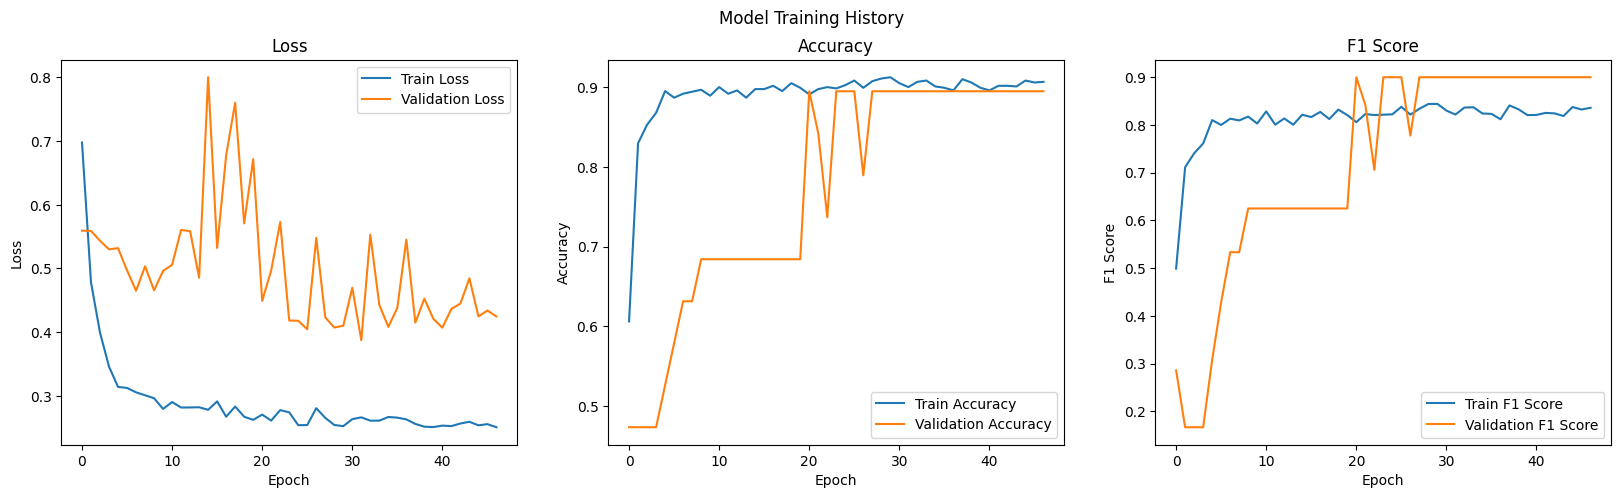


Script finished. Best model saved as 'best_model.keras' and final model as 'final_model.keras'.


In [26]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from scipy.signal import butter, filtfilt
from mne.decoding import CSP
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Configuration and Setup ---
print("TensorFlow Version:", tf.__version__)

# Constants
BASE_PATH = '/kaggle/input/mtcaic3/'
MI_CHANNELS_TO_USE = ['C3', 'CZ', 'C4']
FS = 250  # Sampling Rate
MI_SAMPLES = 2250 # 9 seconds * 250 Hz
N_CSP_COMPONENTS = 2

# Bandpass filter parameters for mu-rhythm
LOW_CUT = 8
HIGH_CUT = 13

# --- 2. Data Loading and Preprocessing Functions ---

def load_trial_data(row, base_path, channels):
    """Loads, slices, and selects channels for a single trial."""
    if row['id'] <= 4800:
        split = 'train'
    elif row['id'] <= 4900:
        split = 'validation'
    else:
        split = 'test'
        
    eeg_path = os.path.join(base_path, row['task'], split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    eeg_data = pd.read_csv(eeg_path)
    
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * MI_SAMPLES
    end_idx = start_idx + MI_SAMPLES
    
    trial_data = eeg_data.iloc[start_idx:end_idx][channels]
    
    return trial_data.values.T # Return as (channels, samples)

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Applies a bandpass filter to the data."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=-1)
    return y

def is_contralateral(trial_data, label):
    """
    Checks if a trial exhibits the expected contralateral ERD pattern.
    """
    c3_idx, c4_idx = 0, 2
    filtered_trial = bandpass_filter(trial_data, LOW_CUT, HIGH_CUT, FS)
    power_c3 = np.var(filtered_trial[c3_idx, :])
    power_c4 = np.var(filtered_trial[c4_idx, :])
    
    if label == 'Left' and power_c4 < power_c3:
        return True
    if label == 'Right' and power_c3 < power_c4:
        return True
    return False

# --- 3. Data Filtering based on Contralateral Pattern ---

print("--- Starting Data Filtering Process ---")

train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))

mi_train_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
mi_validation_df = validation_df[validation_df['task'] == 'MI'].reset_index(drop=True)

def filter_dataset(df, name):
    """Separates a dataframe into contralateral and noisy trials, then returns ONLY the noisy trials."""
    contralateral_indices = []
    noisy_indices = []

    for idx, row in df.iterrows():
        trial_data = load_trial_data(row, BASE_PATH, MI_CHANNELS_TO_USE)
        if is_contralateral(trial_data, row['label']):
            contralateral_indices.append(idx)
        else:
            noisy_indices.append(idx)
            
    print(f"[{name}] Original counts: {len(contralateral_indices)} contralateral trials, {len(noisy_indices)} noisy trials.")
    
    # ***** THE MODIFICATION IS HERE *****
    # We now only use the indices from the 'noisy' trials list, discarding all contralateral trials.
    final_indices = noisy_indices
    filtered_df = df.iloc[final_indices].reset_index(drop=True)

    print(f"[{name}] Filtered counts: 0 contralateral trials, {len(noisy_indices)} noisy trials.")
    print(f"[{name}] Total trials reduced from {len(df)} to {len(filtered_df)}.\n")
    
    return filtered_df

filtered_mi_train_df = filter_dataset(mi_train_df, "Training Set")
filtered_mi_validation_df = filter_dataset(mi_validation_df, "Validation Set")

# --- 4. Load and Prepare Data for Modeling ---

def prepare_data(df, base_path, channels):
    """Loads all trials from a dataframe into a numpy array."""
    X = []
    y = []
    for _, row in df.iterrows():
        trial_data = load_trial_data(row, base_path, channels)
        X.append(trial_data)
        y.append(row['label'])
    return np.array(X), np.array(y)

print("--- Loading Data for Model Training ---")

X_train_filt, y_train_filt_labels = prepare_data(filtered_mi_train_df, BASE_PATH, MI_CHANNELS_TO_USE)
X_val_filt, y_val_filt_labels = prepare_data(filtered_mi_validation_df, BASE_PATH, MI_CHANNELS_TO_USE)
X_val_orig, y_val_orig_labels = prepare_data(mi_validation_df, BASE_PATH, MI_CHANNELS_TO_USE)

# Handle case where filtered validation set might be empty or have only one class
if len(np.unique(y_val_filt_labels)) < 2:
    print("Filtered validation set has fewer than 2 classes. Skipping training.")
    # You might want to exit or handle this case differently
    # For now, we'll just print and let it potentially fail later if empty
else:
    le = LabelEncoder()
    y_train_filt = le.fit_transform(y_train_filt_labels)
    y_val_filt = le.transform(y_val_filt_labels)
    y_val_orig = le.transform(y_val_orig_labels)
    print(f"Label mapping: {le.classes_} -> {le.transform(le.classes_)}")

    # Reshape labels to be 2D (n_samples, 1)
    y_train_filt = y_train_filt.reshape(-1, 1)
    y_val_filt = y_val_filt.reshape(-1, 1)
    y_val_orig = y_val_orig.reshape(-1, 1)

    # --- 5. Apply CSP Transformation ---
    print("\n--- Applying CSP Filter ---")

    X_train_filt_bp = bandpass_filter(X_train_filt, 8, 30, FS)
    X_val_filt_bp = bandpass_filter(X_val_filt, 8, 30, FS)
    X_val_orig_bp = bandpass_filter(X_val_orig, 8, 30, FS)

    csp = CSP(n_components=N_CSP_COMPONENTS, reg=None, log=True, norm_trace=False)
    X_train_csp = csp.fit_transform(X_train_filt_bp, y_train_filt.ravel())
    X_val_filt_csp = csp.transform(X_val_filt_bp)
    X_val_orig_csp = csp.transform(X_val_orig_bp)

    X_train_cnn = X_train_csp[:, :, np.newaxis]
    X_val_filt_cnn = X_val_filt_csp[:, :, np.newaxis]
    X_val_orig_cnn = X_val_orig_csp[:, :, np.newaxis]

    print(f"Shape of training data for CNN: {X_train_cnn.shape}")
    print(f"Shape of filtered validation data for CNN: {X_val_filt_cnn.shape}")
    print(f"Shape of original validation data for CNN: {X_val_orig_cnn.shape}")

    # --- 6. Define and Train the CNN Model ---
    print("\n--- Defining and Training CNN Model ---")

    def create_cnn_model(input_shape):
        model = Sequential([
            Input(shape=input_shape),
            Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            
            Flatten(),
            
            Dense(50, activation='relu'),
            Dropout(0.5),
            
            Dense(1, activation='sigmoid')
        ])
        
        f1 = tf.keras.metrics.F1Score(average='macro', threshold=0.5, name='f1_score')
        
        model.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', f1])
        return model

    model = create_cnn_model(input_shape=(N_CSP_COMPONENTS, 1))
    model.summary()

    # Callbacks
    model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        X_train_cnn, 
        y_train_filt,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_filt_cnn, y_val_filt),
        callbacks=[model_checkpoint, early_stopping],
        verbose=2
    )

    model.save('final_model.keras')

    # --- 7. Evaluate the Model ---
    print("\n--- Model Evaluation ---")

    best_model = load_model('best_model.keras')

    # --- Evaluation on FILTERED Validation Set ---
    print("\n--- Classification Report on FILTERED Validation Set ---")
    y_pred_filt_prob = best_model.predict(X_val_filt_cnn)
    y_pred_filt = (y_pred_filt_prob > 0.5).astype(int)
    print(classification_report(y_val_filt, y_pred_filt, target_names=le.classes_))

    # --- Evaluation on ORIGINAL Validation Set ---
    print("\n--- Classification Report on ORIGINAL Validation Set ---")
    y_pred_orig_prob = best_model.predict(X_val_orig_cnn)
    y_pred_orig = (y_pred_orig_prob > 0.5).astype(int)
    print(classification_report(y_val_orig, y_pred_orig, target_names=le.classes_))

    # --- Plot Training History ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle('Model Training History')

    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    ax3.plot(history.history['f1_score'], label='Train F1 Score')
    ax3.plot(history.history['val_f1_score'], label='Validation F1 Score')
    ax3.set_title('F1 Score')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()

    plt.show()

    print("\nScript finished. Best model saved as 'best_model.keras' and final model as 'final_model.keras'.")

In [30]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.signal import butter, filtfilt
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')

# --- 1. Configuration and Setup ---
print("TensorFlow Version:", tf.__version__)

# Constants (should be identical to the training script)
BASE_PATH = '/kaggle/input/mtcaic3/'
MODEL_PATH = '/kaggle/working/best_model.keras' # Assuming the trained model is in the /kaggle/working/ directory
MI_CHANNELS_TO_USE = ['C3', 'CZ', 'C4']
FS = 250  # Sampling Rate
MI_SAMPLES = 2250 # 9 seconds * 250 Hz
N_CSP_COMPONENTS = 2

# Bandpass filter parameters
LOW_CUT_BP = 8
HIGH_CUT_BP = 30 # Use the wider band used for CSP in training
LOW_CUT_ERD = 8
HIGH_CUT_ERD = 13

# --- 2. Re-use Preprocessing Functions from Training Script ---
# These functions are copied directly to ensure consistency.

def load_trial_data(row, base_path, channels):
    """Loads, slices, and selects channels for a single trial."""
    if row['id'] <= 4800:
        split = 'train'
    elif row['id'] <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Correctly form the path using os.path.join
    subject_dir = row['subject_id']
    session_dir = str(row['trial_session'])
    eeg_path = os.path.join(base_path, row['task'], split, subject_dir, session_dir, 'EEGdata.csv')
    
    eeg_data = pd.read_csv(eeg_path)
    
    trial_num = int(row['trial'])
    samples_per_trial = MI_SAMPLES if row['task'] == 'MI' else 1750
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    trial_data = eeg_data.iloc[start_idx:end_idx][channels]
    
    return trial_data.values.T # Return as (channels, samples)

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Applies a bandpass filter to the data."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=-1)
    return y

def is_contralateral(trial_data, label):
    """Checks if a trial exhibits the expected contralateral ERD pattern."""
    c3_idx, c4_idx = 0, 2
    filtered_trial = bandpass_filter(trial_data, LOW_CUT_ERD, HIGH_CUT_ERD, FS)
    power_c3 = np.var(filtered_trial[c3_idx, :])
    power_c4 = np.var(filtered_trial[c4_idx, :])
    
    if label == 'Left' and power_c4 < power_c3:
        return True
    if label == 'Right' and power_c3 < power_c4:
        return True
    return False

def filter_dataset_for_csp_fitting(df):
    """Filters dataframe to get only the 'noisy' trials for fitting the CSP."""
    noisy_indices = []
    for idx, row in df.iterrows():
        trial_data = load_trial_data(row, BASE_PATH, MI_CHANNELS_TO_USE)
        if not is_contralateral(trial_data, row['label']):
            noisy_indices.append(idx)
    return df.iloc[noisy_indices].reset_index(drop=True)

def prepare_data(df, base_path, channels):
    """Loads all trials from a dataframe into a numpy array."""
    X = []
    y = []
    for _, row in df.iterrows():
        trial_data = load_trial_data(row, base_path, channels)
        X.append(trial_data)
        y.append(row['label'])
    return np.array(X), np.array(y)


# --- 3. Re-fit CSP and LabelEncoder to Replicate Training Conditions ---
print("--- Re-fitting CSP and LabelEncoder on filtered training data ---")

# Load and filter training data exactly as done in the training script
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
mi_train_df = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
filtered_mi_train_df = filter_dataset_for_csp_fitting(mi_train_df)

# Prepare data for fitting
X_train_filt, y_train_filt_labels = prepare_data(filtered_mi_train_df, BASE_PATH, MI_CHANNELS_TO_USE)

# Fit LabelEncoder
le = LabelEncoder()
y_train_filt = le.fit_transform(y_train_filt_labels)
print(f"Label mapping created: {le.classes_} -> {le.transform(le.classes_)}")

# Fit CSP
X_train_filt_bp = bandpass_filter(X_train_filt, LOW_CUT_BP, HIGH_CUT_BP, FS)
csp = CSP(n_components=N_CSP_COMPONENTS, reg=None, log=True, norm_trace=False)
csp.fit(X_train_filt_bp, y_train_filt)
print("CSP transformer has been successfully fitted.")


# --- 4. Load Model and Process Test Data ---
print("\n--- Loading trained model and preparing for prediction ---")

# Load the best model
model = load_model(MODEL_PATH)
print("Model 'best_model.keras' loaded successfully.")

# Load test set index
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Separate MI and SSVEP tasks from the test set
mi_test_df = test_df[test_df['task'] == 'MI'].reset_index(drop=True)
ssvep_test_df = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)

all_predictions = []

# --- 4a. Predict MI Trials ---
print(f"Predicting {len(mi_test_df)} MI trials...")
for _, row in mi_test_df.iterrows():
    # Load and preprocess a single test trial
    trial_data = load_trial_data(row, BASE_PATH, MI_CHANNELS_TO_USE)
    trial_bp = bandpass_filter(trial_data, LOW_CUT_BP, HIGH_CUT_BP, FS)
    
    # Reshape for CSP (needs to be 3D: [n_trials, n_channels, n_samples])
    trial_bp_reshaped = trial_bp[np.newaxis, :, :] 
    
    # Apply fitted CSP transformation
    trial_csp = csp.transform(trial_bp_reshaped)
    
    # Reshape for CNN (needs to be 3D: [n_trials, n_features, 1])
    trial_cnn = trial_csp[:, :, np.newaxis]
    
    # Predict
    prediction_prob = model.predict(trial_cnn, verbose=0)
    prediction_class_idx = (prediction_prob > 0.5).astype(int)
    
    # Decode the label
    prediction_label = le.inverse_transform(prediction_class_idx.flatten())[0]
    
    all_predictions.append({'id': row['id'], 'label': prediction_label})

print("MI prediction complete.")

# --- 4b. Predict SSVEP Trials (Random Guess) ---
print(f"Making random guesses for {len(ssvep_test_df)} SSVEP trials...")
ssvep_classes = ['Left', 'Right', 'Forward', 'Backward']
for _, row in ssvep_test_df.iterrows():
    # Model was not trained on SSVEP, so we make a random guess.
    random_label = np.random.choice(ssvep_classes)
    all_predictions.append({'id': row['id'], 'label': random_label})
    
print("SSVEP prediction complete.")

# --- 5. Generate Submission File ---
print("\n--- Generating submission file ---")

# Create a DataFrame from the predictions
submission_df = pd.DataFrame(all_predictions)

# Sort by 'id' to ensure the order is correct
submission_df = submission_df.sort_values(by='id').reset_index(drop=True)

# Save to csv
submission_df.to_csv('submission.csv', index=False)

print("submission.csv has been created successfully!")
print(submission_df.head())

TensorFlow Version: 2.18.0
--- Re-fitting CSP and LabelEncoder on filtered training data ---
Label mapping created: ['Left' 'Right'] -> [0 1]
CSP transformer has been successfully fitted.

--- Loading trained model and preparing for prediction ---
Model 'best_model.keras' loaded successfully.
Predicting 50 MI trials...
MI prediction complete.
Making random guesses for 50 SSVEP trials...
SSVEP prediction complete.

--- Generating submission file ---
submission.csv has been created successfully!
     id label
0  4901  Left
1  4902  Left
2  4903  Left
3  4904  Left
4  4905  Left
